In [ ]:
#pip install --upgrade scikit-learn
#pip install lime
#si erreur tapper directement du shell

# 0) IMPORT et TRANSFO DES FICHIERS "month_balance"
synthese describe

In [2]:
#IMPORT
import pandas as pd
import numpy as np
# balance par mois sur les credits en statut
data_burbal = pd.read_csv('input/Projet/bureau_balance.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
#precedents home credit reliés
data_cashbal = pd.read_csv('input/Projet/POS_CASH_balance.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
data_cardbal = pd.read_csv('input/Projet/credit_card_balance.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
data_pay = pd.read_csv('input/Projet/installments_payments.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
data_prevap = pd.read_csv('input/Projet/previous_application.csv', delimiter = ',',error_bad_lines=False,low_memory=False)

## 0) A : BUREAU CREDIT

In [ ]:
import time
###################################################################################### TRANSFO BURBAL (53 minutes)
#travail sur le formattage du fichier bureau balance
pd.set_option('max_rows', None)
#display(data_burbal.loc[data_burbal.SK_ID_BUREAU==5041336])#5715448])
pd.set_option('max_rows', 10)

#on vire les C & X qui ne nous serviront à rien
burbal=data_burbal.loc[(data_burbal.STATUS!='C')&(data_burbal.STATUS!='X')]
#on pondere le status par le mois
burbal.STATUS=pd.to_numeric(burbal.STATUS)
burbal['STATUS_MW']=-(burbal.STATUS)/(burbal.MONTHS_BALANCE-1)

#tri (6sec pour 10Millions de lignes)
burbal2=burbal.sort_values(['SK_ID_BUREAU','MONTHS_BALANCE'])

#ajout du percentile
burbal2['PRank'] = burbal2.SK_ID_BUREAU.rank(pct = True)


col=['count','mean','std','min','25%','med','75%','max']
col1=['mean','std','min','25%','75%','max']
col2=['count','std','min','25%','med','75%']

liscol =['MONTH_' + element for element in col]+['STATUS_' + element for element in col]+\
['STATUS_MW_' + element for element in col]+['PCT_' + element for element in col]

liscolrem =['MONTH_' + element for element in col1]+['PCT_' + element for element in col]+\
['STATUS_' + element for element in col2]+['STATUS_MW_' + element for element in col2]
#boucle sur les 100 percentiles (on a divise en 100 pour mieux controler le temps)
import numpy as np
lisper=np.arange(0, 1, 0.01).tolist()

for i in lisper:
    j=i+0.01
    start = time.time()
    burbal_temp=burbal2.loc[(burbal2.PRank>=i)&(burbal2.PRank<=j)].groupby(['SK_ID_BUREAU']).describe(percentiles=None)
    end = time.time()
    print('Percentile',j,':',{end - start})
          
    if i==0:
        temp=burbal_temp.copy()
        temp.columns=liscol
        #display(temp)
        
    else:
        burbal_temp.columns=liscol
        #display(cashbal_temp)
        temp=pd.concat([temp,burbal_temp], axis=0)

temp=temp.drop(columns=liscolrem)  
temp.to_csv('input/Projet/bureau_balance2.csv', sep = ',')

In [4]:
###################################################################################### JOINTURE BURBAL BUREAU
data_burbal2 = pd.read_csv('input/Projet/bureau_balance2.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
data_bur = pd.read_csv('input/Projet/bureau.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
#set up de l index
data_burbal2=data_burbal2.set_index('SK_ID_BUREAU')
data_bur=data_bur.set_index('SK_ID_BUREAU')
#jointure (sur index à gauche)
bur=data_bur.join(data_burbal2)

#data_bur=bur.loc[bur.MONTH_count.notnull()].copy()#virer lecount null dans le vrai

#reset de l index
data_bur=bur.copy()
data_bur=data_bur.reset_index()

#pd.set_option('max_columns', None)
#display(data_bur)
#pd.set_option('max_columns', 10)

In [ ]:
###################################################################################### TRANSFO BUREAU (3/4 heures)
print(bur.columns)
####visualisation rapide
pd.set_option('max_columns',None)
#display(data_bur.loc[data_bur.DAYS_CREDIT_ENDDATE<0])
pd.set_option('max_columns',10)
display(data_bur.CREDIT_ACTIVE.value_counts(normalize=True,dropna=False)*100)
display(data_bur.CREDIT_CURRENCY.value_counts(normalize=True,dropna=False)*100)
display(data_bur.CREDIT_DAY_OVERDUE.value_counts(normalize=True,dropna=False)*100)
display(data_bur.CNT_CREDIT_PROLONG.value_counts(normalize=True,dropna=False)*100)

#du/pret
data_bur.loc[data_bur.AMT_CREDIT_SUM==0,'AMT_CREDIT_SUM']=1
data_bur['DEBTPCT']=data_bur.AMT_CREDIT_SUM_DEBT/data_bur.AMT_CREDIT_SUM

import matplotlib.pyplot as plt
datanull0=1-(bur.isnull().sum()/bur.shape[0])
plt.figure(figsize=(16,10))
ax = datanull0.plot.barh( color="#8d19a9",title='Pourcentage de données par variable filtrée', xlabel='pourcentage de données')
ax.grid(zorder=0)
plt.show()

#on cut les peu remplis
bur=data_bur.drop(columns=['CREDIT_CURRENCY','AMT_ANNUITY','AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_MAX_OVERDUE','DAYS_ENDDATE_FACT'])

#tri
bur=bur.sort_values(['SK_ID_CURR', 'SK_ID_BUREAU'])

#decompo active/closed
burclo=bur.loc[bur.CREDIT_ACTIVE=='Closed',:]
buract=bur.loc[bur.CREDIT_ACTIVE=='Active',:]

#ajout du percentile
bur['PRank'] = bur.SK_ID_CURR.rank(pct = True)
burclo['PRank'] = burclo.SK_ID_CURR.rank(pct = True)
buract['PRank'] = buract.SK_ID_CURR.rank(pct = True)

####aggregation
#liste des colonnes
col=['count','mean','std','min','25%','med','75%','max']
col1=['mean','std','min','25%','med','75%','max']
coldr=['count','std','25%','75%']

    #liste des colonnes apres describe()
liscol =['B_ID_BUR_' + element for element in col]+['B_DAYS_APP_' + element for element in col]+['B_DAYS_PD_' + element for element in col]+\
['B_DAYS_END_' + element for element in col]+['B_PROL_' + element for element in col]+\
['B_CRED_SUM_' + element for element in col]+['B_CRED_DEBT_' + element for element in col]+['B_CRED_OD_' + element for element in col]+\
['B_CRED_UPD_' + element for element in col]+['BB_MONTH_count_' + element for element in col]+['BB_MONTH_med_' + element for element in col]+\
['BB_STATUS_mean_' + element for element in col]+['BB_STATUS_max_' + element for element in col]+['BB_STATUS_MW_mean_' + element for element in col]+\
['BB_STATUS_MW_max_' + element for element in col]+['B_CRED_DEBTPCT_' + element for element in col]+['B_PRANK_' + element for element in col]
liscol_clo=['CLO_' + element for element in liscol]
liscol_act=['ACT_' + element for element in liscol]

    #liste des colonnes inutiles apres decribe()
liscolrem =['B_ID_BUR_' + element for element in col1]+['B_DAYS_APP_' + element for element in coldr]+['B_DAYS_PD_' + element for element in coldr]+\
['B_DAYS_END_' + element for element in coldr]+['B_PROL_' + element for element in coldr]+\
['B_CRED_SUM_' + element for element in coldr]+['B_CRED_DEBT_' + element for element in coldr]+['B_CRED_OD_' + element for element in coldr]+\
['B_CRED_UPD_' + element for element in coldr]+['BB_MONTH_count_' + element for element in coldr]+['BB_MONTH_med_' + element for element in coldr]+\
['BB_STATUS_mean_' + element for element in coldr]+['BB_STATUS_max_' + element for element in coldr]+['BB_STATUS_MW_mean_' + element for element in coldr]+\
['BB_STATUS_MW_max_' + element for element in coldr]+['B_CRED_DEBTPCT_' + element for element in coldr]+['B_PRANK_' + element for element in col]
liscolrem_clo=['CLO_' + element for element in liscolrem]
liscolrem_act=['ACT_' + element for element in liscolrem]


pd.set_option('max_columns',None)
display(bur)
pd.set_option('max_columns',10)

#############################################################################
import numpy as np
lisper=np.arange(0, 1, 0.01).tolist()

for i in lisper:
    j=i+0.01
    start = time.time()
    bur_temp=bur.loc[(bur.PRank>=i)&(bur.PRank<=j)].groupby(['SK_ID_CURR']).describe(percentiles=None)
    burclo_temp=burclo.loc[(burclo.PRank>=i)&(burclo.PRank<=j)].groupby(['SK_ID_CURR']).describe(percentiles=None)
    buract_temp=buract.loc[(buract.PRank>=i)&(buract.PRank<=j)].groupby(['SK_ID_CURR']).describe(percentiles=None)
    end = time.time()
    print('Percentile',j,':',{end - start})
          
    if i==0:
        temp=bur_temp.copy()
        tempclo=burclo_temp.copy()
        tempact=buract_temp.copy()
        
        temp.columns=liscol
        tempclo.columns=liscol_clo
        tempact.columns=liscol_act
    else:
        bur_temp.columns=liscol
        burclo_temp.columns=liscol_clo
        buract_temp.columns=liscol_act
        
        temp=pd.concat([temp,bur_temp], axis=0)
        tempclo=pd.concat([tempclo,burclo_temp], axis=0)
        tempact=pd.concat([tempact,buract_temp], axis=0)
        
#on retire les colonnes inutiles
tempbur=temp.drop(columns=liscolrem)
tempclo=tempclo.drop(columns=liscolrem_clo)
tempact=tempact.drop(columns=liscolrem_act)

#jointure (sur index à gauche)
temp1=tempbur.join(tempclo)
temp2=temp1.join(tempact)

#sauvegarde
temp2.to_csv('input/Projet/bureau_ultime.csv', sep = ',')
#import
data_buru= pd.read_csv('input/Projet/bureau_ultime.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
        

## 0) B: HOME CREDIT

In [ ]:
###################################################################################### #TRANSFO installments payment
#3h de calcul
pay=data_pay.copy()
pay=pay.sort_values(['SK_ID_PREV','NUM_INSTALMENT_NUMBER','NUM_INSTALMENT_VERSION'])
pay1=pay.drop_duplicates(subset =['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], keep ='last', inplace=False)
pay1['LAG_PAY']=pay1.DAYS_ENTRY_PAYMENT-pay1.DAYS_INSTALMENT
pay1['DIF_PAY']=pay1.AMT_PAYMENT-pay1.AMT_INSTALMENT


#ajout du percentile
pay1['PRank'] = pay1.SK_ID_PREV.rank(pct = True)

#future liste de nom de variable
col=['count','mean','std','min','25%','med','75%','max']
col1=['mean','std','min','25%','75%','max']
col2=['count','std','25%','75%']
liscol =['ID_CURR_' + element for element in col]+['IP_NUMVER_' + element for element in col]+\
['IP_NUMINST_' + element for element in col]+['IP_DAYINST_' + element for element in col]+['IP_DAYPAY_' + element for element in col]+\
['IP_AMTINST_' + element for element in col]+['IP_AMTPAY_' + element for element in col]+['IP_LAGPAY_' + element for element in col]+\
['IP_DIFPAY_' + element for element in col]+['PCT_' + element for element in col]
liscolrem =['ID_CURR_' + element for element in col]+['IP_NUMVER_' + element for element in col1]+\
['IP_NUMINST_' + element for element in col2]+['IP_DAYINST_' + element for element in col2]+['IP_DAYPAY_' + element for element in col2]+\
['IP_AMTINST_' + element for element in col2]+['IP_AMTPAY_' + element for element in col2]+['IP_LAGPAY_' + element for element in col2]+\
['IP_DIFPAY_' + element for element in col2]+['PCT_' + element for element in col]
#boucle sur les 100 percentiles (on a divise en 100 pour mieux controler le temps)
import numpy as np
lisper=np.arange(0, 1, 0.01).tolist()

for i in lisper:
    j=i+0.01
    start = time.time()
    pay_temp=pay1.loc[(pay1.PRank>=i)&(pay1.PRank<=j)].groupby(['SK_ID_PREV']).describe(percentiles=None)
    end = time.time()
    print('Percentile',j,':',{end - start})
          
    if i==0:
        temp=pay_temp.copy()
        temp.columns=liscol
        #display(temp)
        
    else:
        pay_temp.columns=liscol
        #display(cardbal_temp)
        temp=pd.concat([temp,pay_temp], axis=0)

temp['SK_ID_CURR']=temp.ID_CURR_min.astype(int)    
temp=temp.drop(columns=liscolrem)

temp.to_csv('input/Projet/installments_payments2.csv', sep = ',')
data_pay3 = pd.read_csv('input/Projet/installments_payments2.csv', delimiter = ',',error_bad_lines=False,low_memory=False)

In [ ]:
###################################################################################### TRANSFO POS & CASH LOANS BALANCE 
#2h30 de calcul
import time
#ajout d'une variable de DPD warning
data_cashbal['SK_DPD_WARN']=data_cashbal['SK_DPD']-data_cashbal['SK_DPD_DEF']
data_cashbal['SK_DPD_WARN_MW']=-data_cashbal['SK_DPD_WARN']/(data_cashbal['MONTHS_BALANCE']-1)
data_cashbal['INST_FUT_APP']=data_cashbal['MONTHS_BALANCE']+data_cashbal['CNT_INSTALMENT_FUTURE']

#tri (6sec pour 10Millions de lignes)
cashbal2=data_cashbal.sort_values(['SK_ID_PREV','MONTHS_BALANCE'])

#ajout du percentile
cashbal2['PRank'] = cashbal2.SK_ID_PREV.rank(pct = True)

#completed -> month
comp=cashbal2.loc[cashbal2.NAME_CONTRACT_STATUS=='Completed',['SK_ID_PREV','SK_ID_CURR','MONTHS_BALANCE']]
comp.columns=['SK_ID_PREV','SK_ID_CURR','POS_MONTH_COMPLETION']

#future liste de nom de variable
col=['count','mean','std','min','25%','med','75%','max']
col1=['mean','std','min','25%','75%','max']
col2=['count','std','25%','75%']
liscol =['ID_CURR_' + element for element in col]+['POS_MONTH_' + element for element in col]+\
['POS_INST_' + element for element in col]+['POS_INSTFUT_' + element for element in col]+\
['POS_DPD_' + element for element in col]+['POS_DPDD_' + element for element in col]+['POS_DPDW_' + element for element in col]+\
['POS_DPDW_MW' + element for element in col]+['POS_INSTFUT0_' + element for element in col]+['PCT_' + element for element in col]
liscolrem =['ID_CURR_' + element for element in col]+['POS_MONTH_' + element for element in col1]+\
['POS_INST_' + element for element in col2]+['POS_INSTFUT_' + element for element in col2]+\
['POS_DPD_' + element for element in col2]+['POS_DPDD_' + element for element in col2]+['POS_DPDW_' + element for element in col2]+\
['POS_DPDW_MW' + element for element in col2]+['POS_INSTFUT0_' + element for element in col2]+['PCT_' + element for element in col]
#boucle sur les 100 percentiles (on a divise en 100 pour mieux controler le temps)
import numpy as np
lisper=np.arange(0, 1, 0.01).tolist()

for i in lisper:
    j=i+0.01
    start = time.time()
    cashbal_temp=cashbal2.loc[(cashbal2.PRank>=i)&(cashbal2.PRank<=j)].groupby(['SK_ID_PREV']).describe(percentiles=None)
    end = time.time()
    print('Percentile',j,':',{end - start})
          
    if i==0:
        temp=cashbal_temp.copy()
        temp.columns=liscol
        #display(temp)
        
    else:
        cashbal_temp.columns=liscol
        #display(cashbal_temp)
        temp=pd.concat([temp,cashbal_temp], axis=0)

temp['SK_ID_CURR']=temp.ID_CURR_min.astype(int)    
temp=temp.drop(columns=liscolrem)

#attetion avec le CONCAT : on ne peut faire que de l inner ou de l outer
#alors qu avec le MERGE on peut aussi utiliser left and right
#le join a gauche

comp1=comp.drop_duplicates(subset =['SK_ID_PREV','SK_ID_CURR'], keep = 'first', inplace=False)
comp1=comp1.set_index('SK_ID_PREV')
temp1=temp.join(comp1['POS_MONTH_COMPLETION'])

#dans l'ideal il faudrait peut etre faire une separation active/completed

temp1.to_csv('input/Projet/pos_cash_balance2.csv', sep = ',')
data_cashbal3 = pd.read_csv('input/Projet/pos_cash_balance2.csv', delimiter = ',',error_bad_lines=False,low_memory=False)

In [ ]:
data_cardbal = pd.read_csv('input/Projet/credit_card_balance.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
print(data_cardbal.shape[0])
print(data_cardbal.columns)
display(data_cardbal.value_counts('NAME_CONTRACT_STATUS'))
display(data_cardbal.value_counts('SK_ID_PREV'))
display(data_cardbal.loc[data_cardbal.NAME_CONTRACT_STATUS=='Active'].value_counts('SK_ID_PREV'))
display(data_cardbal.loc[data_cardbal.NAME_CONTRACT_STATUS=='Completed'].value_counts('SK_ID_PREV'))

display(data_cardbal.value_counts('SK_ID_CURR'))
display(data_cardbal.loc[data_cardbal.NAME_CONTRACT_STATUS=='Active'].value_counts('SK_ID_CURR'))
display(data_cardbal.loc[data_cardbal.NAME_CONTRACT_STATUS=='Completed'].value_counts('SK_ID_CURR'))

In [ ]:
###################################################################################### TRANSFO CARDBAL (16 min)
import time
data_cardbal['SK_DPD_WARN']=data_cardbal['SK_DPD']-data_cardbal['SK_DPD_DEF']
#print(data_cardbal.columns)
liscol=['SK_ID_PREV','SK_ID_CURR','MONTHS_BALANCE','AMT_CREDIT_LIMIT_ACTUAL','CNT_DRAWINGS_ATM_CURRENT',\
        'CNT_DRAWINGS_CURRENT','CNT_DRAWINGS_OTHER_CURRENT','CNT_DRAWINGS_POS_CURRENT','SK_DPD','SK_DPD_WARN']

#on garde que les active
cardbal2=data_cardbal.loc[data_cardbal.NAME_CONTRACT_STATUS=='Active',:]
cardbal2=cardbal2.loc[:,liscol].copy()

#tri (6sec pour 10Millions de lignes)
cardbal2=cardbal2.sort_values(['SK_ID_PREV','MONTHS_BALANCE'])

#ajout du percentile
cardbal2['PRank'] = cardbal2.SK_ID_PREV.rank(pct = True)
#display(cardbal2)

#completed -> month
compl=data_cardbal.copy()
compl=compl.loc[compl.NAME_CONTRACT_STATUS=='Completed',['SK_ID_PREV','SK_ID_CURR','MONTHS_BALANCE']]
compl=compl.sort_values(['SK_ID_PREV','MONTHS_BALANCE'])
compl.columns=['SK_ID_PREV','SK_ID_CURR','MONTH_COMPLETION']
#display(compl)
compl1=compl.drop_duplicates(subset =['SK_ID_PREV'], keep ='first', inplace=False)

#active -> last month
act=data_cardbal.copy()
act=act.loc[act.NAME_CONTRACT_STATUS=='Active',['SK_ID_PREV','SK_ID_CURR','MONTHS_BALANCE']]
act=act.sort_values(['SK_ID_PREV','MONTHS_BALANCE'])
act.columns=['SK_ID_PREV','SK_ID_CURR','LMONTH_ACT']
#display(act)
act1=act.drop_duplicates(subset =['SK_ID_PREV'], keep ='last', inplace=False)
#fusion completed_active: 
    #concat duplique les colonnes si viennent de table differente
comp=pd.merge(act1,compl1,how='outer', on=['SK_ID_PREV', 'SK_ID_CURR'])

#future liste de nom de variable
col=['count','mean','std','min','25%','med','75%','max']
col1=['mean','std','min','25%','75%','max']
col2=['count','std','25%','75%']
liscol =['ID_CURR_' + element for element in col]+['CB_MONTH_' + element for element in col]+['CB_LIM_' + element for element in col]+\
['CB_CDC_ATM_' + element for element in col]+['CB_CDC_' + element for element in col]+['CB_CDC_OTH_' + element for element in col]+\
['CB_CDC_POS_' + element for element in col]+['CB_DPDD_' + element for element in col]+['CB_DPDW_' + element for element in col]+\
['PCT_' + element for element in col]
liscolrem =['ID_CURR_' + element for element in col]+['CB_MONTH_' + element for element in col1]+['CB_LIM_' + element for element in col2]+\
['CB_CDC_ATM_' + element for element in col2]+['CB_CDC_' + element for element in col2]+['CB_CDC_OTH_' + element for element in col2]+\
['CB_CDC_POS_' + element for element in col2]+['CB_DPDD_' + element for element in col2]+['CB_DPDW_' + element for element in col2]+\
['PCT_' + element for element in col]
#boucle sur les 100 percentiles (on a divise en 100 pour mieux controler le temps)
import numpy as np
lisper=np.arange(0,1, 0.01).tolist()

for i in lisper:
    j=i+0.01
    start = time.time()
    cardbal_temp=cardbal2.loc[(cardbal2.PRank>=i)&(cardbal2.PRank<=j)].groupby(['SK_ID_PREV']).describe(percentiles=None)
    end = time.time()
    print('Percentile',j,':',{end - start})
          
    if i==0:
        temp=cardbal_temp.copy()
        temp.columns=liscol
        #display(temp)
        
    else:
        cardbal_temp.columns=liscol
        #display(cardbal_temp)
        temp=pd.concat([temp,cardbal_temp], axis=0)

temp['SK_ID_CURR']=temp.ID_CURR_min.astype(int)    
temp=temp.drop(columns=liscolrem)

comp=comp.set_index('SK_ID_PREV')
comp1=comp.drop(columns=['SK_ID_CURR'])
comp1.columns=['CB_LMONTH_ACT', 'CB_MONTH_COMPLETION']
temp1=temp.join(comp1)

temp1.to_csv('input/Projet/card_balance2.csv', sep = ',')
data_cb = pd.read_csv('input/Projet/card_balance2.csv', delimiter = ',',error_bad_lines=False,low_memory=False)

In [ ]:
###################################################################################### previous application

#renseignes que si APPROVED
        #DAYS_FIRST_DRAWING
        #DAYS_FIRST_DUE
        #DAYS_LAST_DUE_1ST_VERSION
        #DAYS_LAST_DUE
        #DAYS_TERMINATION
        #NFLAG_INSURED_ON_APPROVAL
        
#apport renseigné que si consumer loans 

pd.set_option('max_columns',None)
#display(data_prevap)
pd.set_option('max_columns',10)

#XNA en NA
data_prevap=data_prevap.replace('XNA', np.nan)

#FENGINEERING
data_prevap['RATE']=(1/data_prevap.CNT_PAYMENT)*(data_prevap.CNT_PAYMENT*data_prevap.AMT_ANNUITY/data_prevap.AMT_CREDIT-1)
data_prevap['AMT_SUR']=(data_prevap.AMT_CREDIT-data_prevap.AMT_APPLICATION)/data_prevap.AMT_CREDIT
data_prevap['DUR']=data_prevap.AMT_CREDIT/data_prevap.AMT_ANNUITY #CNT
data_prevap['CREDPRICE']=data_prevap.AMT_CREDIT/data_prevap.AMT_GOODS_PRICE
data_prevap['APPPRICE']=data_prevap.AMT_DOWN_PAYMENT/data_prevap.AMT_GOODS_PRICE

#display(data_prevap.NAME_CONTRACT_TYPE.value_counts()) #3 cash/cons/revol
#display(data_prevap.FLAG_LAST_APPL_PER_CONTRACT.value_counts()) #flag Y/N mais assez faible: 1.7Million/8500
#display(data_prevap.NFLAG_LAST_APPL_IN_DAY.value_counts()) #flag 0/1 mais assez faible:
#display(data_prevap.NAME_CONTRACT_STATUS.value_counts()) #4 approved refused
#display(data_prevap.NAME_CLIENT_TYPE.value_counts()) #3 repeater / new /refresher
#display(data_prevap.SELLERPLACE_AREA.value_counts()) #10 trop
#display(data_prevap.NAME_YIELD_GROUP.value_counts()) #4 middle high lownormale 
#display(data_prevap.NFLAG_INSURED_ON_APPROVAL.value_counts())  #0/1

#display(data_prevap.NAME_CASH_LOAN_PURPOSE.value_counts()) #24
#display(data_prevap.NAME_TYPE_SUITE.value_counts()) #accompagne de qui
#display(data_prevap.NAME_PRODUCT_TYPE.value_counts()) #walkin ou cross
#display(data_prevap.NAME_PAYMENT_TYPE.value_counts()) #majorite cash trough the bank
#display(data_prevap.NAME_GOODS_CATEGORY.value_counts()) #27 trop
#display(data_prevap.NAME_PORTFOLIO.value_counts()) #4 pos / card / cash /car
#display(data_prevap.CHANNEL_TYPE.value_counts()) #8
#display(data_prevap.NAME_SELLER_INDUSTRY.value_counts())

#EXCLUSION pour sens ou donnée
prevap=data_prevap.drop(columns=['FLAG_LAST_APPL_PER_CONTRACT','NFLAG_LAST_APPL_IN_DAY','NAME_CLIENT_TYPE','SELLERPLACE_AREA',\
                                'WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START','NAME_CASH_LOAN_PURPOSE',\
                                 'NAME_TYPE_SUITE','RATE_INTEREST_PRIVILEGED','RATE_INTEREST_PRIMARY','NAME_PRODUCT_TYPE',\
                                 'NAME_PAYMENT_TYPE','NAME_GOODS_CATEGORY','CHANNEL_TYPE','NAME_SELLER_INDUSTRY',\
                                'CODE_REJECT_REASON','RATE_INTEREST_PRIVILEGED','RATE_INTEREST_PRIMARY','PRODUCT_COMBINATION']) #'NAME_PORTFOLIO' 

#6 cat  (le reste: 2ID NUM / 18 NUM (dont 6 cree))
display(data_prevap.NAME_CONTRACT_TYPE.value_counts())
display(data_prevap.NAME_CONTRACT_STATUS.value_counts())
#display(data_prevap.CODE_REJECT_REASON.value_counts()) #on le fait sauter mais on aurait pu le garder
display(data_prevap.NAME_PORTFOLIO.value_counts())
display(data_prevap.NAME_YIELD_GROUP.value_counts())
#display(data_prevap.NFLAG_INSURED_ON_APPROVAL.value_counts()) #(deja en dummies)

prev=prevap.drop(columns=['NAME_CONTRACT_TYPE','NAME_CONTRACT_STATUS','NAME_PORTFOLIO','NAME_YIELD_GROUP'])

#qu on devra passer en dummies
dummies_g1=pd.get_dummies(data_prevap['NAME_CONTRACT_TYPE'], prefix=None, prefix_sep='_', dummy_na=False)
dummies_g2=pd.get_dummies(data_prevap['NAME_CONTRACT_STATUS'], prefix=None, prefix_sep='_', dummy_na=False)
dummies_g3=pd.get_dummies(data_prevap['NAME_PORTFOLIO'], prefix=None, prefix_sep='_', dummy_na=False)
dummies_g4=pd.get_dummies(data_prevap['NAME_YIELD_GROUP'], prefix=None, prefix_sep='_', dummy_na=False)

#concat
prev = pd.concat([prev, dummies_g1, dummies_g2, dummies_g3, dummies_g4], axis=1)

import matplotlib.pyplot as plt
datanull0=1-(prev.isnull().sum()/prev.shape[0])
plt.figure(figsize=(16,7))
ax = datanull0.plot.barh( color="#8d19a9",title='Pourcentage de données par variable filtrée', xlabel='pourcentage de données')
ax.grid(zorder=0)
plt.show()

########################fusionner sur SK_ID_PREV
data_inst = pd.read_csv('input/Projet/installments_payments2.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
data_inst=data_inst.set_index('SK_ID_PREV')
data_inst=data_inst.drop(columns=['SK_ID_CURR'])
data_cb = pd.read_csv('input/Projet/card_balance2.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
data_cb=data_cb.set_index('SK_ID_PREV')
data_cb=data_cb.drop(columns=['SK_ID_CURR'])
data_poscash = pd.read_csv('input/Projet/pos_cash_balance2.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
data_poscash=data_poscash.set_index('SK_ID_PREV')
data_poscash=data_poscash.drop(columns=['SK_ID_CURR'])

prev_=prev.sort_values('SK_ID_PREV')
prev_=prev_.set_index('SK_ID_PREV')
display(prev_)
display(data_inst)
display(data_cb)
display(data_poscash)

prev2=prev_.join(data_inst)
prev2=prev2.join(data_cb)
prev2=prev2.join(data_poscash)
#puis describe

In [ ]:
##############################################################################
#pour cette derniere on evite le describe qui est beaucoup beaucoup trop long#
##############################################################################

import matplotlib.pyplot as plt
datanull0=1-(prev2.isnull().sum()/prev2.shape[0])
plt.figure(figsize=(16,20))
ax = datanull0.plot.barh( color="#8d19a9",title='Pourcentage de données par variable filtrée', xlabel='pourcentage de données')
ax.grid(zorder=0)
plt.show()

#ajout du percentile
prev3=prev2.copy()
#prev3['PRank'] = prev3.SK_ID_CURR.rank(pct = True)

prev3=prev3.reset_index()

#set up des listes
lisprev=prev3.columns
liscol=[]
for i in lisprev:
    liscol =liscol + ['HO_'+i]
liscol.remove('HO_SK_ID_CURR')

prev3_mean=prev3.groupby(['SK_ID_CURR']).mean()
prev3_mean.columns=liscol

import matplotlib.pyplot as plt
datanull0=1-(prev3_mean.isnull().sum()/prev3_mean.shape[0])
plt.figure(figsize=(16,20))
ax = datanull0.plot.barh( color="#8d19a9",title='Pourcentage de données par variable filtrée', xlabel='pourcentage de données')
ax.grid(zorder=0)
plt.show()

prev3_mean.to_csv('input/Projet/home_credit.csv', sep = ',')


# 1) IMPORT
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Baseline

In [1]:
import pandas as pd
import numpy as np
#########IMPORT
data_train = pd.read_csv('input/Projet/application_train.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
data_train = data_train.set_index('SK_ID_CURR')
# credits précedents externes reliés au credit actuel
data_bur = pd.read_csv('input/Projet/bureau_ultime.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
data_bur = data_bur.set_index('SK_ID_CURR')
# credits précedents internes reliés au credit actuel
data_hom = pd.read_csv('input/Projet/home_credit.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
data_hom = data_hom.set_index('SK_ID_CURR')

print('le fichier train contient ','\033[1m',data_train.shape[0],'lignes','\033[0m',' et ','\033[1m',data_train.shape[1],'colonnes','\033[0m')
print('le fichier bur contient ','\033[1m',data_bur.shape[0],'lignes','\033[0m',' et ','\033[1m',data_bur.shape[1],'colonnes','\033[0m')
print('le fichier hom contient ','\033[1m',data_hom.shape[0],'lignes','\033[0m',' et ','\033[1m',data_hom.shape[1],'colonnes','\033[0m')

pd.set_option('max_rows',None)
pd.set_option('max_rows',10)

le fichier train contient   307511 lignes   et   121 colonnes 
le fichier bur contient   305820 lignes   et   183 colonnes 
le fichier hom contient   338857 lignes   et   128 colonnes 


# 2) FUSION des tables pour faire les mêmes nettoyages

In [2]:
#pour rappel les jointures se font toujours sur les index a gauche
data=data_train.join(data_hom)
data=data.join(data_bur)
print('le fichier data contient ','\033[1m',data.shape[0],'lignes','\033[0m',' et ','\033[1m',data.shape[1],'colonnes','\033[0m')

le fichier data contient   307519 lignes   et   432 colonnes 


# 3) *verif doublons*
* *FACULTATIF: pas de doublons*

In [ ]:
def doublonrem(datain,datanam,keynam):
    temp=datain.copy()
    temp2=temp.drop_duplicates(subset =keynam, keep = 'last', inplace=False)
    #inplace -> renvoie une table filtrée ou modifie directement la table de base sans rien renvoyer
    print('extraction de ', temp2.shape[0]-datain.shape[0],'doublons de la table ',datanam,' basée sur la variable ',keynam)
    return temp2


# 4) Nettoyage données numeriques

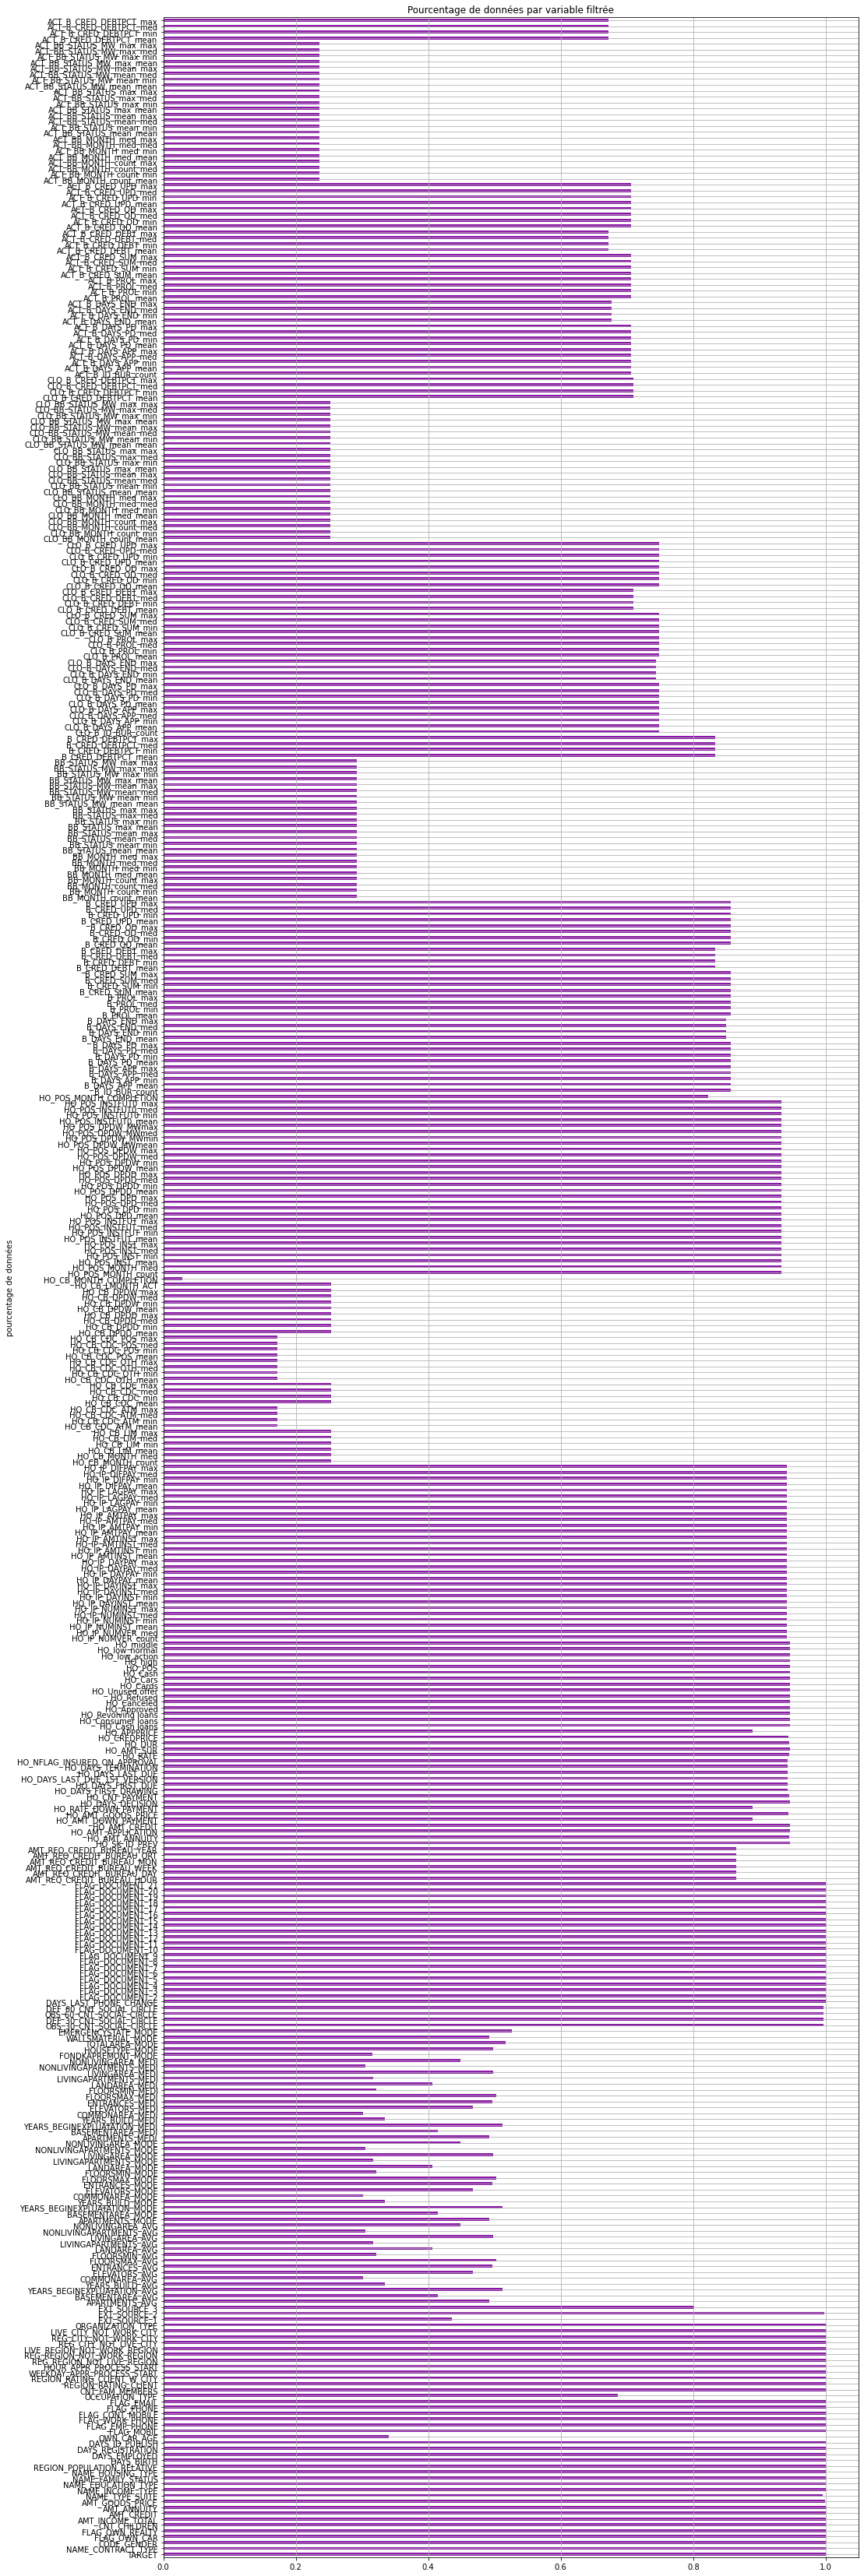

In [3]:
import matplotlib.pyplot as plt

datanull0=1-(data.isnull().sum()/data.shape[0])
plt.figure(figsize=(16,60))
ax = datanull0.plot.barh( color="#8d19a9",title='Pourcentage de données par variable filtrée', xlabel='pourcentage de données')
ax.grid(zorder=0)
plt.show()

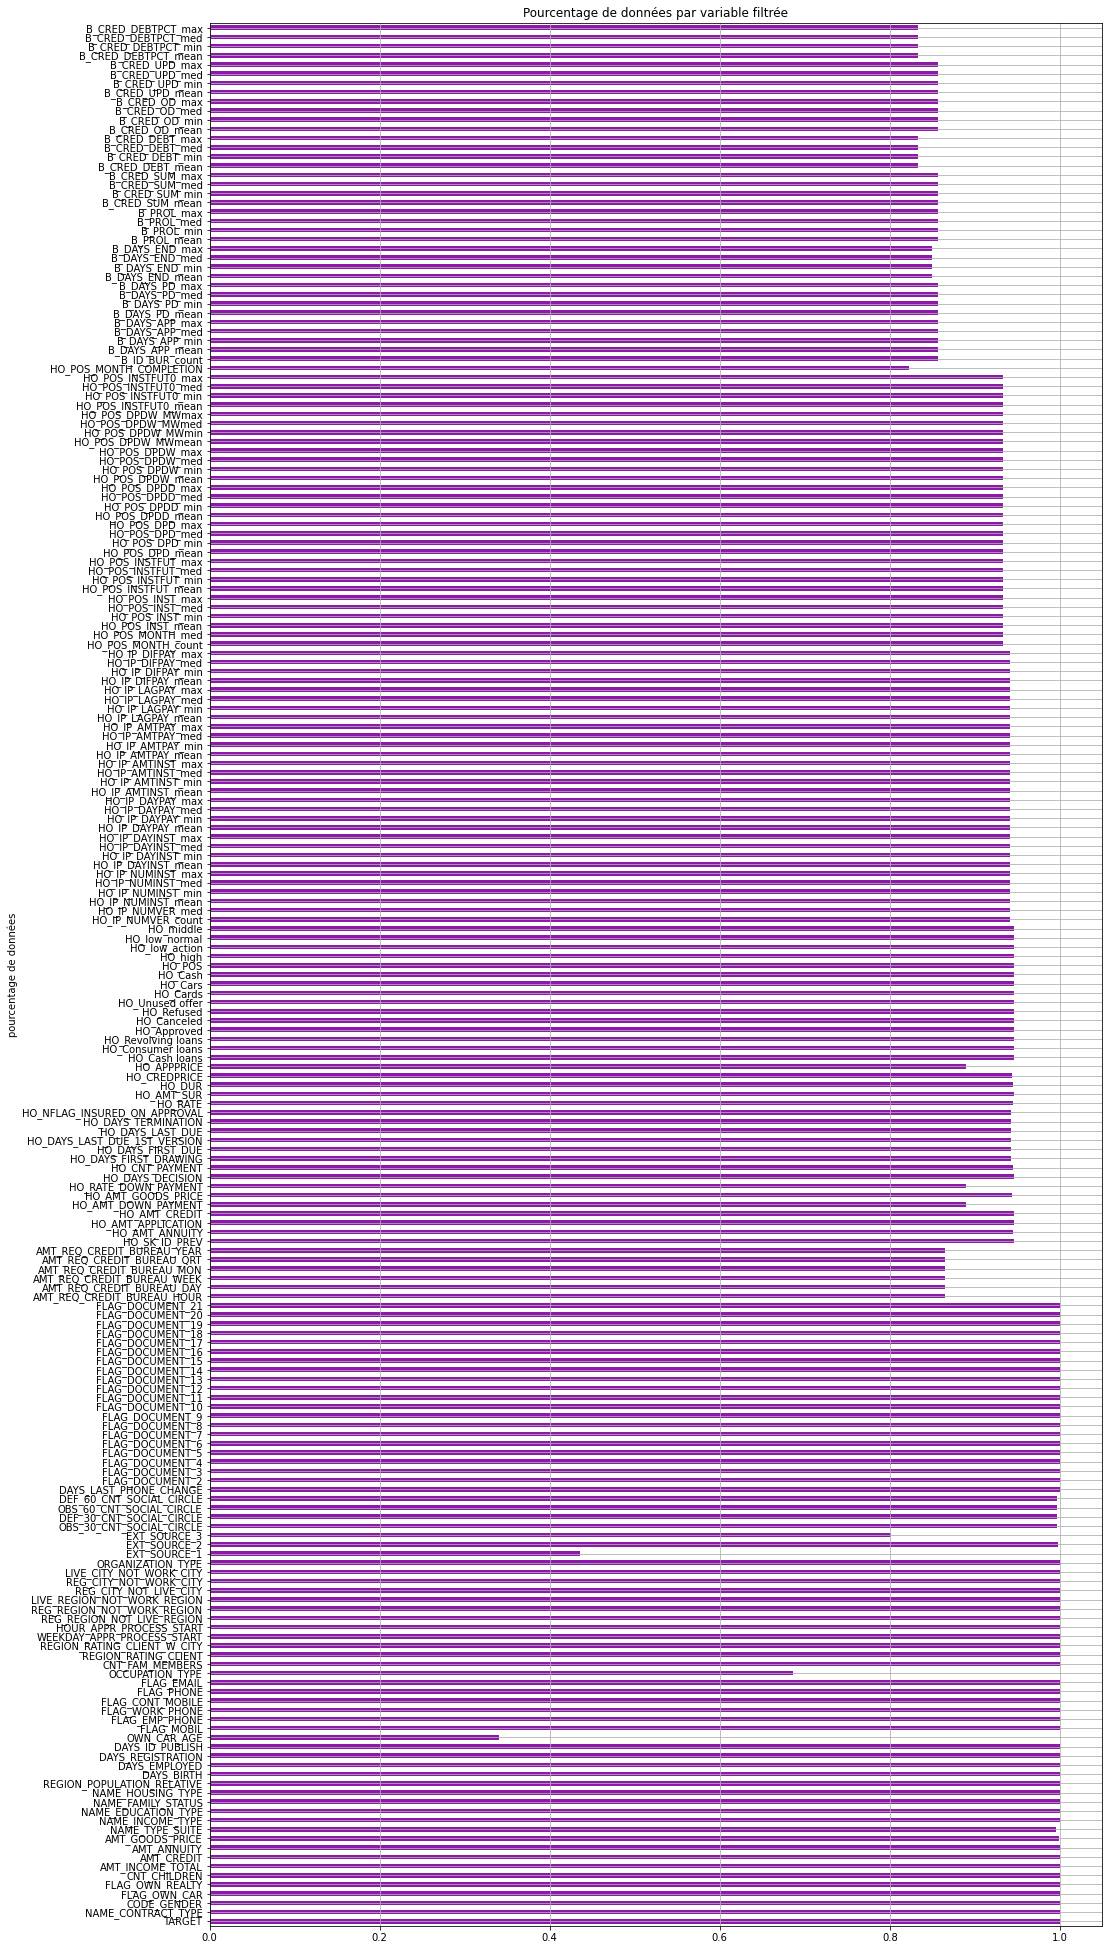

In [4]:
data=data#data_train
###################################################################
#on enleve les mode - medi - avg
lismedi=data.filter(regex='_MEDI',axis=1).columns.tolist()
lisavg=data.filter(regex='_AVG',axis=1).columns.tolist()
lismode=data.filter(regex='_MODE',axis=1).columns.tolist()
listorem=lismedi+lismode+lisavg

data=data.drop(columns=listorem)

#lisvar=data_train.columns.tolist()
#for elem in listorem:
#    lisvar.remove(elem)

datanull1=1-(data.isnull().sum()/data.shape[0])

#################################################
#on drop les trop courts on met 80% mais on peut mieux faire avec du temps
lisnocut=['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1','OCCUPATION_TYPE','OWN_CAR_AGE','TARGET']
glis=[]
for i in datanull1.index:
    if (datanull1[i]<=0.8) & (not i in lisnocut):
        glis=glis+[i]
        
data=data.drop(columns=glis)
#################################################

datanull1=1-(data.isnull().sum()/data.shape[0])
plt.figure(figsize=(16,35))
ax = datanull1.plot.barh( color="#8d19a9",title='Pourcentage de données par variable filtrée', xlabel='pourcentage de données')
ax.grid(zorder=0)
plt.show()


In [6]:
#pd.set_option('max_rows', None)
#pd.set_option('max_columns', None)
display(data.dtypes.sort_values())
statdes=data.describe()
display(statdes)
#pd.set_option('max_rows', 10)
#pd.set_option('max_columns', 10)
###############################################
data2=data.copy()
###############################################
#on passe en année les jours
data2['Y_BIRTH']=-data2['DAYS_BIRTH']/365.25
data2['Y_EMPLOYED']=-data2['DAYS_EMPLOYED']/365.25
data2['Y_REGISTRATION']=-data2['DAYS_REGISTRATION']/365.25
data2['Y_ID_PUBLISH']=-data2['DAYS_ID_PUBLISH']/365.25
data2['Y_LAST_PHONE_CHANGE']=-data2['DAYS_LAST_PHONE_CHANGE']/365.25


#on garde les duréees cohérentes et positives
nbrow=data2.shape[0]
data2=data2.loc[data2['Y_BIRTH']>=18,:]
print(nbrow-data2.shape[0],' lignes supprimées pour Y_BIRTH>18')
nbrow=data2.shape[0]
data2=data2.loc[data2['Y_EMPLOYED']>=0,:]
print(nbrow-data2.shape[0],' lignes supprimées pour Y_EMPLOYED>0')
nbrow=data2.shape[0]
data2=data2.loc[data2['Y_REGISTRATION']>=0,:]
print(nbrow-data2.shape[0],' lignes supprimées pour Y_REGISTRATION>0')
nbrow=data2.shape[0]
data2=data2.loc[data2['Y_ID_PUBLISH']>=0,:]
print(nbrow-data2.shape[0],' lignes supprimées pour Y_ID_PUBLISH>0')
nbrow=data2.shape[0]
data2=data2.loc[data2['Y_ID_PUBLISH']>=0,:]
print(nbrow-data2.shape[0],' lignes supprimées pour Y_ID_PUBLISH>0')
nbrow=data2.shape[0]
data2=data2.loc[data2['Y_LAST_PHONE_CHANGE']>=0,:]
print(nbrow-data2.shape[0],' lignes supprimées pour Y_LAST_PHONE_CHANGE>0')

#bon sens

nbrow=data2.shape[0]
data2=data2.loc[(data2.Y_BIRTH>data2.Y_EMPLOYED+16),:]
print(nbrow-data2.shape[0],"lignes supprimées pour cause d'age > duree d emploi + 16 ans")
nbrow=data2.shape[0]
data2=data2.loc[(data2.Y_BIRTH>data2.Y_REGISTRATION),:]
print(nbrow-data2.shape[0],"lignes supprimées pour cause d'age > registration")
nbrow=data2.shape[0]
data2=data2.loc[(data2.Y_BIRTH>data2.Y_ID_PUBLISH),:]
print(nbrow-data2.shape[0],"lignes supprimées pour cause d'age > id publish")
###############################################
#bon sens sur les credits
nbrow=data2.shape[0]
data2=data2.loc[(data2.AMT_CREDIT>=data2.AMT_ANNUITY),:]
#le credit peut etre superieur au prix du bien , travaux oblige
#data2=data2.loc[(data2.AMT_GOODS_PRICE>=data2.AMT_CREDIT),:]
print(nbrow-data2.shape[0],"lignes supprimées pour cause d'annuité > credit")
###############################################

def light_iqr_up(data2in,statin,varin,seuilman,seuil=0):
    #attention le seuil est calculé avant pour ne pas etre sensible à la reduction du nombre d'obs des variables precedentes
    nbrow=data2in.shape[0]
    cutup=statin.loc['50%',varin]+1.5*(statin.loc['75%',varin]-statin.loc['25%',varin])
    if seuilman==False:
        data2out=data2in.loc[(data2in[varin]<cutup),:]
        print(nbrow-data2out.shape[0],' lignes supprimées sur iqr ',varin,' -> il reste ',data2out.shape[0],' lignes')
    elif seuilman==True:
        data2out=data2in.loc[(data2in[varin]<seuil),:]
        print(nbrow-data2out.shape[0],' lignes supprimées sur seuil ',varin,' -> il reste ',data2out.shape[0],' lignes')
    return data2out

#data2=light_iqr_up(data2,statdes,'CNT_CHILDREN',seuilman=True,seuil=10)# on met un seuil arbitraire à 10 enfants mais bon pas d'uen grande utilité
data2=light_iqr_up(data2,statdes,'AMT_INCOME_TOTAL',seuilman=True,seuil=1E6)#seuil manuel à 1 million
#data2=light_iqr_up(data2,statdes,'AMT_CREDIT',seuilman=False)
#data2=light_iqr_up(data2,statdes,'AMT_ANNUITY',seuilman=False)
#data2=light_iqr_up(data2,statdes,'AMT_GOODS_PRICE',seuilman=False)
#data2=light_iqr_up(data2,statdes,'REGION_POPULATION_RELATIVE',seuilman=False)

#attention sur les voitures l'age semble avoir un impact mais attention aux voitures de collections
#features engineering a faire
#data2=light_iqr_up(data2,statdes,'OWN_CAR_AGE',seuilman=True,seuil=75)
#data2=light_iqr_up(data2,statdes,'CNT_FAM_MEMBERS',seuilman=True,seuil=11) # on met un seuil arbitraire à 11
#data2=light_iqr_up(data2,statdes,'OBS_30_CNT_SOCIAL_CIRCLE',seuilman=True,seuil=40) # on met un seuil arbitraire
#data2=light_iqr_up(data2,statdes,'OBS_60_CNT_SOCIAL_CIRCLE',seuilman=True,seuil=40)
#data2=light_iqr_up(data2,statdes,'AMT_REQ_CREDIT_BUREAU_QRT',seuilman=True,seuil=40)

data2=data2.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE'])
statdes2=data2.describe()
pd.set_option('max_columns', None)
display(statdes2)
pd.set_option('max_columns', 10)

0  lignes supprimées pour Y_BIRTH>18
55378  lignes supprimées pour Y_EMPLOYED>0
0  lignes supprimées pour Y_REGISTRATION>0
0  lignes supprimées pour Y_ID_PUBLISH>0
0  lignes supprimées pour Y_ID_PUBLISH>0
1  lignes supprimées pour Y_LAST_PHONE_CHANGE>0
0 lignes supprimées pour cause d'age > duree d emploi + 16 ans
894 lignes supprimées pour cause d'age > registration
0 lignes supprimées pour cause d'age > id publish
12 lignes supprimées pour cause d'annuité > credit
240  lignes supprimées sur seuil  AMT_INCOME_TOTAL  -> il reste  250994  lignes


C:\anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count  250994.000000  250994.000000     250994.000000  2.509940e+05   
mean        0.086564       0.498992     174113.128480  6.114726e+05   
std         0.281195       0.763616      91316.998706  4.060241e+05   
min         0.000000       0.000000      25650.000000  4.500000e+04   
25%         0.000000       0.000000     112500.000000  2.779695e+05   
50%         0.000000       0.000000     157500.000000  5.212800e+05   
75%         0.000000       1.000000     211500.000000  8.295840e+05   
max         1.000000      19.000000     990000.000000  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  250994.000000     2.507400e+05               250994.000000   
mean    27798.628372     5.494194e+05                    0.020897   
std     14553.662291     3.727061e+05                    0.013867   
min      1980.000000     4.050000e+04                    0.000290   
25%     17077.500000     2.475000e+05                    0.010006   
50%     25839.000000     4.500000e+05                    0.018850   
75%     35617.500000     6.930000e+05                    0.028663   
max    258025.500000     4.050000e+06                    0.072508   

        OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
count  93970.000000    250994.0   250994.000000    250994.000000   
mean      11.954432         1.0        0.999952         0.243054   
std       11.975439         0.0        0.006914         0.428928   
min        0.000000         1.0        0.000000         0.000000   
25%        5.000000         1.0        1.000000         0.000000   
50%        9.000000         1.0        1.000000         0.000000   
75%       15.000000         1.0        1.000000         0.000000   
max       91.000000         1.0        1.000000         1.000000   

       FLAG_CONT_MOBILE     FLAG_PHONE     FLAG_EMAIL  CNT_FAM_MEMBERS  \
count     250994.000000  250994.000000  250994.000000    250992.000000   
mean           0.997900       0.277780       0.063376         2.253578   
std            0.045774       0.447905       0.243639         0.942052   
min            0.000000       0.000000       0.000000         1.000000   
25%            1.000000       0.000000       0.000000         2.000000   
50%            1.000000       0.000000       0.000000         2.000000   
75%            1.000000       1.000000       0.000000         3.000000   
max            1.000000       1.000000       1.000000        20.000000   

       REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count         250994.000000                250994.000000   
mean               2.044973                     2.023638   
std                0.512405                     0.506455   
min                1.000000                     1.000000   
25%                2.000000                     2.000000   
50%                2.000000                     2.000000   
75%                2.000000                     2.000000   
max                3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            250994.000000               250994.000000   
mean                 12.200614                    0.017156   
std                   3.299956                    0.129852   
min                   0.000000                    0.000000   
25%                  10.000000                    0.000000   
50%                  12.000000                    0.000000   
75%                  15.000000                    0.000000   
max                  23.000000                    1.000000   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
count               250994.000000                250994.000000   
mean                     0.061719                     0.049459   
std                      0.240644                     0.216826   
min                      0.000000                     0.000000   
25%                      0.000000         

In [8]:
# a ne plus faire
#cut NA
lisnum=data2.columns.to_list()
lisnocut=['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1','OCCUPATION_TYPE','OWN_CAR_AGE','TARGET']
data3=data2.copy()
#for i in lisnum:
#    if not i in lisnocut:
        #data3=data3.loc[data3[i].notnull(),:]
        
#datanull=1-(data3.isnull().sum()/data3.shape[0])
#plt.figure(figsize=(16,15))
#ax = datanull.plot.barh( color="#8d19a9",title='Pourcentage de données par variable filtrée', xlabel='pourcentage de données')
#ax.grid(zorder=0)
#plt.show()

### données categorielles
* a ce stade 12 variables catégorielles
    * gender a 3 modalités , c'est une de trop, verifions les modalités
    * NAME_CONTRACT_TYPE (0/1 cash/revolving) ,CODE_GENDER (0/1 F/M),FLAG_OWN_CAR (0/1 N/Y),FLAG_OWN_REALTY (0/1 N/Y) n'ont que 2 modalités et puevent etre codées en label encoder pour devenir quantitatives 0/1
    
    * apres label encodage, il reste 8 variables categorielles qualitatives à plus de 2 modalités

* concernant les quantitatives: on a 33 booleens binaires comme TARGET et les flag
    en general les YES cont codés en 1
    * FLAG_MOBIL et FLAG_DOC_2 n'ont qu'une modalité et ne sont donc d'aucune utilité
    * Par ailleurs en dehors du FLAG_DOC_3 et 8, le 1 est tellement peu représenté dans les FLAG_DOC qu'il serait dangereux de les utiliser, REG_REGION_NOT_LIVE_REGION
    * le 0 est tellement peu représenté pour FLAG_CONT_MOBILE et FLAG_EMP_PHONE qu'il serait dangereux de les utiliser


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
dtype: int64

Cash loans         0.897727
Revolving loans    0.102273
Name: NAME_CONTRACT_TYPE, dtype: float64

F      0.623700
M      0.376284
XNA    0.000016
Name: CODE_GENDER, dtype: float64

N    0.625589
Y    0.374411
Name: FLAG_OWN_CAR, dtype: float64

Y    0.678921
N    0.321079
Name: FLAG_OWN_REALTY, dtype: float64

Unaccompanied      0.813007
Family             0.125692
Spouse, partner    0.038324
Children           0.008944
Other_B            0.005841
NaN                0.004331
Other_A            0.003000
Group of people    0.000861
Name: NAME_TYPE_SUITE, dtype: float64

Working                 0.629860
Commercial associate    0.283768
State servant           0.086205
Student                 0.000072
Pensioner               0.000040
Businessman             0.000036
Maternity leave         0.000020
Name: NAME_INCOME_TYPE, dtype: float64

Secondary / secondary special    0.687594
Higher education                 0.264285
Incomplete higher                0.038507
Lower secondary                  0.009064
Academic degree                  0.000550
Name: NAME_EDUCATION_TYPE, dtype: float64

Married                 0.650840
Single / not married    0.155139
Civil marriage          0.103736
Separated               0.063571
Widow                   0.026706
Unknown                 0.000008
Name: NAME_FAMILY_STATUS, dtype: float64

House / apartment      0.874989
With parents           0.057491
Municipal apartment    0.035909
Rented apartment       0.018506
Office apartment       0.009136
Co-op apartment        0.003968
Name: NAME_HOUSING_TYPE, dtype: float64

Laborers                 0.218969
NaN                      0.162709
Sales staff              0.127206
Core staff               0.109373
Managers                 0.084512
Drivers                  0.073874
High skill tech staff    0.045152
Accountants              0.038941
Medicine staff           0.033901
Security staff           0.026694
Cooking staff            0.023562
Cleaning staff           0.018498
Private service staff    0.010518
Low-skill Laborers       0.008299
Waiters/barmen staff     0.005319
Secretaries              0.005159
Realty agents            0.002984
HR staff                 0.002239
IT staff                 0.002088
Name: OCCUPATION_TYPE, dtype: float64

TUESDAY      0.174327
WEDNESDAY    0.167896
MONDAY       0.165052
THURSDAY     0.163323
FRIDAY       0.162187
SATURDAY     0.112305
SUNDAY       0.054910
Name: WEEKDAY_APPR_PROCESS_START, dtype: float64

Business Entity Type 3    0.269445
Self-employed             0.152378
Other                     0.066181
Medicine                  0.044459
Business Entity Type 2    0.041893
Government                0.041364
School                    0.035343
Trade: type 7             0.031076
Kindergarten              0.027331
Construction              0.026666
Business Entity Type 1    0.023710
Transport: type 4         0.021419
Trade: type 3             0.013765
Industry: type 9          0.013383
Industry: type 3          0.012992
Security                  0.012893
Housing                   0.011761
Industry: type 11         0.010705
Military                  0.010435
Bank                      0.009885
Agriculture               0.009745
Police                    0.009279
Transport: type 2         0.008733
Postal                    0.008562
Security Ministries       0.007845
Trade: type 2             0.007454
Restaurant                0.007183
Services                  0.006259
University          

SK_ID_CURR
100002         Cash loans
100003         Cash loans
100004    Revolving loans
100006         Cash loans
100007         Cash loans
               ...       
456248         Cash loans
456251         Cash loans
456253         Cash loans
456254         Cash loans
456255         Cash loans
Name: NAME_CONTRACT_TYPE, Length: 250990, dtype: object

SK_ID_CURR
100002    0
100003    0
100004    1
100006    0
100007    0
         ..
456248    0
456251    0
456253    0
456254    0
456255    0
Name: NAME_CONTRACT_TYPE, Length: 250990, dtype: int32

NAME_CONTRACT_TYPE


SK_ID_CURR
100002    M
100003    F
100004    M
100006    F
100007    M
         ..
456248    F
456251    M
456253    F
456254    F
456255    F
Name: CODE_GENDER, Length: 250990, dtype: object

SK_ID_CURR
100002    1
100003    0
100004    1
100006    0
100007    1
         ..
456248    0
456251    1
456253    0
456254    0
456255    0
Name: CODE_GENDER, Length: 250990, dtype: int32

CODE_GENDER


SK_ID_CURR
100002    N
100003    N
100004    Y
100006    N
100007    N
         ..
456248    N
456251    N
456253    N
456254    N
456255    N
Name: FLAG_OWN_CAR, Length: 250990, dtype: object

SK_ID_CURR
100002    0
100003    0
100004    1
100006    0
100007    0
         ..
456248    0
456251    0
456253    0
456254    0
456255    0
Name: FLAG_OWN_CAR, Length: 250990, dtype: int32

FLAG_OWN_CAR


SK_ID_CURR
100002    Y
100003    N
100004    Y
100006    Y
100007    Y
         ..
456248    Y
456251    N
456253    Y
456254    Y
456255    N
Name: FLAG_OWN_REALTY, Length: 250990, dtype: object

SK_ID_CURR
100002    1
100003    0
100004    1
100006    1
100007    1
         ..
456248    1
456251    0
456253    1
456254    1
456255    0
Name: FLAG_OWN_REALTY, Length: 250990, dtype: int32

FLAG_OWN_REALTY
4 columns were label encoded.


AMT_INCOME_TOTAL                  2203
AMT_CREDIT                        5321
AMT_ANNUITY                      13163
AMT_GOODS_PRICE                    893
REGION_POPULATION_RELATIVE          81
OWN_CAR_AGE                         59
CNT_FAM_MEMBERS                     17
EXT_SOURCE_1                    104184
EXT_SOURCE_2                    110283
EXT_SOURCE_3                       810
OBS_30_CNT_SOCIAL_CIRCLE            32
DEF_30_CNT_SOCIAL_CIRCLE             9
OBS_60_CNT_SOCIAL_CIRCLE            32
DEF_60_CNT_SOCIAL_CIRCLE             8
AMT_REQ_CREDIT_BUREAU_HOUR           5
AMT_REQ_CREDIT_BUREAU_DAY            8
AMT_REQ_CREDIT_BUREAU_WEEK           9
AMT_REQ_CREDIT_BUREAU_MON           23
AMT_REQ_CREDIT_BUREAU_QRT           11
AMT_REQ_CREDIT_BUREAU_YEAR          22
HO_SK_ID_PREV                   234327
HO_AMT_ANNUITY                  221046
HO_AMT_APPLICATION              162125
HO_AMT_CREDIT                   177695
HO_AMT_DOWN_PAYMENT              48434
HO_AMT_GOODS_PRICE       

TARGET                          2
CNT_CHILDREN                   15
FLAG_MOBIL                      1
FLAG_EMP_PHONE                  2
FLAG_WORK_PHONE                 2
FLAG_CONT_MOBILE                2
FLAG_PHONE                      2
FLAG_EMAIL                      2
REGION_RATING_CLIENT            3
REGION_RATING_CLIENT_W_CITY     3
HOUR_APPR_PROCESS_START        24
REG_REGION_NOT_LIVE_REGION      2
REG_REGION_NOT_WORK_REGION      2
LIVE_REGION_NOT_WORK_REGION     2
REG_CITY_NOT_LIVE_CITY          2
REG_CITY_NOT_WORK_CITY          2
LIVE_CITY_NOT_WORK_CITY         2
FLAG_DOCUMENT_2                 2
FLAG_DOCUMENT_3                 2
FLAG_DOCUMENT_4                 2
FLAG_DOCUMENT_5                 2
FLAG_DOCUMENT_6                 2
FLAG_DOCUMENT_7                 2
FLAG_DOCUMENT_8                 2
FLAG_DOCUMENT_9                 2
FLAG_DOCUMENT_10                2
FLAG_DOCUMENT_11                2
FLAG_DOCUMENT_12                2
FLAG_DOCUMENT_13                2
FLAG_DOCUMENT_

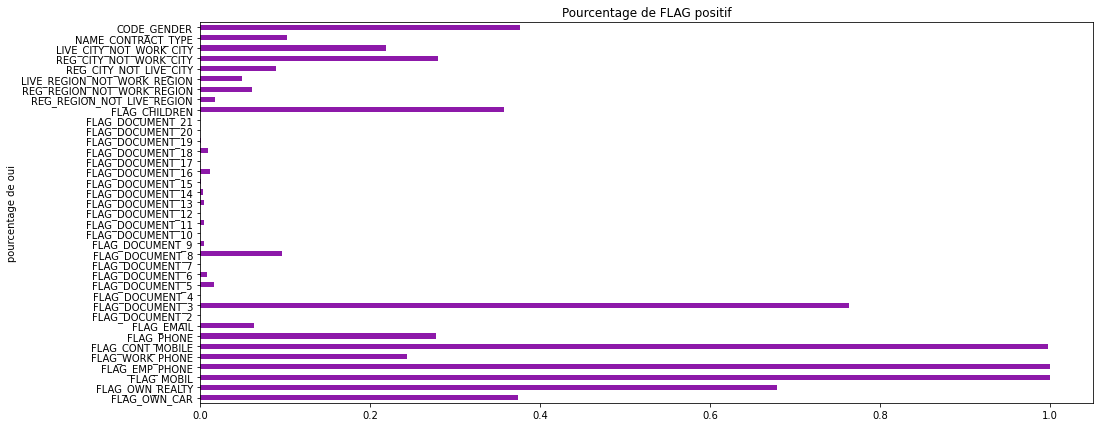

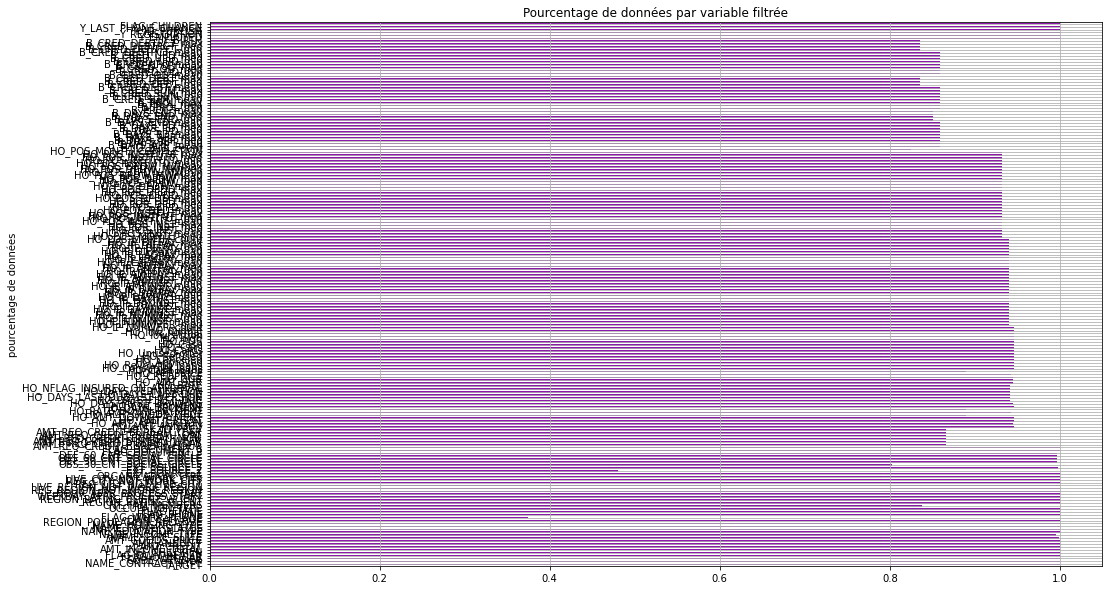

In [9]:
data4=data3.copy()

pd.set_option('max_rows', None)
#nombre de modalités par variable
display(data4.select_dtypes('object').apply(pd.Series.nunique, axis = 0))
pd.set_option('max_rows', 10)
for i in data4.select_dtypes('object').columns.to_list():
    pd.set_option('max_rows', None)
    display(data4[i].value_counts(dropna=False, normalize=True))
    pd.set_option('max_rows', 10)

######################on passe en other les faibles modalités
data4.loc[data4.NAME_TYPE_SUITE=='Children',['NAME_TYPE_SUITE']]='other_'
data4.loc[data4.NAME_TYPE_SUITE=='Other_B',['NAME_TYPE_SUITE']]='other_'
data4.loc[data4.NAME_TYPE_SUITE=='Other_A',['NAME_TYPE_SUITE']]='other_'
data4.loc[data4.NAME_TYPE_SUITE=='Group of people',['NAME_TYPE_SUITE']]='other_'

data4.loc[data4.NAME_INCOME_TYPE=='Student',['NAME_INCOME_TYPE']]='other_'
data4.loc[data4.NAME_INCOME_TYPE=='Pensioner',['NAME_INCOME_TYPE']]='other_'
data4.loc[data4.NAME_INCOME_TYPE=='Businessman',['NAME_INCOME_TYPE']]='other_'
data4.loc[data4.NAME_INCOME_TYPE=='Maternity leave',['NAME_INCOME_TYPE']]='other_'

data4.loc[data4.NAME_EDUCATION_TYPE=='Lower secondary',['NAME_EDUCATION_TYPE']]='other_'
data4.loc[data4.NAME_EDUCATION_TYPE=='Academic degree',['NAME_EDUCATION_TYPE']]='other_'

data4.loc[data4.NAME_HOUSING_TYPE=='Office apartment',['NAME_HOUSING_TYPE']]='other_'
data4.loc[data4.NAME_HOUSING_TYPE=='Co-op apartment',['NAME_HOUSING_TYPE']]='other_'

data4.loc[data4.OCCUPATION_TYPE=='Private service staff',['OCCUPATION_TYPE']]='other_'
data4.loc[data4.OCCUPATION_TYPE=='Low-skill Laborers',['OCCUPATION_TYPE']]='other_'
data4.loc[data4.OCCUPATION_TYPE=='Secretaries',['OCCUPATION_TYPE']]='other_'
data4.loc[data4.OCCUPATION_TYPE=='Waiters/barmen staff',['OCCUPATION_TYPE']]='other_'
data4.loc[data4.OCCUPATION_TYPE=='Realty agents',['OCCUPATION_TYPE']]='other_'
data4.loc[data4.OCCUPATION_TYPE=='HR staff',['OCCUPATION_TYPE']]='other_'
data4.loc[data4.OCCUPATION_TYPE=='IT staff',['OCCUPATION_TYPE']]='other_'

data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 9',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Trade: type 3',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 3',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Security',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Housing',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Military',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 11',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Bank',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Police',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Transport: type 2',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Agriculture',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Postal',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Security Ministries',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Trade: type 2',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Restaurant',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Services',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='University',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 7',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Transport: type 3',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 1',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Electricity',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Hotel',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 4',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Trade: type 6',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 5',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Insurance',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Emergency',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Telecom',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 2',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Advertising',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Realtor',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Culture',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 12',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Trade: type 1',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Mobile',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Legal Services',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Cleaning',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Transport: type 1',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 10',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 6',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Religion',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Trade: type 4',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 13',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Trade: type 5',['ORGANIZATION_TYPE']]='other_'
data4.loc[data4.ORGANIZATION_TYPE=='Industry: type 8',['ORGANIZATION_TYPE']]='other_'





########################
data4=data4.loc[data4.CODE_GENDER != 'XNA',:]

#onehotencoder pour les categories -> 1 colonne par modalité/categorie
#mieux que labelencoder qui donne un ordre / donc uniquement pour 2 modalités

from sklearn import preprocessing
# Create a label encoder object
le = preprocessing.LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data4:
    if data4[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data4[col].unique())) <= 2:
            # Train on the training data
            le.fit(data4[col])
            display(data4[col])
            data4[col] = le.transform(data4[col])
            display(data4[col])
            # Keep track of how many columns were label encoded
            le_count += 1
            print(col)
            
print('%d columns were label encoded.' % le_count)

####################################
#on peut rajouter une variable avec ou sans enfant
data4['FLAG_CHILDREN']=data4['CNT_CHILDREN']
data4.loc[data4['CNT_CHILDREN']>=1,['FLAG_CHILDREN']]=1
#####################################
pd.set_option('max_rows', None)
display(data4.select_dtypes('float64').apply(pd.Series.nunique, axis = 0))
display(data4.select_dtypes('int64').apply(pd.Series.nunique, axis = 0))
pd.set_option('max_rows', 10)

lisflag=data4.filter(regex='^FLAG',axis=1).columns.to_list()
lispseudoflag=['REG_REGION_NOT_LIVE_REGION',
'REG_REGION_NOT_WORK_REGION',
'LIVE_REGION_NOT_WORK_REGION',
'REG_CITY_NOT_LIVE_CITY',
'REG_CITY_NOT_WORK_CITY',
'LIVE_CITY_NOT_WORK_CITY']
lisnewflag=['NAME_CONTRACT_TYPE','CODE_GENDER']
lisflag=lisflag+lispseudoflag+lisnewflag

dataflag=(data4[lisflag]==1).sum()/data4[lisflag].shape[0]
plt.figure(figsize=(16,7))
ax = dataflag.plot.barh( color="#8d19a9",title='Pourcentage de FLAG positif', 
                                xlabel='pourcentage de oui')

lisdrop=data4.filter(regex='^FLAG',axis=1).columns.to_list()
lisdrop=lisdrop+['REG_REGION_NOT_LIVE_REGION']
lisdrop.remove('FLAG_DOCUMENT_3')
lisdrop.remove('FLAG_DOCUMENT_8')
lisdrop.remove('FLAG_WORK_PHONE')     
lisdrop.remove('FLAG_PHONE')     
lisdrop.remove('FLAG_EMAIL')
lisdrop.remove('FLAG_OWN_CAR')
lisdrop.remove('FLAG_OWN_REALTY')
lisdrop.remove('FLAG_CHILDREN')

data4=data4.drop(columns=lisdrop)

datanull=1-(data4.isnull().sum()/data4.shape[0])
plt.figure(figsize=(16,10))
ax = datanull.plot.barh( color="#8d19a9",title='Pourcentage de données par variable filtrée', xlabel='pourcentage de données')
ax.grid(zorder=0)
plt.show()

# 5) UNDERSAMPLING sur la variable TARGET
* Egalisation des classes par undersampling
* ca permet egalement de reduire le nombre d'observation volumineux et donc les temps de calculs de modelisation

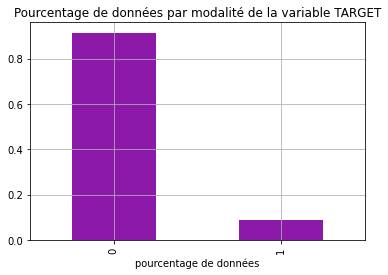

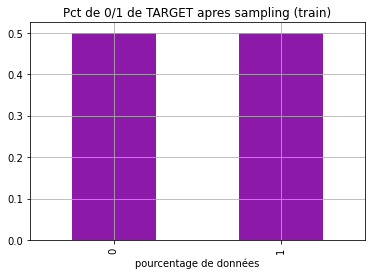

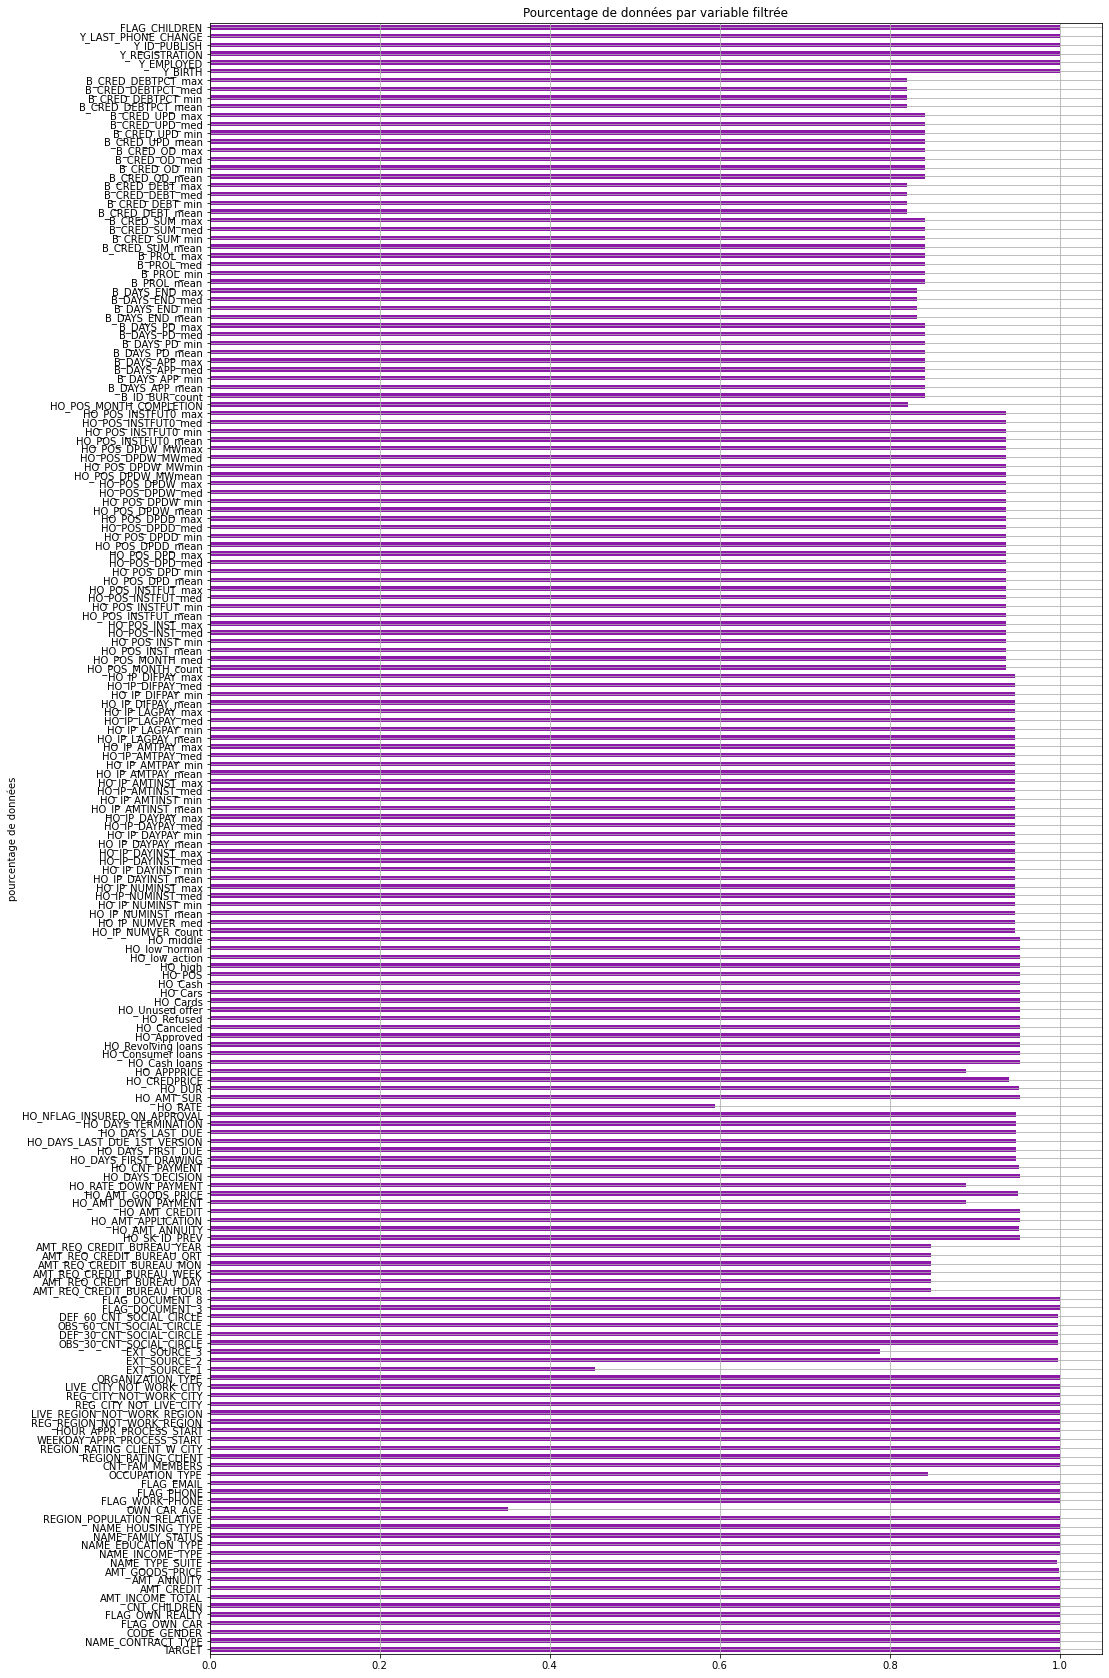

43454

In [10]:
#on enleve les -inf
data4.replace([np.inf, -np.inf], np.nan, inplace=True)


plt.figure(figsize=(6,4))
temp=data4.TARGET.value_counts(dropna=False)/data4.shape[0]
ax = temp.plot.bar(color="#8d19a9",title='Pourcentage de données par modalité de la variable TARGET', xlabel='pourcentage de données')
ax.grid(zorder=0)
plt.show()

#shuffling/melange
df=data4.sample(frac=1)
#undersampling ou oversampling au choix: l'undersampling nous permettra de reduire le nombre d'observations
df1=df.loc[df.TARGET==1,:]
df0=df.loc[df.TARGET==0,:]
    #cas oversampling
#df1=df1.sample(n=df0.shape[0],replace=True)
    #cas undersampling
size=df1.shape[0]
df2=df.loc[df.TARGET==0][:size]

#fusion
df3=pd.concat([df2,df1])
#shuffling 
df3=df3.sample(frac=1)


plt.figure(figsize=(6,4))
temp=df3.TARGET.value_counts(dropna=False)/df3.shape[0]
ax = temp.plot.bar(color="#8d19a9",title='Pct de 0/1 de TARGET apres sampling (train)', xlabel='pourcentage de données')
ax.grid(zorder=0)
plt.show()

datanull=1-(df3.isnull().sum()/df3.shape[0])
plt.figure(figsize=(16,30))
ax = datanull.plot.barh( color="#8d19a9",title='Pourcentage de données par variable filtrée', xlabel='pourcentage de données')
ax.grid(zorder=0)
plt.show()

df3.shape[0]

# 6) NOUVELLES VARIABLES DU FICHIER PRINCIPAL

In [11]:
##############################################################
#nouveaux facteurs quant

df4=df3.copy()

#SOLVABILITE
df4['SOLV1']=df4['AMT_INCOME_TOTAL']/df4['AMT_ANNUITY']
df4['SOLV2']=df4['AMT_INCOME_TOTAL']-df4['AMT_ANNUITY']
df4['SOLV3']=(df4['AMT_INCOME_TOTAL']-df4['AMT_ANNUITY'])/df4['AMT_INCOME_TOTAL']

#DUREE
df4['DURA1']=df4['AMT_CREDIT']/df4['AMT_ANNUITY']
df4['DURA2']=(df4['AMT_CREDIT']/df4['AMT_ANNUITY'])/df4['Y_BIRTH']
df4['DURA3']=(df4['AMT_CREDIT']/df4['AMT_ANNUITY'])/df4['Y_BIRTH']
df4['DURA4']=(df4['AMT_CREDIT']/df4['AMT_ANNUITY'])/(df4['Y_EMPLOYED']+5)
df4['DURA5']=(df4['AMT_CREDIT']/df4['AMT_ANNUITY'])/(df4['Y_EMPLOYED']+5)

#MIX MONTANT/AGE
df4['SPE1']=df4['AMT_CREDIT']/df4['Y_BIRTH']
df4['SPE2']=df4['AMT_ANNUITY']/df4['Y_BIRTH']
df4['SPE3']=df4['AMT_INCOME_TOTAL']/df4['Y_BIRTH']

df4['SPE4']=df4['AMT_CREDIT']/(df4['Y_EMPLOYED']+1)
df4['SPE5']=df4['AMT_ANNUITY']/(df4['Y_EMPLOYED']+1)
df4['SPE6']=df4['AMT_INCOME_TOTAL']/(df4['Y_EMPLOYED']+1)

#APPORT
df4['APPORT1']=df4['AMT_GOODS_PRICE']-df4['AMT_CREDIT']
df4['APPORT2']=(df4['AMT_GOODS_PRICE']-df4['AMT_CREDIT'])/df4['AMT_CREDIT']

#ANCIENNETE VS AGE
df4['WORKAGE1']=df4['Y_BIRTH']-df4['Y_EMPLOYED']
df4['WORKAGE2']=df4['Y_EMPLOYED']/df4['Y_BIRTH']

# 7) MODELISATION

In [20]:
#preselection de variables
lisselT=['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_WORK_PHONE',
'FLAG_PHONE','FLAG_EMAIL','FLAG_DOCUMENT_3','FLAG_DOCUMENT_8',
'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
'OCCUPATION_TYPE','ORGANIZATION_TYPE','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
'DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','EXT_SOURCE_3','EXT_SOURCE_2',
'EXT_SOURCE_1','Y_EMPLOYED','Y_BIRTH','TARGET','AMT_CREDIT']

lisselNVT=['SOLV1','SOLV2','SOLV3','DURA1','DURA2','DURA3','DURA4','DURA5',
          'SPE1','SPE2','SPE3','SPE4','SPE5','SPE6','APPORT1','APPORT2','WORKAGE1','WORKAGE2']

lisselNVHO=df4.filter(regex='^HO_',axis=1).columns.tolist()
lisselNVB=df4.filter(regex='^B_',axis=1).columns.tolist()

liscat=['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE']

lissel=lisselT+lisselNVT+lisselNVHO+lisselNVB
#on place AMT_CREDIT à la premiere colonne/ ca nous servira pour le scoring perso
df4=df4.loc[:,lissel]
first_column = df4.pop('AMT_CREDIT')
df4.insert(0, 'AMT_CREDIT', first_column)
  

pd.set_option('max_columns', None)
display(df4)

#separation train test
ytrain=df4.TARGET
Xtrain=df4.drop(columns='TARGET')

            #le stratify permet de garder la meme proportion de classes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.33, stratify=ytrain)

AMT_CREDIT  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
SK_ID_CURR                                                               
251998     1,350,000.00                   0            0             0   
378754       382,500.00                   0            1             0   
405590       183,384.00                   0            0             1   
385473     1,467,612.00                   0            0             0   
351700       314,055.00                   0            1             1   
...                 ...                 ...          ...           ...   
406998       539,230.50                   0            1             0   
315717       360,000.00                   0            1             1   
257338       254,700.00                   0            0             0   
328093       916,470.00                   0            1             0   
375667       166,500.00                   0            0             0   

            FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
251998                    0           1           0                0   
378754                    1           1           0                1   
405590                    0           0           0                1   
385473                    0           0           0                1   
351700                    1           1           0                1   
...                     ...         ...         ...              ...   
406998                    0           0           0                1   
315717                    0           1           0                1   
257338                    1           1           1                1   
328093                    1           0           0                0   
375667                    0           0           0                1   

            FLAG_DOCUMENT_8      NAME_INCOME_TYPE  \
SK_ID_CURR                                          
251998                    0               Working   
378754                    0               Working   
405590                    0               Working   
385473                    0               Working   
351700                    0               Working   
...                     ...                   ...   
406998                    0               Working   
315717                    0               Working   
257338                    0               Working   
328093                    0  Commercial associate   
375667                    0               Working   

                      NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
SK_ID_CURR                                                        
251998      Secondary / secondary special               Married   
378754      Secondary / secondary special               Married   
405590      Secondary / secondary special               Married   
385473                   Higher education               Married   
351700                   Higher education               Married   
...                                   ...                   ...   
406998      Secondary / secondary special  Single / not married   
315717      Secondary / secondary special               Married   
257338      Secondary / secondary special               Married   
328093      Secondary / secondary special  Single / not married   
375667      Secondary / secondary special               Married   

            NAME_HOUSING_TYPE OCCUPATION_TYPE       ORGANIZATION_TYPE  \
SK_ID_CURR                                                              
251998      House / apartment  Cleaning staff  Business Entity Type 3   
378754      House / apartment        Laborers           Self-employed   
405590      House / apartment     Sales staff           Self-employed   
385473      House / apartment     Sales staff  Business Entity Type 3   
351700      House / apartment         Drivers                  other_   
...                       ...           

## 7) a) PREPROCESSING

In [21]:

#on reset les index
X_train=X_train.reset_index()#.drop(columns='index')
X_test=X_test.reset_index()#.drop(columns='index')
y_train=y_train.reset_index()#.drop(columns='index')
y_test=y_test.reset_index()#.drop(columns='index')

#one hot encoder pour les variables catgorielles
#attention pour le one hot encoder il faut specifier les categories sinon ca encode meme les numeriques continues
#doit on retire une colonne par cat à ce stade ou attendre?
#doit on laisser les vides dans une categorie NA ou tenter un imputer?

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train.loc[:,liscat])

X_train2=pd.DataFrame(enc.transform(X_train.loc[:,liscat]).toarray())
X_test2=pd.DataFrame(enc.transform(X_test.loc[:,liscat]).toarray())
X_train2.columns = enc.get_feature_names()
X_test2.columns=X_train2.columns

#on fusionne
display(X_train)
X_train = pd.concat([X_train.drop(columns=liscat), X_train2], axis=1)
X_test = pd.concat([X_test.drop(columns=liscat), X_test2], axis=1)

#on remplace par NA du x4_nan du 'OCCUPATION_TYPE' (principale catgégories avec des valeurs manquantes) , les flag NA
lisx4=X_train.filter(regex='^x4',axis=1).columns.to_list()
lisx4.remove('x4_nan')
X_train.loc[X_train.x4_nan==1,lisx4]=np.nan
X_test.loc[X_test.x4_nan==1,lisx4]=np.nan

X_train=X_train.drop(columns='x4_nan')
X_test=X_test.drop(columns='x4_nan')

#Tansformation MINMAX scaler du jeu pour standardiser les données
#on utlise MINMAX car bcp de 0 et de 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train2=pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test2=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

#KNN imputer
import timeit
start = timeit.default_timer()

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputer.fit(X_train2)

X_train=pd.DataFrame(imputer.transform(X_train2),columns=X_train2.columns)
stop1 = timeit.default_timer()
print('Time: ', stop1 - start)

X_test=pd.DataFrame(imputer.transform(X_test2),columns=X_test2.columns)
stop2 = timeit.default_timer()
print('Time: ', stop2 - start)

pd.set_option('max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
display(X_train)

############## on rembove le sother_ categorielles
todrop=X_train.filter(regex='other_$',axis=1).columns
X_train=X_train.drop(columns=todrop)
X_test=X_test.drop(columns=todrop)

C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


SK_ID_CURR   AMT_CREDIT  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0          212566 1,345,500.00                   0            0             0   
1          149442   254,700.00                   0            0             0   
2          220341   679,500.00                   0            0             0   
3          263095   545,040.00                   0            0             0   
4          377375   729,792.00                   0            0             1   
...           ...          ...                 ...          ...           ...   
29109      310182   450,000.00                   0            0             1   
29110      230549   824,823.00                   0            0             0   
29111      403135    94,810.50                   0            0             0   
29112      330980   269,550.00                   0            1             1   
29113      446400   490,536.00                   0            0             0   

       FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  FLAG_DOCUMENT_3  \
0                    1           1           0                1   
1                    0           0           0                1   
2                    1           1           0                1   
3                    0           1           0                1   
4                    0           0           0                1   
...                ...         ...         ...              ...   
29109                0           0           0                1   
29110                0           0           1                1   
29111                0           0           0                1   
29112                0           0           0                1   
29113                1           1           0                1   

       FLAG_DOCUMENT_8      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0                    0               Working  Secondary / secondary special   
1                    0               Working               Higher education   
2                    0               Working  Secondary / secondary special   
3                    0               Working  Secondary / secondary special   
4                    0  Commercial associate  Secondary / secondary special   
...                ...                   ...                            ...   
29109                0  Commercial associate  Secondary / secondary special   
29110                0         State servant               Higher education   
29111                0               Working  Secondary / secondary special   
29112                0               Working               Higher education   
29113                0               Working  Secondary / secondary special   

         NAME_FAMILY_STATUS    NAME_HOUSING_TYPE OCCUPATION_TYPE  \
0                   Married    House / apartment             NaN   
1                   Married    House / apartment     Sales staff   
2                   Married    House / apartment        Managers   
3                   Married    House / apartment  Medicine staff   
4            Civil marriage  Municipal apartment   Cooking staff   
...                     ...                  ...             ...   
29109               Married    House / apartment   Cooking staff   
29110               Married         With parents             NaN   
29111                 Widow    House / apartment     Sales staff   
29112  Single / not married     Rented apartment          other_   
29113               Married    House / apartment     Sales staff   

            ORGANIZATION_TYPE  REGION_RATING_CLIENT  \
0                      School                     2   
1      Business Entity Type 3                     2   
2               Self-employed                     2   
3                      other_                     2   
4                Kindergarten                     2   
...                       ...                   ...   
29109  Business Entity Type 3                     2   
29110                Me

Time:  418.7923373000001
Time:  632.7271818000002


SK_ID_CURR  AMT_CREDIT  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0            0.32        0.33                0.00         0.00          0.00   
1            0.14        0.05                0.00         0.00          0.00   
2            0.34        0.16                0.00         0.00          0.00   
3            0.46        0.13                0.00         0.00          0.00   
4            0.78        0.17                0.00         0.00          1.00   
...           ...         ...                 ...          ...           ...   
29109        0.59        0.10                0.00         0.00          1.00   
29110        0.37        0.20                0.00         0.00          0.00   
29111        0.85        0.01                0.00         0.00          0.00   
29112        0.65        0.06                0.00         1.00          1.00   
29113        0.97        0.11                0.00         0.00          0.00   

       FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  FLAG_DOCUMENT_3  \
0                 1.00        1.00        0.00             1.00   
1                 0.00        0.00        0.00             1.00   
2                 1.00        1.00        0.00             1.00   
3                 0.00        1.00        0.00             1.00   
4                 0.00        0.00        0.00             1.00   
...                ...         ...         ...              ...   
29109             0.00        0.00        0.00             1.00   
29110             0.00        0.00        1.00             1.00   
29111             0.00        0.00        0.00             1.00   
29112             0.00        0.00        0.00             1.00   
29113             1.00        1.00        0.00             1.00   

       FLAG_DOCUMENT_8  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                 0.00                  0.50                         0.00   
1                 0.00                  0.50                         0.50   
2                 0.00                  0.50                         0.50   
3                 0.00                  0.50                         0.50   
4                 0.00                  0.50                         0.50   
...                ...                   ...                          ...   
29109             0.00                  0.50                         0.50   
29110             0.00                  0.50                         0.50   
29111             0.00                  1.00                         1.00   
29112             0.00                  0.50                         0.50   
29113             0.00                  0.50                         0.50   

       DEF_30_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  EXT_SOURCE_3  \
0                          0.00                      0.00          0.38   
1                          0.00                      0.00          0.64   
2                          0.00                      0.00          0.62   
3                          0.00                      0.00          0.42   
4                          0.12                      0.17          0.13   
...                         ...                       ...           ...   
29109                      0.25                      0.33          0.47   
29110                      0.00                      0.00          0.85   
29111                      0.00                      0.00          0.58   
29112                      0.00                      0.00          0.47   
29113                      0.00                      0.00          0.43   

       EXT_SOURCE_2  EXT_SOURCE_1  Y_EMPLOYED  Y_BIRTH  SOLV1  SOLV2  SOLV3  \
0              0.63          0.53        0.26     0.73   0.02   0.09   0.71   
1              0.03          0.40        0.09     0.36   0.05   0.10   0.86   
2              0.83          0.76        0.32     0.49   0.07   0.18   0.90   
3              0.67          0.59        0.11     0.84   0.06   0.20   0.87   
4              0.22 

In [22]:
X_train=X_train.drop(columns=['SK_ID_CURR'])
X_test=X_test.drop(columns=['SK_ID_CURR'])
y_test=y_test.drop(columns=['SK_ID_CURR'])
y_train=y_train.drop(columns=['SK_ID_CURR'])

In [26]:
X_train2=X_train.copy()
X_test2=X_test.copy()

In [27]:
lisdro=lisselNVT+lisselNVHO+lisselNVB
X_train=X_train2.drop(columns=lisdro)
X_test=X_test2.drop(columns=lisdro)
#faire 2 jeux le light et le non light

### *sauvegarde fichiers de modelisation*

In [147]:
X_train.to_csv('input/Projet/X_train.csv', sep = ',')
X_train2.to_csv('input/Projet/X_train2.csv', sep = ',')
X_test.to_csv('input/Projet/X_test.csv', sep = ',')
X_test2.to_csv('input/Projet/X_test2.csv', sep = ',')
y_train.to_csv('input/Projet/y_train.csv', sep = ',')
y_test.to_csv('input/Projet/y_test.csv', sep = ',')

### *rechargement fichiers de modélisation si besoin*

In [ ]:
X_train=pd.read_csv('input/Projet/X_train.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
X_train2=pd.read_csv('input/Projet/X_train2.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
X_test=pd.read_csv('input/Projet/X_test.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
X_test2=pd.read_csv('input/Projet/X_test2.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
y_train=pd.read_csv('input/Projet/y_train.csv', delimiter = ',',error_bad_lines=False,low_memory=False)
y_test=pd.read_csv('input/Projet/y_test.csv', delimiter = ',',error_bad_lines=False,low_memory=False)

## 7) b) FONCTION DE SCORING 

In [28]:
#au max la banque gagne les negatifs rééls * les interets : TN+FP pondérés par les interets
#au min la banque perd les positifs reels * les defauts : TP+FN pondérés par les credits
#par rapport au max atteignable , la banque va perdre le cout des FN ponderes par les defauts + cout des FP pondérés par les interets
#on cherche donc a maximiser les revenus de la banque ce qui nous donne:
#l'indicateur suivant à minimiser , normalisé entre 0 et 1
# [(TNi+FPi)-(FNc+FPi)]/((TNi+FPi)+(TPc+FNc))
# (TNi+FNc)/((TNi+FPi)+(TPc+FNc))
# ou l'indicateur suivant à maximiser , normalisé entre 0 et 1
# 1- [(TNi+FNc)/((TNi+FPi)+(TPc+FNc))]
# (FPi+TPc)/((TNi+FPi)+(TPc+FNc))
# on rajoute un parametre de prise de risque (si le modele ne predit que des 1: il prend zero risque à l'inverse de que des 0)
# [(FPi+TPc)/((TNi+FPi)+(TPc+FNc))]*(1-PP/N)
#on a bsoin de FPi TNi TPc FNc
import math
def my_custom_score1(y, y_pred, X_amt=None, rate=0.02):
    #probleme comment passer le X_AMT
    #attention les y arrivent en -1 et +1 au lieu de 0 et 1
    #prediction
    a=y_pred
    print(y_pred)
    #aleatoire
    #a=np.random.randint(2, size=a.shape[0])
    #realité
    b=y
    print(y)
    #.T.to_numpy().ravel()
    #credit
            #c=X_amt.AMT_CREDIT.T.to_numpy().ravel()
    c=np.linspace(1,1,b.shape[0])
    #taux
    d=np.linspace(rate,rate,b.shape[0])
    #colonne pour les interets
    e=np.linspace(0,0,b.shape[0])
    #concat des colonnes
    combined=np.vstack((a, b, c, d, e)).T
    #calucl des interest
    combined[:,4]=combined[:,2]*combined[:,3]
    print(combined[:,4])

    
    # un peu complexe
    # suivant les algo les splits se font en -1 et 1 , parfois 0 et 1
    combTN=combined[np.where(np.logical_and(combined[:,0]==0,combined[:,1]==0))]
    combTP=combined[np.where(np.logical_and(combined[:,0]==1,combined[:,1]==1))]
    combFN=combined[np.where(np.logical_and(combined[:,0]==0,combined[:,1]==1))]
    combFP=combined[np.where(np.logical_and(combined[:,0]==1,combined[:,1]==0))]

    FPi=np.sum(combFP[:,4])
    TNi=np.sum(combTN[:,4])
    TPc=np.sum(combTP[:,2])
    FNc=np.sum(combFN[:,2])

    score=(FPi+TPc)/((TNi+FPi)+(TPc+FNc))
    #petite securite : par exemple si L1 trop fort dans l elastic, on peut sortir zero coeff donc mettre à 0 
    if score==1:
        score=0
    print(score)
    print('max à gagner',TNi+FPi,'avec pourcentage de negatifs reels',(combTN.shape[0]+combFP.shape[0])/combined.shape[0])
    print('max à perdre',TPc+FNc,'avec pourcentage de positifs reels',(combTP.shape[0]+combFN.shape[0])/combined.shape[0])
    print('cout à perdre sur le max atteignable',FPi+FNc)
    print('pourcentage de faux positifs / negatifs reels --- moins couteux',combFP.shape[0]/(combTN.shape[0]+combFP.shape[0]))
    print('pourcentage de faux negatifs / positifs reels --- plus couteux',combFN.shape[0]/(combTP.shape[0]+combFN.shape[0]))
    return score

from sklearn.metrics import make_scorer
myscore=make_scorer(my_custom_score1,greater_is_better=True)
#attention avec make_scorer on est dans un format (y,ypred) donc limité

from sklearn import metrics

########################################################################
#realiser une fonction plus flexible avec un format (estimator, X, y)
def my_custom_score2(clf, X, y, rate=0.02):
    pd.options.display.float_format = '{:,.2f}'.format
    #probleme comment passer le X_AMT
    #attention les y arrivent en -1 et +1 au lieu de 0 et 1
    #prediction
    a = clf.predict(X)
    #aprob=clf.predict_proba(X)
    
    #aleatoire
    #a=np.random.randint(2, size=a.shape[0])
    #realité
    b=y
    #.T.to_numpy().ravel()
    #credit en premiere place de X
            #c=X_amt.AMT_CREDIT.T.to_numpy().ravel()
    c=X[:,0]
    #taux
    d=np.linspace(rate,rate,b.shape[0])
    #colonne pour les interets
    e=np.linspace(0,0,b.shape[0])
    #concat des colonnes
    combined=np.vstack((a, b, c, d, e)).T
    #calucl des interest
    combined[:,4]=combined[:,2]*combined[:,3]
    #print(combined[:,4])

    # un peu complexe
    # suivant les algo les splits se font en -1 et 1 , parfois 0 et 1
    #petite transfo d'usage
    combined[np.where(combined[:,0]==-1)]=0
    combined[np.where(combined[:,1]==-1)]=0
    
    
    
    combTN=combined[np.where(np.logical_and(combined[:,0]==0,combined[:,1]==0))]
    combTP=combined[np.where(np.logical_and(combined[:,0]==1,combined[:,1]==1))]
    combFN=combined[np.where(np.logical_and(combined[:,0]==0,combined[:,1]==1))]
    combFP=combined[np.where(np.logical_and(combined[:,0]==1,combined[:,1]==0))]

    FPi=np.sum(combFP[:,4])
    TNi=np.sum(combTN[:,4])
    TPc=np.sum(combTP[:,2])
    FNc=np.sum(combFN[:,2])
    
    #positif predit
    PP=np.sum(combTP[:,0])+np.sum(combFP[:,0])

    score=math.sqrt(((FPi+TPc)/(TNi+FPi+TPc+FNc))*(1-2*abs(0.5-PP/a.shape[0])))
    #petite securite : par exemple si L1 trop fort dans l elastic, on peut sortir zero coeff donc mettre à 0 
    if score==1:
        score=0
    #print("{:.3f}".format(score),"{:.3f}".format(FPi+TPc),"{:.3f}".format(TNi+FPi+TPc+FNc))
    #print('score',"{:.3f}".format(score),'FP/N',"{:.2f}".format(combFP.shape[0]/(combTN.shape[0]+combFP.shape[0])),'FN/P',"{:.2f}".format(combFN.shape[0]/(combTP.shape[0]+combFN.shape[0])))
    #print('max à gagner',TNi+FPi,'avec pourcentage de negatifs reels',(combTN.shape[0]+combFP.shape[0])/combined.shape[0])
    #print('max à perdre',TPc+FNc,'avec pourcentage de positifs reels',(combTP.shape[0]+combFN.shape[0])/combined.shape[0])
    #print('cout à perdre sur le max atteignable',FPi+FNc)
    #print('pourcentage de faux positifs / negatifs reels --- moins couteux',combFP.shape[0]/(combTN.shape[0]+combFP.shape[0]))
    #print('pourcentage de faux negatifs / positifs reels --- plus couteux',combFN.shape[0]/(combTP.shape[0]+combFN.shape[0]))
    #metrics.top_k_accuracy_score #pour le mutliclasses
    #metrics.ndcg_score(y_true, y_score, *, k=None, sample_weight=None, ignore_ties=False) #pour multi ordre
    return {'own_score': score,
            'acc_score': metrics.accuracy_score(b, a),
            'bacc_score': metrics.balanced_accuracy_score(b, a), #moyenne du recall sur chaque classe
            'recall':metrics.recall_score(b, a),
            'precision':metrics.precision_score(b, a),
            'jac_score':metrics.jaccard_score(b, a),
            'fb0_5_score':metrics.fbeta_score(b, a,beta=0.5), #<1 plus de precision / >1 plus de recall
            'fb1_score':metrics.fbeta_score(b, a,beta=1),
            'fb2_score':metrics.fbeta_score(b, a,beta=2)}

#'f1_score':sklearn.metrics.f1_score(b, a),
#'brier_score':sklearn.metrics.brier_score_loss(b, aprob), #difference moyenne entre proba predit et realité parfait pour du binary
#'auc_score':metrics.roc_auc_score(b, aprob)

from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)

def my_custom_score_light(clf, X, y, rate=0.02):
    pd.options.display.float_format = '{:,.2f}'.format
    #probleme comment passer le X_AMT
    #attention les y arrivent en -1 et +1 au lieu de 0 et 1
    #prediction
    a = clf.predict(X)
    
    
    #aleatoire
    #a=np.random.randint(2, size=a.shape[0])
    #realité
    b=y
    #.T.to_numpy().ravel()
    #credit en premiere place de X
            #c=X_amt.AMT_CREDIT.T.to_numpy().ravel()
    c=X[:,0]
    #taux
    d=np.linspace(rate,rate,b.shape[0])
    #colonne pour les interets
    e=np.linspace(0,0,b.shape[0])
    #concat des colonnes
    combined=np.vstack((a, b, c, d, e)).T
    #calucl des interest
    combined[:,4]=combined[:,2]*combined[:,3]
    #print(combined[:,4])

    # un peu complexe
    # suivant les algo les splits se font en -1 et 1 , parfois 0 et 1
    #petite transfo d'usage
    combined[np.where(combined[:,0]==-1)]=0
    combined[np.where(combined[:,1]==-1)]=0
    
    combTN=combined[np.where(np.logical_and(combined[:,0]==0,combined[:,1]==0))]
    combTP=combined[np.where(np.logical_and(combined[:,0]==1,combined[:,1]==1))]
    combFN=combined[np.where(np.logical_and(combined[:,0]==0,combined[:,1]==1))]
    combFP=combined[np.where(np.logical_and(combined[:,0]==1,combined[:,1]==0))]

    FPi=np.sum(combFP[:,4])
    TNi=np.sum(combTN[:,4])
    TPc=np.sum(combTP[:,2])
    FNc=np.sum(combFN[:,2])

    score=(FPi+TPc)/(TNi+FPi+TPc+FNc)
    #petite securite : par exemple si L1 trop fort dans l elastic, on peut sortir zero coeff donc mettre à 0 
    if score==1:
        score=0
    #print("{:.3f}".format(score),"{:.3f}".format(FPi+TPc),"{:.3f}".format(TNi+FPi+TPc+FNc))
    #print('score',"{:.3f}".format(score),'FP/N',"{:.2f}".format(combFP.shape[0]/(combTN.shape[0]+combFP.shape[0])),'FN/P',"{:.2f}".format(combFN.shape[0]/(combTP.shape[0]+combFN.shape[0])))
    #print('max à gagner',TNi+FPi,'avec pourcentage de negatifs reels',(combTN.shape[0]+combFP.shape[0])/combined.shape[0])
    #print('max à perdre',TPc+FNc,'avec pourcentage de positifs reels',(combTP.shape[0]+combFN.shape[0])/combined.shape[0])
    #print('cout à perdre sur le max atteignable',FPi+FNc)
    #print('pourcentage de faux positifs / negatifs reels --- moins couteux',combFP.shape[0]/(combTN.shape[0]+combFP.shape[0]))
    #print('pourcentage de faux negatifs / positifs reels --- plus couteux',combFN.shape[0]/(combTP.shape[0]+combFN.shape[0]))
    #metrics.top_k_accuracy_score #pour le mutliclasses
    #metrics.ndcg_score(y_true, y_score, *, k=None, sample_weight=None, ignore_ties=False) #pour multi ordre
    return score

## 7) c) LOGISTIC REGRESSION

roc auc: 0.6913792914024548


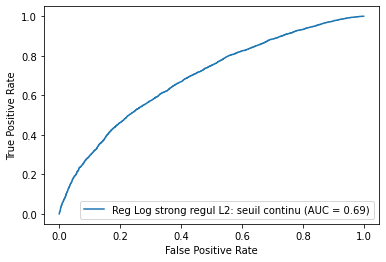

              precision    recall  f1-score   support

           0       0.64      0.60      0.62      5912
           1       0.63      0.67      0.65      5912

    accuracy                           0.63     11824
   macro avg       0.64      0.63      0.63     11824
weighted avg       0.64      0.63      0.63     11824



In [118]:
#enlever 1 colonnes par categories pour eviter la colinearité

from sklearn.linear_model import LogisticRegression
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001) #forte régularisation

# Train on the training data
    #.values transforme en array et .ravel transpose cet array, ca doit etre du np
log_reg.fit(X_train, y_train.values.ravel())
y_pred=log_reg.predict(X_test)
y_pred_prob=log_reg.predict_proba(X_test)[:,1]
#print(log_reg.score(X_test, y_test))


#les différentes metrics
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test, y_pred))

import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc=metrics.auc(fpr, tpr)
print('roc auc:',roc_auc)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Reg Log strong regul L2: seuil continu')
display.plot()
plt.show()

print(metrics.classification_report(y_test, y_pred))

#les coefficients
import seaborn as sns
from IPython.display import display
cm = sns.light_palette('purple', as_cmap=True)
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('max_rows', None)
display(pd.DataFrame(log_reg.coef_,columns=X_train.columns).T.style.background_gradient(cm).format('{:,.2f}'))
pd.set_option('max_rows', 10)


## 7) d) GRIDSEARCH CV LOGISTIC REGRESSION

In [67]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

    #penalty: on tente l'elasticnet => forcement solver 'saga'
    #scoring : par defaut, c est de l'accuracy mais on peut mieux faire:https://scikit-learn.org/stable/modules/model_evaluation.html
    #max_iter et tol=0.0001 : peut etre à adapter
    #n_jobs=-1 pour utiliser tous les cores CPU
    #refit : true si on refit sur les meilleurs ou false si on moyenne le smeilleurs de chaque fold


############################################################################################
#régularization
    #force de la régularization de 10e-4 à 10e+4
n_Cs = 20
Cs = np.logspace(-3, 4, n_Cs)

#mix de L1 à L2
n_l1_ratios = 10
l1_ratios=np.linspace(0, 1, num=n_l1_ratios)

#initialisation du classifieur
grid = dict()
grid['C'] = Cs
grid['l1_ratio'] = l1_ratios
grid['penalty']=['elasticnet']
grid['dual']=[False]
grid['solver']=['saga']
grid['tol']=[0.001]
grid['max_iter']=[500]
#grid={'n_estimators': np.arange(10,130,10), 'learning_rate': np.arange(0.01,1.1,0.25)}

clf_LR = GridSearchCV(estimator=LogisticRegression(),
                   param_grid=grid,
                   scoring=my_custom_score2,n_jobs=-1,
                   cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1),
                   refit='own_score',
                   verbose=3)
#scoring=my_custom_score2,n_jobs=-1,
#fit
start = time.time()
clf_LR.fit(X_train.to_numpy(), y_train.values.ravel())
end = time.time()
print(f"Runtime of the program is {end - start}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Runtime of the program is 181.28406310081482


meilleur estimateur LogisticRegression(C=2.069138081114788, l1_ratio=1.0, max_iter=500,
                   penalty='elasticnet', solver='saga', tol=0.001)
best score 0.79
best param {'C': 2.069138081114788, 'dual': False, 'l1_ratio': 1.0, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.001}
score prediction 0.79
roc auc: 0.74


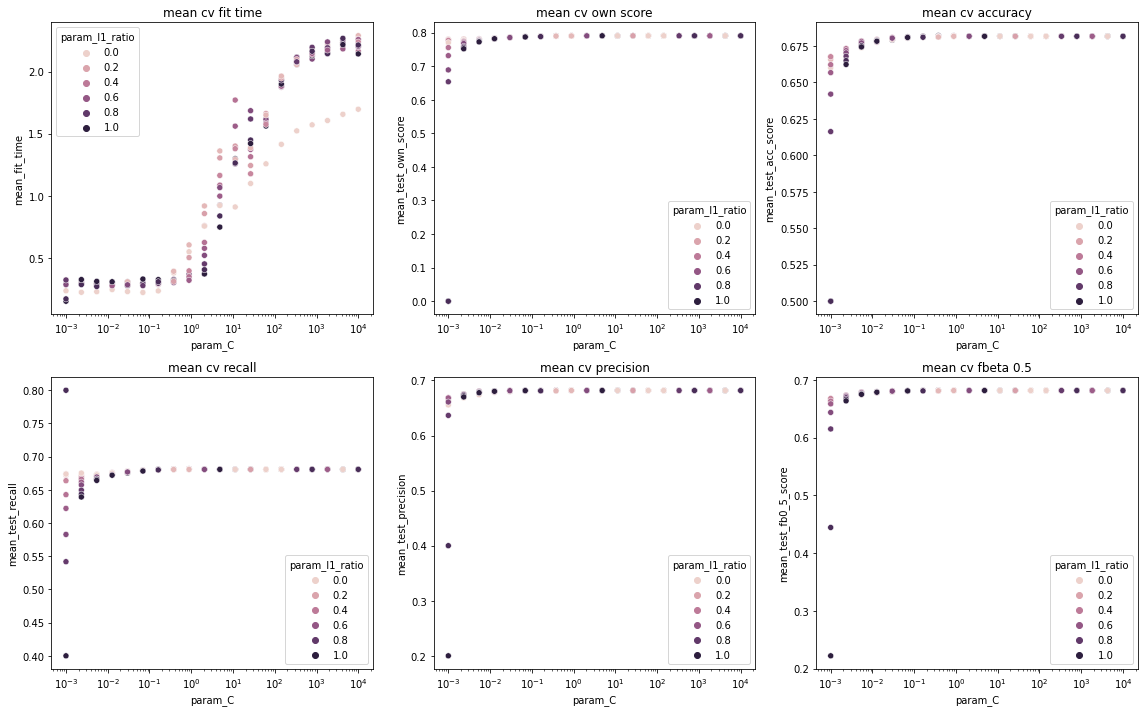

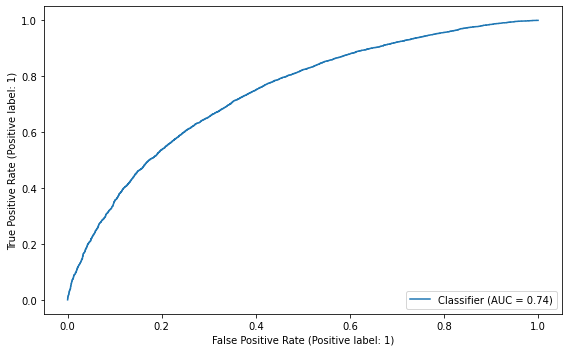

              precision    recall  f1-score   support

           0       0.68      0.67      0.68      7170
           1       0.68      0.68      0.68      7170

    accuracy                           0.68     14340
   macro avg       0.68      0.68      0.68     14340
weighted avg       0.68      0.68      0.68     14340



In [68]:
#resultats du gridsearchCV
clf_LR.cv_results_.keys()
res_LR=pd.DataFrame(clf_LR.cv_results_).sort_values(by='rank_test_own_score')
print('meilleur estimateur',clf_LR.best_estimator_)
print('best score',"{:.2f}".format(clf_LR.best_score_))
print('best param',clf_LR.best_params_)

#prediction
y_pred=clf_LR.predict(X_test.to_numpy())
y_pred_prob=clf_LR.predict_proba(X_test.to_numpy())[:,1]
score_pred=clf_LR.score(X_test.to_numpy(),y_test.values.ravel())
print('score prediction',"{:.2f}".format(score_pred))


#les différentes metrics
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test, y_pred))

import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc=metrics.auc(fpr, tpr)
print('roc auc:',"{:.2f}".format(roc_auc))

#display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='adaboost: seuil continu')
#display.plot()
#plt.show()

###################################
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["figure.autolayout"] = True

#plt.figure(figsize=(16,15))
plt.figure(figsize=(16,10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)


sns.scatterplot(data=res_LR, x="param_C", y="mean_fit_time", hue='param_l1_ratio', ax=ax1)
sns.scatterplot(data=res_LR, x="param_C", y="mean_test_own_score", hue='param_l1_ratio',ax=ax2)
sns.scatterplot(data=res_LR, x="param_C", y="mean_test_acc_score", hue='param_l1_ratio',ax=ax3)
sns.scatterplot(data=res_LR, x="param_C", y="mean_test_recall", hue='param_l1_ratio',ax=ax4)
sns.scatterplot(data=res_LR, x="param_C", y="mean_test_precision", hue='param_l1_ratio',ax=ax5)
sns.scatterplot(data=res_LR, x="param_C", y="mean_test_fb0_5_score", hue='param_l1_ratio',ax=ax6)


ax1.title.set_text('mean cv fit time')
ax1.set(xscale="log")
ax2.title.set_text('mean cv own score')
ax2.set(xscale="log")
ax3.title.set_text('mean cv accuracy')
ax3.set(xscale="log")
ax4.title.set_text('mean cv recall')
ax4.set(xscale="log")
ax5.title.set_text('mean cv precision')
ax5.set(xscale="log")
ax6.title.set_text('mean cv fbeta 0.5')
ax6.set(xscale="log")



plt.show()
###################################

plt.rcParams["figure.figsize"] = [8, 5]
metrics.RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.show()
print(metrics.classification_report(y_test, y_pred))



In [69]:
#sauvegarde de modele
#alternative: from sklearn.externals import joblib
import pickle
# Save to file in the current working directory
pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_LR_1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf_LR, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
 #   pickle_model = pickle.load(file)

## 7) e) GRIDSEARCHCV ADABOOST

In [70]:
#https://www.youtube.com/watch?v=LsK-xG1cLYA
#adaboost (adaptative) : sequence de stumps (souche) -> 2 feuilles seulemnt par souche par opposition aux arbres
#dans une foret aleatoire : chaque arbe a un droit de vote egal sur la classification finale
    #et les arbres sont construits de facon independante
#dans adaboost: foret de souches: droit de vote inegal
    #et les souches ont une influence sur les prochaines
    #gini index (lower is better)=> permet de determiner la premiere souche
    #total erreur d'une souche=somme des poids d'obs associés à des erreurs de classification (toujours entre 0 et 1)
    #poids de la souche dans le vote=0.5log[(1-TE)/TE] ; TE=total erreur (sorte de logistique verticale)
    #poids obs mal classe next=poids obs *e^(poids souche)
    #poids obs bien classe next=poids obs *e^-(poids souche)
    #puis normaliser à 1
    #on peut utiliser un weighted gini index pour choisir la prochaine souche
        #on peut egalement reecchantilloner aleatoirement : les poids allant de 0 à 1 , un decoupage uniforme permettra de tirer plusieurs fois les obs surpondérés
    #sequentiel
#moins enclin a l overfitting
#https://medium.com/@chaudhurysrijani/tuning-of-adaboost-with-computational-complexity-8727d01a9d20


from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

#initialisation du classifieur
grid = dict()
grid['n_estimators'] = [10, 30, 50, 100, 150, 200] #[100]
grid['learning_rate'] = [0.001, 0.01, 0.1,0.2, 0.5, 1] #[0.5,1]
#grid={'n_estimators': np.arange(10,130,10), 'learning_rate': np.arange(0.01,1.1,0.25)}

clf_AD = GridSearchCV(estimator=AdaBoostClassifier(),
                   param_grid=grid,
                   scoring=my_custom_score2,n_jobs=-1,
                   cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1),
                   refit='own_score')
#scoring=my_custom_score2,n_jobs=-1,
#fit
start = time.time()
clf_AD.fit(X_train.to_numpy(), y_train.values.ravel())
end = time.time()
print(f"Runtime of the program is {end - start}")

Runtime of the program is 448.2838921546936


meilleur estimateur AdaBoostClassifier(learning_rate=0.5, n_estimators=100)
best score 0.79
best param {'learning_rate': 0.5, 'n_estimators': 100}
score prediction 0.79
roc auc: 0.74


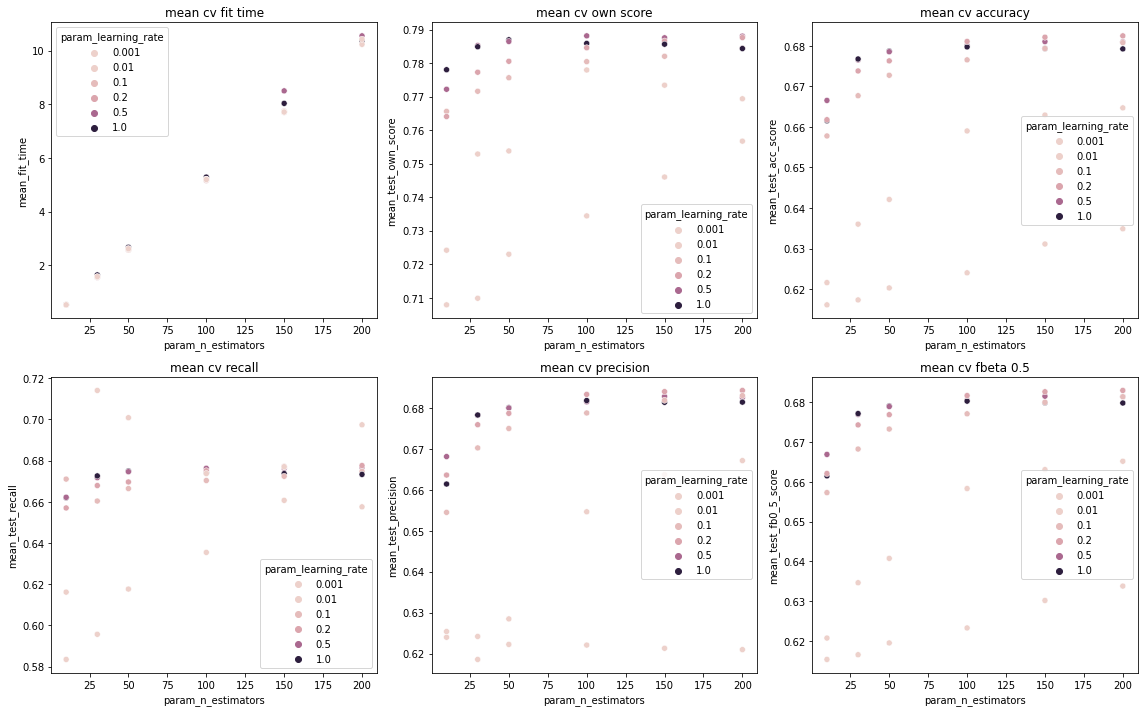

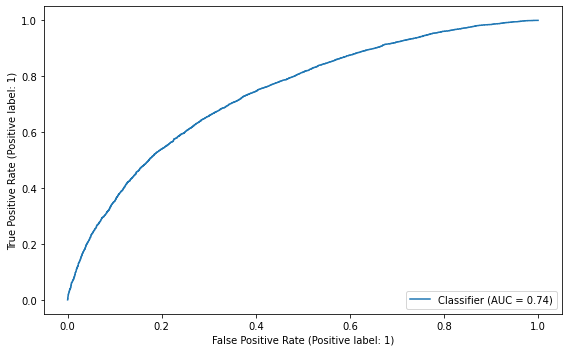

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      7170
           1       0.68      0.68      0.68      7170

    accuracy                           0.68     14340
   macro avg       0.68      0.68      0.68     14340
weighted avg       0.68      0.68      0.68     14340



In [71]:
#resultats du gridsearchCV
clf_AD.cv_results_.keys()
res_AD=pd.DataFrame(clf_AD.cv_results_).sort_values(by='rank_test_own_score')
print('meilleur estimateur',clf_AD.best_estimator_)
print('best score',"{:.2f}".format(clf_AD.best_score_))
print('best param',clf_AD.best_params_)

#import seaborn as sns
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_test_score", hue='param_learning_rate')
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_fit_time", hue='param_learning_rate')

#prediction
y_pred=clf_AD.predict(X_test.to_numpy())
y_pred_prob=clf_AD.predict_proba(X_test.to_numpy())[:,1]
score_pred=clf_AD.score(X_test.to_numpy(),y_test.values.ravel())
print('score prediction',"{:.2f}".format(score_pred))

#les différentes metrics
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test, y_pred))

import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc=metrics.auc(fpr, tpr)
print('roc auc:',"{:.2f}".format(roc_auc))

###################################
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["figure.autolayout"] = True

#plt.figure(figsize=(16,15))
plt.figure(figsize=(16,10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)


sns.scatterplot(data=res_AD, x="param_n_estimators", y="mean_fit_time", hue='param_learning_rate', ax=ax1)
sns.scatterplot(data=res_AD, x="param_n_estimators", y="mean_test_own_score", hue='param_learning_rate',ax=ax2)
sns.scatterplot(data=res_AD, x="param_n_estimators", y="mean_test_acc_score", hue='param_learning_rate',ax=ax3)
sns.scatterplot(data=res_AD, x="param_n_estimators", y="mean_test_recall", hue='param_learning_rate',ax=ax4)
sns.scatterplot(data=res_AD, x="param_n_estimators", y="mean_test_precision", hue='param_learning_rate',ax=ax5)
sns.scatterplot(data=res_AD, x="param_n_estimators", y="mean_test_fb0_5_score", hue='param_learning_rate',ax=ax6)


ax1.title.set_text('mean cv fit time')
#ax1.set(xscale="log")
ax2.title.set_text('mean cv own score')
#ax2.set(xscale="log")
ax3.title.set_text('mean cv accuracy')
#ax3.set(xscale="log")
ax4.title.set_text('mean cv recall')
#ax4.set(xscale="log")
ax5.title.set_text('mean cv precision')
#ax5.set(xscale="log")
ax6.title.set_text('mean cv fbeta 0.5')
#ax6.set(xscale="log")



plt.show()
###################################

plt.rcParams["figure.figsize"] = [8, 5]
metrics.RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.show()
print(metrics.classification_report(y_test, y_pred))

In [72]:
#sauvegarde de modele
#alternative: from sklearn.externals import joblib
import pickle
# Save to file in the current working directory
pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_AD_1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf_AD, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
 #   pickle_model = pickle.load(file)

## 7) f) GRIDSEARCHCV LINEAR SVC

In [73]:
#Linear SVM classifier
#Similar to SVC with parameter kernel=’linear
#should scale better to large numbers of samples

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

#initialisation du classifieur
#https://github.com/scikit-learn/scikit-learn/issues/17339
grid = dict()
grid['tol'] = [1e-4] #[100]
grid['C'] = [0.0001, 0.001, 0.01, 0.1, 0.1, 1, 10, 100] #[0.5,1]
#grid={'n_estimators': np.arange(10,130,10), 'learning_rate': np.arange(0.01,1.1,0.25)}

clf_LSVC = GridSearchCV(estimator=LinearSVC(),
                   param_grid=grid,
                   scoring=my_custom_score2,n_jobs=-1,
                   cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1),
                   error_score='raise',
                   refit='own_score')
#scoring=my_custom_score2,n_jobs=-1,
#fit
start = time.time()
clf_LSVC.fit(X_train.to_numpy(), y_train.values.ravel())
end = time.time()
print(f"Runtime of the program is {end - start}")

Runtime of the program is 36.79801321029663


meilleur estimateur LinearSVC(C=1)
best score 0.79
best param {'C': 1, 'tol': 0.0001}
score prediction 0.79
roc auc: 0.68


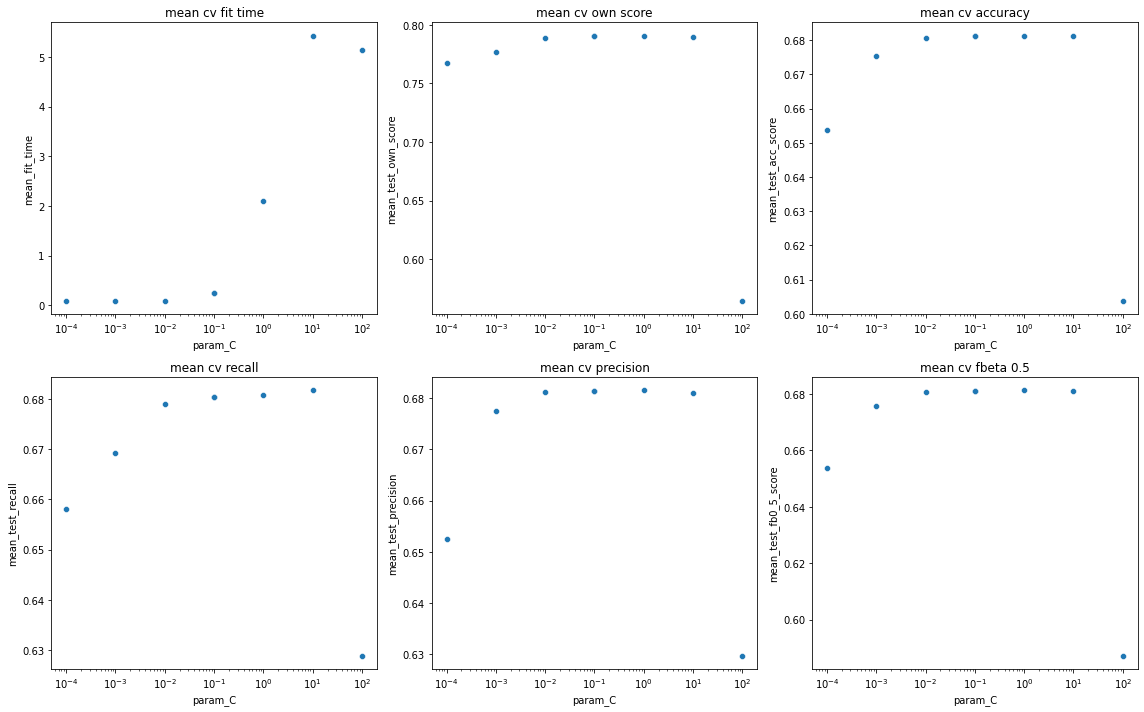

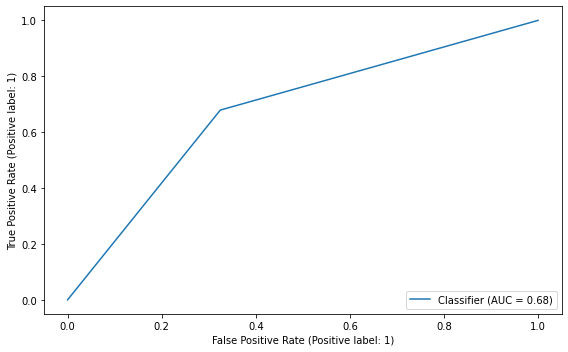

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      7170
           1       0.68      0.68      0.68      7170

    accuracy                           0.68     14340
   macro avg       0.68      0.68      0.68     14340
weighted avg       0.68      0.68      0.68     14340



In [74]:
#resultats du gridsearchCV
clf_LSVC.cv_results_.keys()
res_LSVC=pd.DataFrame(clf_LSVC.cv_results_).sort_values(by='rank_test_own_score')
print('meilleur estimateur',clf_LSVC.best_estimator_)
print('best score',"{:.2f}".format(clf_LSVC.best_score_))
print('best param',clf_LSVC.best_params_)

#import seaborn as sns
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_test_score", hue='param_learning_rate')
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_fit_time", hue='param_learning_rate')

#prediction
y_pred=clf_LSVC.predict(X_test.to_numpy())
#y_pred_prob=clf_LSVC.predict_proba(X_test.to_numpy())[:,1]
score_pred=clf_LSVC.score(X_test.to_numpy(),y_test.values.ravel())
print('score prediction',"{:.2f}".format(score_pred))

#les différentes metrics
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test, y_pred))

import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc=metrics.auc(fpr, tpr)
print('roc auc:',"{:.2f}".format(roc_auc))

#display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='adaboost: seuil continu')
#display.plot()
#plt.show()

###################################
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["figure.autolayout"] = True

#plt.figure(figsize=(16,15))
plt.figure(figsize=(16,10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)


sns.scatterplot(data=res_LSVC, x="param_C", y="mean_fit_time", ax=ax1)
sns.scatterplot(data=res_LSVC, x="param_C", y="mean_test_own_score",ax=ax2)
sns.scatterplot(data=res_LSVC, x="param_C", y="mean_test_acc_score",ax=ax3)
sns.scatterplot(data=res_LSVC, x="param_C", y="mean_test_recall",ax=ax4)
sns.scatterplot(data=res_LSVC, x="param_C", y="mean_test_precision",ax=ax5)
sns.scatterplot(data=res_LSVC, x="param_C", y="mean_test_fb0_5_score",ax=ax6)


ax1.title.set_text('mean cv fit time')
ax1.set(xscale="log")
ax2.title.set_text('mean cv own score')
ax2.set(xscale="log")
ax3.title.set_text('mean cv accuracy')
ax3.set(xscale="log")
ax4.title.set_text('mean cv recall')
ax4.set(xscale="log")
ax5.title.set_text('mean cv precision')
ax5.set(xscale="log")
ax6.title.set_text('mean cv fbeta 0.5')
ax6.set(xscale="log")

plt.show()

###################################

plt.rcParams["figure.figsize"] = [8, 5]
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print(metrics.classification_report(y_test, y_pred))

#les coefficients"
#import seaborn as sns
#from IPython.display import display
#cm = sns.light_palette('purple', as_cmap=True)
#pd.options.display.float_format = '{:,.2f}'.format
#pd.set_option('max_rows', None)
#display(pd.DataFrame(clf.feature_importances_,index=X_train.columns).style.background_gradient(cm).format('{:,.2f}'))
#pd.set_option('max_rows', 10)

In [75]:
#sauvegarde de modele
#alternative: from sklearn.externals import joblib
import pickle
# Save to file in the current working directory
pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_LSVC_1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf_LSVC, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
 #   pickle_model = pickle.load(file)

## 7) g) GRIDSEARCHCV SVC KERNEL

In [194]:
#SVM classifier
#ne convient pas aux larges datasets

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

#initialisation du classifieur
grid = dict()
#grid['tol'] = [1e-3, 1e-2, 1e-1] #[100]
grid['C'] = [0.001,0.01,0.1,1,5,10] #[1e-2, 1e-1, 1, 1e1] #paramètre de regularisation 
                                              #tradeoff entre mauvaisse classification et simplicité
                                              #C faible -> forte regularisation -> surface lisse -> moins bonne classification                                    
grid['kernel']=['rbf', 'sigmoid'] #'poly', 
#grid['degree']=[2,3] #seulement pour polynomila kernel
grid['gamma']=[0.001,0.01,0.1,1,5,10] #[1e-3,1e-2,1e-1,1,1e1,1e2,1e3] # pour les 3 kernels ci dessus/ ou float exponentiellement espace
                                #rayon d'influence
                                #gamma faible: influence lointaine / gamma fort: influence proche
                                # si gamma trop fort : influence tres proche => rien ne peut empecher l'overfitting
                                # si gamma trop petit: influence lointaine => modèle trop contraint, trop simple, se rapproche du modèle linéaire qui ne peut fitter la complexité
#grid['coef0']=[0.5,1] #significatif pour poly et sigmo
#grid['shrinking']=[True,False]  #si beaucoup d iterations , baisse le temps d 'entrainement' 
                                # si parametre de tolerance large , mieux de ne pas utiliser le shrinking
#grid={'n_estimators': np.arange(10,130,10), 'learning_rate': np.arange(0.01,1.1,0.25)}

clf_KSVC = GridSearchCV(estimator=SVC(degree=2,tol=1e-2),
                   param_grid=grid,
                   scoring=my_custom_score2,n_jobs=-1,
                   cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1),
                   error_score='raise',
                   refit='own_score',
                   verbose=3)


start = time.time()
clf_KSVC.fit(X_train.to_numpy(), y_train.values.ravel())
end = time.time()
print(f"Runtime of the program is {end - start}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Runtime of the program is 1895.634670495987
meilleur estimateur SVC(C=0.1, degree=2, gamma=0.1, kernel='sigmoid', tol=0.01)
best score 0.79
best param {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
score prediction 0.77


meilleur estimateur SVC(C=0.1, degree=2, gamma=0.1, kernel='sigmoid', tol=0.01)
best score 0.79
best param {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
score prediction 0.76
roc auc: 0.63


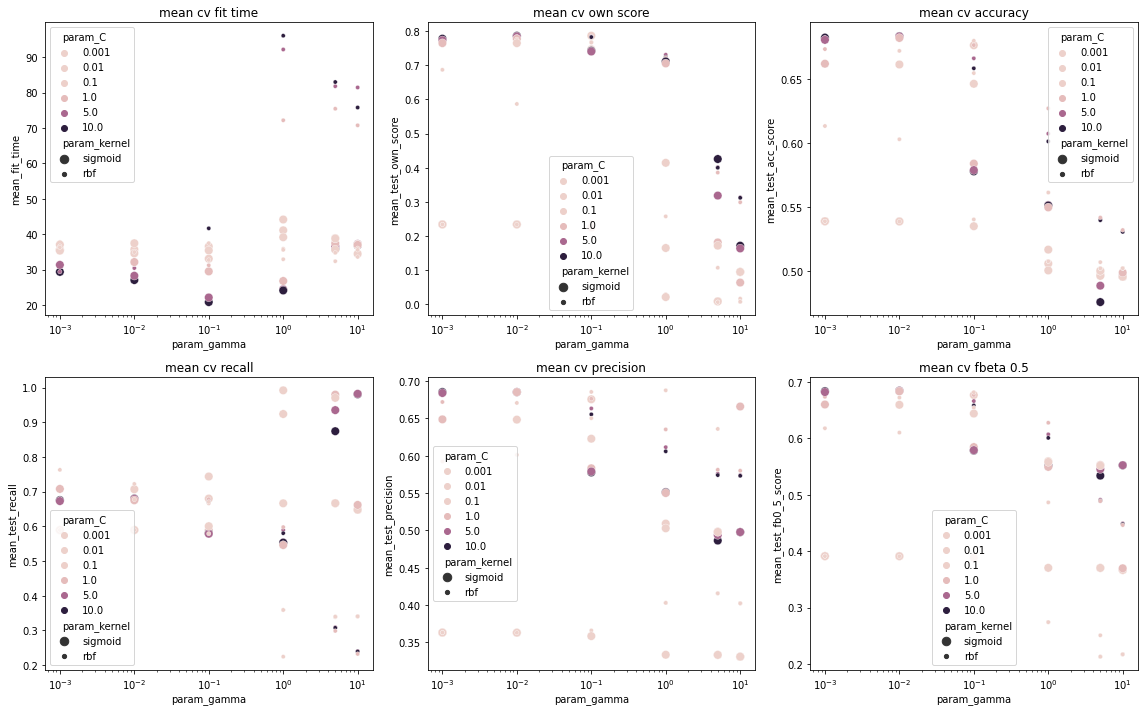

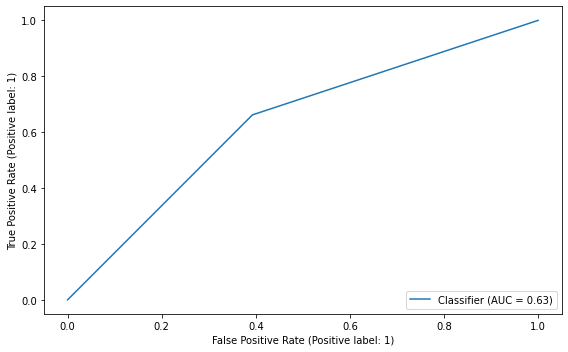

              precision    recall  f1-score   support

           0       0.64      0.61      0.62      7170
           1       0.63      0.66      0.64      7170

    accuracy                           0.63     14340
   macro avg       0.63      0.63      0.63     14340
weighted avg       0.63      0.63      0.63     14340



In [35]:
#resultats du gridsearchCV
clf_KSVC.cv_results_.keys()
res_KSVC=pd.DataFrame(clf_KSVC.cv_results_).sort_values(by='rank_test_own_score')
print('meilleur estimateur',clf_KSVC.best_estimator_)
print('best score',"{:.2f}".format(clf_KSVC.best_score_))
print('best param',clf_KSVC.best_params_)

#import seaborn as sns
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_test_score", hue='param_learning_rate')
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_fit_time", hue='param_learning_rate')

#prediction
y_pred=clf_KSVC.predict(X_test.to_numpy())
#y_pred_prob=clf.predict_proba(X_test.to_numpy())[:,1]
score_pred=clf_KSVC.score(X_test.to_numpy(),y_test.values.ravel())
print('score prediction',"{:.2f}".format(score_pred))

#les différentes metrics
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test, y_pred))

import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc=metrics.auc(fpr, tpr)
print('roc auc:',"{:.2f}".format(roc_auc))

#display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='adaboost: seuil continu')
#display.plot()
#plt.show()

###################################
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["figure.autolayout"] = True

#plt.figure(figsize=(16,15))
plt.figure(figsize=(16,10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)


sns.scatterplot(data=res_KSVC, x="param_gamma", y="mean_fit_time",hue='param_C',size='param_kernel', ax=ax1)
sns.scatterplot(data=res_KSVC, x="param_gamma", y="mean_test_own_score",hue='param_C',size='param_kernel',ax=ax2)
sns.scatterplot(data=res_KSVC, x="param_gamma", y="mean_test_acc_score",hue='param_C',size='param_kernel',ax=ax3)
sns.scatterplot(data=res_KSVC, x="param_gamma", y="mean_test_recall",hue='param_C',size='param_kernel',ax=ax4)
sns.scatterplot(data=res_KSVC, x="param_gamma", y="mean_test_precision",hue='param_C',size='param_kernel',ax=ax5)
sns.scatterplot(data=res_KSVC, x="param_gamma", y="mean_test_fb0_5_score",hue='param_C',size='param_kernel',ax=ax6)
#[res_KSVC.param_kernel=='sigmoid',:]

ax1.title.set_text('mean cv fit time')
ax1.set(xscale="log")
ax2.title.set_text('mean cv own score')
ax2.set(xscale="log")
ax3.title.set_text('mean cv accuracy')
ax3.set(xscale="log")
ax4.title.set_text('mean cv recall')
ax4.set(xscale="log")
ax5.title.set_text('mean cv precision')
ax5.set(xscale="log")
ax6.title.set_text('mean cv fbeta 0.5')
ax6.set(xscale="log")

plt.show()


plt.rcParams["figure.figsize"] = [8, 5]
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print(metrics.classification_report(y_test, y_pred))

#les coefficients"
#import seaborn as sns
#from IPython.display import display
#cm = sns.light_palette('purple', as_cmap=True)
#pd.options.display.float_format = '{:,.2f}'.format
#pd.set_option('max_rows', None)
#display(pd.DataFrame(clf.feature_importances_,index=X_train.columns).style.background_gradient(cm).format('{:,.2f}'))
#pd.set_option('max_rows', 10)

In [196]:
#sauvegarde de modele
#alternative: from sklearn.externals import joblib
import pickle
# Save to file in the current working directory
pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_KSVC_1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf_KSVC, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
 #   pickle_model = pickle.load(file)

## 7) h) GRIDSEARCHCV BAGGING

In [58]:
#baggingclassifier
#bagging methods work best with strong and complex models (e.g., fully developed decision trees), 
#in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).
#random subsets of the samples = pasting
    #avec replacement = bagging
#random subsets of the features = Random Subspaces
#random subsets of the samples and the features = Random Patches

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
import time



#initialisation du classifieur
    #DecisionTreeClassifier utilisé en estimateur par defaut: 
    #on aurait pu prendre logistic, knn, SVC par exemple
    
grid = dict()
grid['n_estimators']=[1,5,10,25,50,75,100,125,150,175,200,225,250,275,300] #(10 def)

#controle de la taille des echantillons
#grid['max_samples']=[1.0] #par defaut mais on peut faire plsu de sample par estimateurs 
#grid['max_features']=[1.0]

#controle si le reechantillonnag utilise le remplacement
#grid['bootstrap']=[True]
#grid['bootstrap_features']=[False]


clf_BAG = GridSearchCV(estimator=BaggingClassifier(),
                   param_grid=grid,
                   scoring=my_custom_score2,n_jobs=-1,
                   cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1),
                   error_score='raise',
                   refit='own_score',
                   verbose=3)


start = time.time()
clf_BAG.fit(X_train.to_numpy(), y_train.values.ravel())
end = time.time()
print(f"Runtime of the program is {end - start}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Runtime of the program is 440.0126814842224


meilleur estimateur BaggingClassifier(n_estimators=175)
best score 0.79
best param {'n_estimators': 175}
score prediction 0.78
roc auc: 0.73


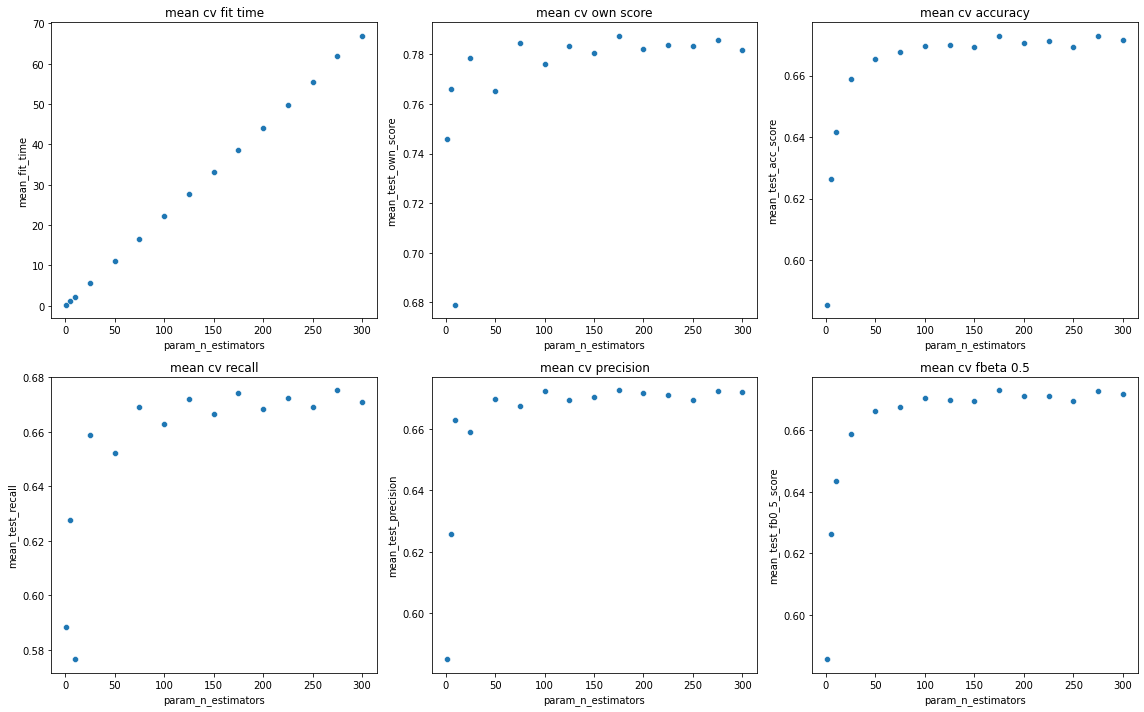

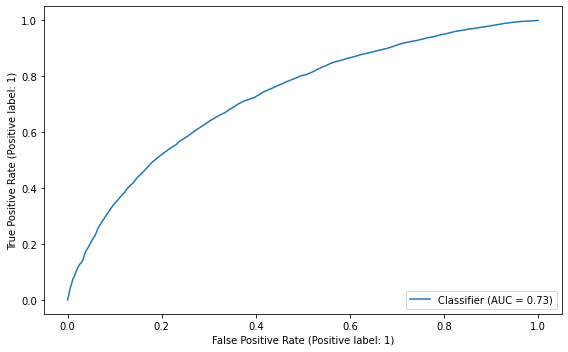

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      7170
           1       0.67      0.67      0.67      7170

    accuracy                           0.67     14340
   macro avg       0.67      0.67      0.67     14340
weighted avg       0.67      0.67      0.67     14340



In [59]:
#resultats du gridsearchCV
clf_BAG.cv_results_.keys()
res_BAG=pd.DataFrame(clf_BAG.cv_results_).sort_values(by='rank_test_own_score')
print('meilleur estimateur',clf_BAG.best_estimator_)
print('best score',"{:.2f}".format(clf_BAG.best_score_))
print('best param',clf_BAG.best_params_)

#import seaborn as sns
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_test_score", hue='param_learning_rate')
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_fit_time", hue='param_learning_rate')

#prediction
y_pred=clf_BAG.predict(X_test.to_numpy())
y_pred_prob=clf_BAG.predict_proba(X_test.to_numpy())[:,1]
score_pred=clf_BAG.score(X_test.to_numpy(),y_test.values.ravel())
print('score prediction',"{:.2f}".format(score_pred))

#les différentes metrics
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test, y_pred))

import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc=metrics.auc(fpr, tpr)
print('roc auc:',"{:.2f}".format(roc_auc))

#display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='adaboost: seuil continu')
#display.plot()
#plt.show()

###################################
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["figure.autolayout"] = True

#plt.figure(figsize=(16,15))
plt.figure(figsize=(16,10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)


sns.scatterplot(data=res_BAG, x="param_n_estimators", y="mean_fit_time", ax=ax1)
sns.scatterplot(data=res_BAG, x="param_n_estimators", y="mean_test_own_score",ax=ax2)
sns.scatterplot(data=res_BAG, x="param_n_estimators", y="mean_test_acc_score",ax=ax3)
sns.scatterplot(data=res_BAG, x="param_n_estimators", y="mean_test_recall",ax=ax4)
sns.scatterplot(data=res_BAG, x="param_n_estimators", y="mean_test_precision",ax=ax5)
sns.scatterplot(data=res_BAG, x="param_n_estimators", y="mean_test_fb0_5_score",ax=ax6)


ax1.title.set_text('mean cv fit time')
#ax1.set(xscale="log")
ax2.title.set_text('mean cv own score')
#ax2.set(xscale="log")
ax3.title.set_text('mean cv accuracy')
#ax3.set(xscale="log")
ax4.title.set_text('mean cv recall')
#ax4.set(xscale="log")
ax5.title.set_text('mean cv precision')
#ax5.set(xscale="log")
ax6.title.set_text('mean cv fbeta 0.5')
#ax6.set(xscale="log")

plt.show()

###################################

plt.rcParams["figure.figsize"] = [8, 5]
metrics.RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.show()
print(metrics.classification_report(y_test, y_pred))

#les coefficients"
#import seaborn as sns
#from IPython.display import display
#cm = sns.light_palette('purple', as_cmap=True)
#pd.options.display.float_format = '{:,.2f}'.format
#pd.set_option('max_rows', None)
#display(pd.DataFrame(clf.feature_importances_,index=X_train.columns).style.background_gradient(cm).format('{:,.2f}'))
#pd.set_option('max_rows', 10)




In [60]:
#sauvegarde de modele
#alternative: from sklearn.externals import joblib
import pickle
# Save to file in the current working directory
pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_BAG_1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf_BAG, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
 #   pickle_model = pickle.load(file)

## 7) i) GRIDSEARCHCV RANDOM FOREST

In [61]:
#RANDOM FOREST improve decision tree en pratique
#DECISIONTREE SEUL / easy to use but strong inaccuracy, lack of flexibility
#RF: fonctionnement
    #1) boostrap sample avec remise(duplication autorisé)
        #comme il ya remise 1/3 des données ne sont pas samplé ddans le bootstrap => out of bag
        #on utilisera cet out of bag pour voir si l'arbre cree classe correctement le out of bag
        #on utilisera les out og bag sur chaque arbres qu ils n ont pas servi a creer
        #et on pourra calculer le out of bag error (les out of bag mal classés)
    #2) arbres aleatoires avec n<N(choisi) variables tires au sort à chaque étape et on developpe la meilleure souche en arbre avec le meme fonctionnement
        #pour choisir le n on utilisera un min du out of bag error
            #on part en general de la raciné carré du nombre de variables
            #et on test au dessus et en dessous
    #3) on repete ca plusieurs fois (des centaines dans l ideal)
    
    
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time



#initialisation du classifieur
    #DecisionTreeClassifier utilisé en estimateur par defaut: 
    #on aurait pu prendre logistic, knn, SVC par exemple
    
grid = dict()

#Main parameters
grid['n_estimators']=[10,50,100,150,200,300,400,500,600,700,800,900,1000] #nombre d arbres : 100 par def : 
                        #plus c est grand , mieux c est (jusqu à un certain point de convergence) mais plus c est lent
    
grid['max_features']=[2,5,'sqrt',10,20] #when splitting each node during the construction of a tree, the best split is found 
             #either from all input features or a random subset of size max_features
            #plus c'est faible , meilleur est la reduction de variance mais ca augmente les biais
            # en general mettre none (tous les features) pour les regression et sqrt(n features) pour les classification

#controle du boot
#grid['bootstrap']=[True]#defaut
#grid['max_samples']=[None]#defaut

#paramètres qui permettent de reduire la taille du modèle O(M*N*log(N))-> M nb arbres / N nb obs
    #penser egalement a baisser le nombre d'obs si trop grand au depart
#min_samples_split=2 #donne les meilleurs resultats si arbre completement dev
#max_depth=None #donne les meilleurs resultats

#max_leaf_nodes
#min_samples_leaf
    
#other parameters
#min_impurity_decrease
#oob_score
#class_weight
#ccp_alpha


clf_RF = GridSearchCV(estimator=RandomForestClassifier(),
                   param_grid=grid,
                   scoring=my_custom_score2,n_jobs=-1,
                   cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1),
                   error_score='raise',
                   refit='own_score',
                   verbose=3)


start = time.time()
clf_RF.fit(X_train.to_numpy(), y_train.values.ravel())
end = time.time()
print(f"Runtime of the program is {end - start}")

Fitting 5 folds for each of 65 candidates, totalling 325 fits
Runtime of the program is 987.3384246826172


meilleur estimateur RandomForestClassifier(max_features=20, n_estimators=300)
best score 0.79
best param {'max_features': 20, 'n_estimators': 300}
score prediction 0.79
roc auc: 0.68


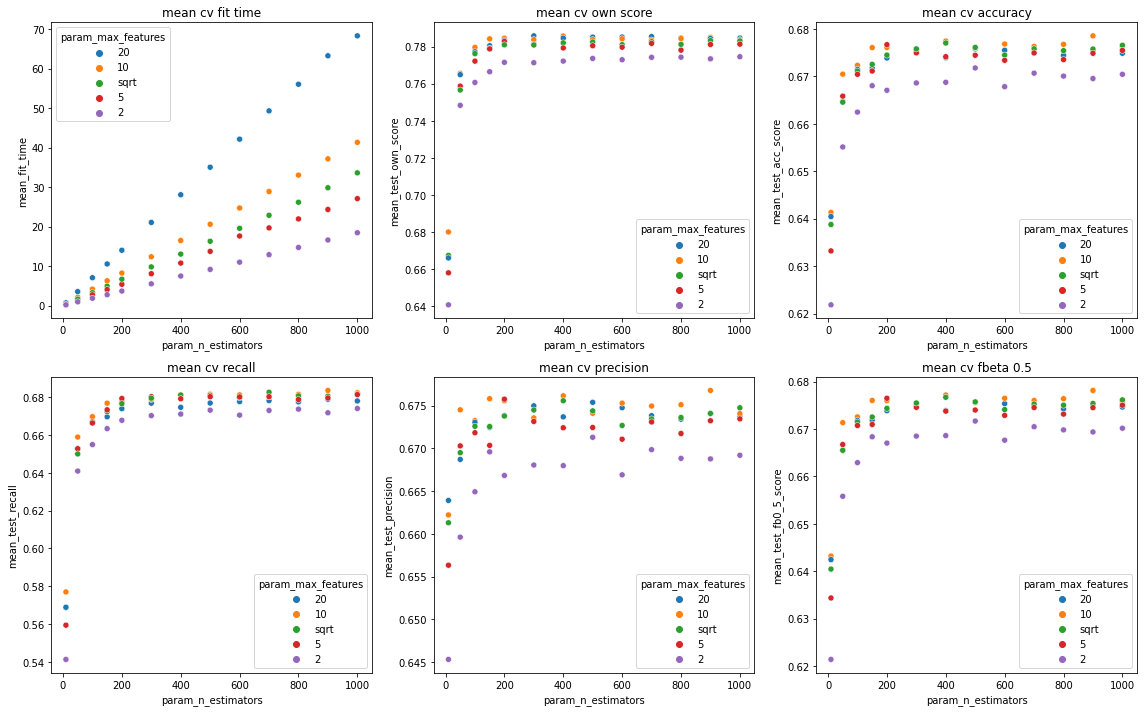

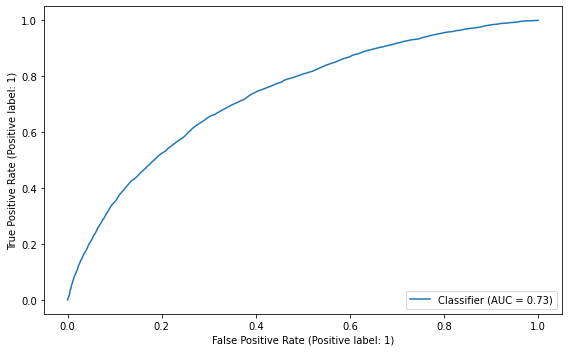

              precision    recall  f1-score   support

           0       0.68      0.67      0.67      7170
           1       0.67      0.68      0.68      7170

    accuracy                           0.68     14340
   macro avg       0.68      0.68      0.68     14340
weighted avg       0.68      0.68      0.68     14340



In [62]:
#resultats du gridsearchCV
clf_RF.cv_results_.keys()
res_RF=pd.DataFrame(clf_RF.cv_results_).sort_values(by='rank_test_own_score')
print('meilleur estimateur',clf_RF.best_estimator_)
print('best score',"{:.2f}".format(clf_RF.best_score_))
print('best param',clf_RF.best_params_)

#import seaborn as sns
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_test_score", hue='param_learning_rate')
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_fit_time", hue='param_learning_rate')

#prediction
y_pred=clf_RF.predict(X_test.to_numpy())
y_pred_prob=clf_RF.predict_proba(X_test.to_numpy())[:,1]
score_pred=clf_RF.score(X_test.to_numpy(),y_test.values.ravel())
print('score prediction',"{:.2f}".format(score_pred))

#les différentes metrics
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test, y_pred))

import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc=metrics.auc(fpr, tpr)
print('roc auc:',"{:.2f}".format(roc_auc))

#display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='adaboost: seuil continu')
#display.plot()
#plt.show()

###################################
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["figure.autolayout"] = True

#plt.figure(figsize=(16,15))
plt.figure(figsize=(16,10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)


sns.scatterplot(data=res_RF, x="param_n_estimators", y="mean_fit_time",hue='param_max_features', ax=ax1)
sns.scatterplot(data=res_RF, x="param_n_estimators", y="mean_test_own_score",hue='param_max_features',ax=ax2)
sns.scatterplot(data=res_RF, x="param_n_estimators", y="mean_test_acc_score",hue='param_max_features',ax=ax3)
sns.scatterplot(data=res_RF, x="param_n_estimators", y="mean_test_recall",hue='param_max_features',ax=ax4)
sns.scatterplot(data=res_RF, x="param_n_estimators", y="mean_test_precision",hue='param_max_features',ax=ax5)
sns.scatterplot(data=res_RF, x="param_n_estimators", y="mean_test_fb0_5_score",hue='param_max_features',ax=ax6)


ax1.title.set_text('mean cv fit time')
#ax1.set(xscale="log")
ax2.title.set_text('mean cv own score')
#ax2.set(xscale="log")
ax3.title.set_text('mean cv accuracy')
#ax3.set(xscale="log")
ax4.title.set_text('mean cv recall')
#ax4.set(xscale="log")
ax5.title.set_text('mean cv precision')
#ax5.set(xscale="log")
ax6.title.set_text('mean cv fbeta 0.5')
#ax6.set(xscale="log")

plt.show()

plt.rcParams["figure.figsize"] = [8, 5]
metrics.RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.show()
print(metrics.classification_report(y_test, y_pred))

#les coefficients"
#import seaborn as sns
#from IPython.display import display
#cm = sns.light_palette('purple', as_cmap=True)
#pd.options.display.float_format = '{:,.2f}'.format
#pd.set_option('max_rows', None)
#display(pd.DataFrame(clf.feature_importances_,index=X_train.columns).style.background_gradient(cm).format('{:,.2f}'))
#pd.set_option('max_rows', 10)

In [63]:
#sauvegarde de modele
#alternative: from sklearn.externals import joblib
import pickle
# Save to file in the current working directory
pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_RF_1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf_RF, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
 #   pickle_model = pickle.load(file)

## 7) j) GRIDSEARCHCV GRADIENT BOOSTING

In [78]:
#GRADIENT BOOSTING (pas mal pour 2 classes / prendre quelquechose de plus rapide pour du multiclasse comme le histgradientboost)
        #histgradientboosting plus rapide que gradientboosting car utilise un histogramme a chaque noeud au lieu d'un tri plus couteux
        #PARAIT COMPPLEXE mais sert à predire des poids ou une classe binaire dans 99% des cas
        #la complexité sert la generalisation
        #finalement assez proche de adaboost
        
        #point de depart: target moyen qui servira de premiere feuille/arbre
                #on passe par la logistique pour pour probabiliser dans le cas de la classification
            #calcul de la somme des residus
            #puis construction d'un arbre pour predire ce residus
            #prediction=leaf intitale + residus trouve par l'arbre , pondere par un learning rate de 0 à 1 afin de scaler le poids de l arbre (0.1 par exemple)
            #et ainsi de suite de facon a faire a chaque fois un petit pas dan sla bonne direction
        #construction d'arbre basé sur l'erreur du precedent (comme adaboost) limité en taille mais plus grand qu'adaboost
        #en general de 8 à 32 feuilles max (pour avoir moins de feuilles que de residus a predire)
        #construction d'arbres jusqu a la limite souhaitée ou jusqu a ce que le fit ne s ameliore plus
        #la fonction loss differentiable à minimiser et la somme des carrées des residus
            #donc le gradient est al derivee ce qui revient à la somme des residus
        
#DECISIONTREE SEUL / easy to use but strong inaccuracy, lack of flexibility
#RF: fonctionnement
    #1) boostrap sample avec remise(duplication autorisé)
        #comme il ya remise 1/3 des données ne sont pas samplé ddans le bootstrap => out of bag
        #on utilisera cet out of bag pour voir si l'arbre cree classe correctement le out of bag
        #on utilisera les out og bag sur chaque arbres qu ils n ont pas servi a creer
        #et on pourra calculer le out of bag error (les out of bag mal classés)
    #2) arbres aleatoires avec n<N(choisi) variables tires au sort à chaque étape et on developpe la meilleure souche en arbre avec le meme fonctionnement
        #pour choisir le n on utilisera un min du out of bag error
            #on part en general de la raciné carré du nombre de variables
            #et on test au dessus et en dessous
    #3) on repete ca plusieurs fois (des centaines dans l ideal)
    
    
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import time



#initialisation du classifieur
    #DecisionTreeClassifier utilisé en estimateur par defaut: 
    #on aurait pu prendre logistic, knn, SVC par exemple
    
grid = dict()

#Main parameters
grid['n_estimators']=[25,50,100,150,200,250,300,350,400] #default=100
    #nombre d'arbres: Gradient boosting is fairly robust to over-fitting 
    #large number usually results in better performance.
grid['learning_rate']=[0.05] #default=0.1
    #trade-off between learning_rate and n_estimators.
    #Smaller values of learning_rate require larger numbers of weak learners to maintain a constant training error.
    
        #controle size arbre au choix des 2
#grid['max_depth']=[3] #default=3
    #The maximum depth of the individual regression estimators. 
    #profondeur des arbres
    #Tune this parameter for best performance
    # en general : tree of depth h can capture interactions of order h ->2**h leaf nodes and 2**h - 1 split nodes
        #donc si h=3 à 5 on a 8 à 32 feuilles
    #dans le cas du gradient boosting: max_leaf_nodes=k est comparable à une depth de k-1
grid['max_leaf_nodes']=[4,8,16,32,64] #default=None
    #Grow trees with max_leaf_nodes in best-first fashion. 
    #If None then unlimited number of leaf nodes.
        
        #reduction de variance & runtime
#grid['subsample']=[0.5,1.0] #default=1.0
    #fraction of samples to be used for fitting the individual base learners. 
    #If smaller than 1.0 this results in Stochastic aléatoire) Gradient Boosting. 
    # subsample interacts with the parameter n_estimators. 
    #Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.
    #The subsample is drawn without replacement. A typical value of subsample is 0.5.
#grid['max_features']=[auto, sqrt, log2]#default=None (full) in ou float pour fraction
    #The number of features to consider when looking for the best split
    #Choosing max_features < n_features leads to a reduction of variance and an increase in bias.
    #Using a small max_features value can significantly decrease the RUNTIME
grid['tol']=[1e-3] #default=1e-4
    #Tolerance for the early stopping When the loss is not improving by at least tol 
    
#other parameters
#grid['loss']=['deviance', 'exponential'] #default=’deviance’
    #loss function to be optimized: deviance = logistic regression for classification with probabilistic outputs. 
    #xponential = AdaBoost algorithm.
#grid['criterion']=['friedman_mse', 'squared_error'] #default=’friedman_mse’
    #quality of a split.‘friedman_mse’ is generally the best 
#grid['min_samples_split']=[2] #default=2
    #The minimum number of samples required to split an internal node:
    #int = nombre et float=fraction du nombre  d obs
#grid['min_samples_leaf']=[1] #default=1
    #The minimum number of samples required to be at a leaf node. 
    #A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 
    #smoothing the model, especially in regression.
    #int = nombre et float=fraction du nombre  d obs
#grid['min_weight_fraction_leaf']=[0.0] #default=0.0
    #The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. 
    #Samples have equal weight when sample_weight is not provided.
#grid['tol']=[1e-3] #default=1e-4
    #Tolerance for the early stopping When the loss is not improving by at least tol 
#grid['ccp_alpha']=[0.0] #default=0.0
    #Complexity parameter used for Minimal Cost-Complexity Pruning. 
    #The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. 




clf_GB = GridSearchCV(estimator=GradientBoostingClassifier(),
                   param_grid=grid,
                   scoring=my_custom_score2,n_jobs=-1,
                   cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1),
                   error_score='raise',
                   refit='own_score',
                   verbose=3)


start = time.time()
clf_GB.fit(X_train.to_numpy(), y_train.values.ravel())
end = time.time()
print(f"Runtime of the program is {end - start}")


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Runtime of the program is 752.3904612064362


meilleur estimateur GradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=32,
                           n_estimators=300, tol=0.001)
best score 0.79
best param {'learning_rate': 0.05, 'max_leaf_nodes': 32, 'n_estimators': 300, 'tol': 0.001}
score prediction 0.79
roc auc: 0.68


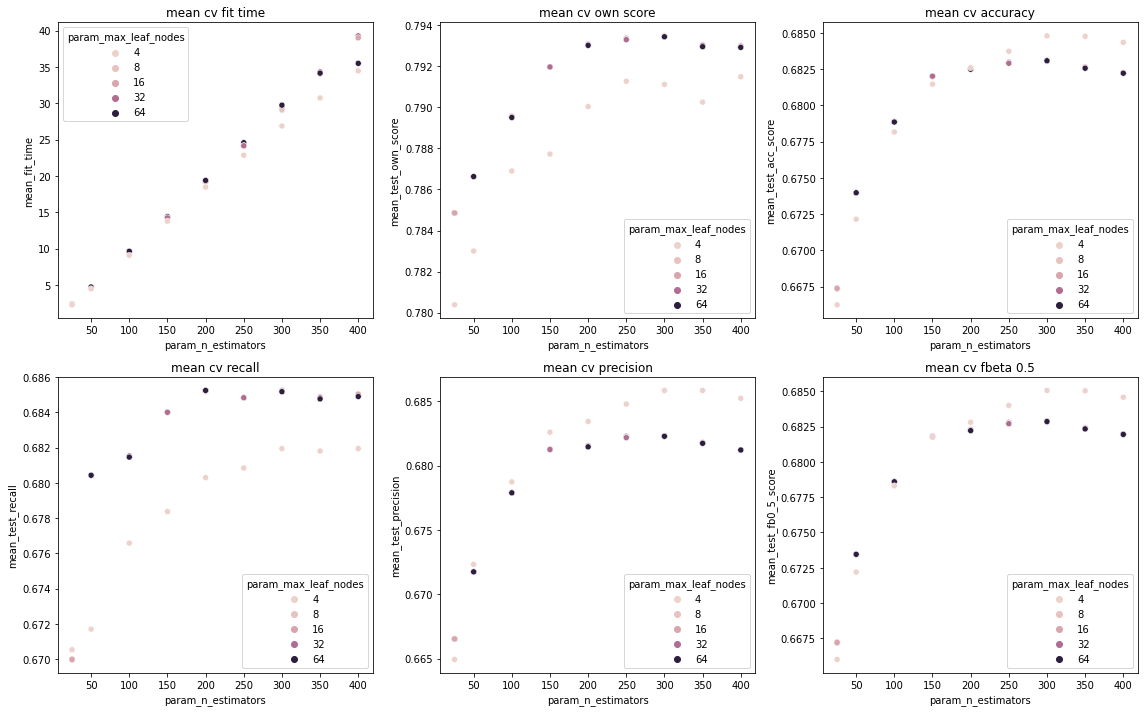

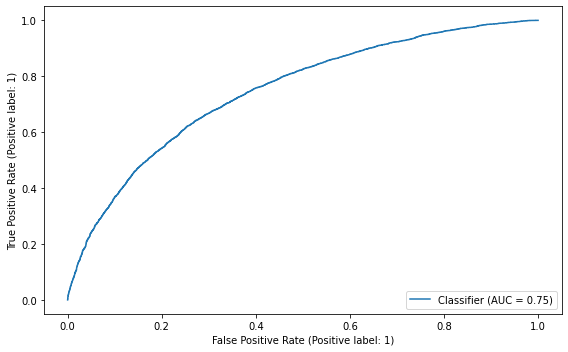

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      7170
           1       0.68      0.69      0.68      7170

    accuracy                           0.68     14340
   macro avg       0.68      0.68      0.68     14340
weighted avg       0.68      0.68      0.68     14340



In [79]:
#resultats du gridsearchCV
clf_GB.cv_results_.keys()
res_GB=pd.DataFrame(clf_GB.cv_results_).sort_values(by='rank_test_own_score')
print('meilleur estimateur',clf_GB.best_estimator_)
print('best score',"{:.2f}".format(clf_GB.best_score_))
print('best param',clf_GB.best_params_)

#import seaborn as sns
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_test_score", hue='param_learning_rate')
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_fit_time", hue='param_learning_rate')

#prediction
y_pred=clf_GB.predict(X_test.to_numpy())
y_pred_prob=clf_GB.predict_proba(X_test.to_numpy())[:,1]
score_pred=clf_GB.score(X_test.to_numpy(),y_test.values.ravel())
print('score prediction',"{:.2f}".format(score_pred))

#les différentes metrics
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test, y_pred))



import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc=metrics.auc(fpr, tpr)
print('roc auc:',"{:.2f}".format(roc_auc))

#display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='adaboost: seuil continu')
#display.plot()
#plt.show()

###################################
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["figure.autolayout"] = True

#plt.figure(figsize=(16,15))
plt.figure(figsize=(16,10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)


sns.scatterplot(data=res_GB, x="param_n_estimators", y="mean_fit_time",hue='param_max_leaf_nodes', ax=ax1)
sns.scatterplot(data=res_GB, x="param_n_estimators", y="mean_test_own_score",hue='param_max_leaf_nodes',ax=ax2)
sns.scatterplot(data=res_GB, x="param_n_estimators", y="mean_test_acc_score",hue='param_max_leaf_nodes',ax=ax3)
sns.scatterplot(data=res_GB, x="param_n_estimators", y="mean_test_recall",hue='param_max_leaf_nodes',ax=ax4)
sns.scatterplot(data=res_GB, x="param_n_estimators", y="mean_test_precision",hue='param_max_leaf_nodes',ax=ax5)
sns.scatterplot(data=res_GB, x="param_n_estimators", y="mean_test_fb0_5_score",hue='param_max_leaf_nodes',ax=ax6)


ax1.title.set_text('mean cv fit time')
#ax1.set(xscale="log")
ax2.title.set_text('mean cv own score')
#ax2.set(xscale="log")
ax3.title.set_text('mean cv accuracy')
#ax3.set(xscale="log")
ax4.title.set_text('mean cv recall')
#ax4.set(xscale="log")
ax5.title.set_text('mean cv precision')
#ax5.set(xscale="log")
ax6.title.set_text('mean cv fbeta 0.5')
#ax6.set(xscale="log")

plt.show()

###################################

plt.rcParams["figure.figsize"] = [8, 5]
metrics.RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.show()
print(metrics.classification_report(y_test, y_pred))

#les coefficients"
#import seaborn as sns
#from IPython.display import display
#cm = sns.light_palette('purple', as_cmap=True)
#pd.options.display.float_format = '{:,.2f}'.format
#pd.set_option('max_rows', None)
#display(pd.DataFrame(clf.feature_importances_,index=X_train.columns).style.background_gradient(cm).format('{:,.2f}'))
#pd.set_option('max_rows', 10)

In [80]:
#sauvegarde de modele
#alternative: from sklearn.externals import joblib
import pickle
# Save to file in the current working directory
pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_GB_1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf_GB, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
 #   pickle_model = pickle.load(file)

## 7) k) GRADIENT BOOSTING FULL

In [363]:
#GRADIENT BOOSTING (pas mal pour 2 classes / prendre quelquechose de plus rapide pour du multiclasse comme le histgradientboost)
        #histgradientboosting plus rapide que gradientboosting car utilise un histogramme a chaque noeud au lieu d'un tri plus couteux
        #PARAIT COMPPLEXE mais sert à predire des poids ou une classe binaire dans 99% des cas
        #la complexité sert la generalisation
        #finalement assez proche de adaboost
        
        #point de depart: target moyen qui servira de premiere feuille/arbre
                #on passe par la logistique pour pour probabiliser dans le cas de la classification
            #calcul de la somme des residus
            #puis construction d'un arbre pour predire ce residus
            #prediction=leaf intitale + residus trouve par l'arbre , pondere par un learning rate de 0 à 1 afin de scaler le poids de l arbre (0.1 par exemple)
            #et ainsi de suite de facon a faire a chaque fois un petit pas dan sla bonne direction
        #construction d'arbre basé sur l'erreur du precedent (comme adaboost) limité en taille mais plus grand qu'adaboost
        #en general de 8 à 32 feuilles max (pour avoir moins de feuilles que de residus a predire)
        #construction d'arbres jusqu a la limite souhaitée ou jusqu a ce que le fit ne s ameliore plus
        #la fonction loss differentiable à minimiser et la somme des carrées des residus
            #donc le gradient est al derivee ce qui revient à la somme des residus
        
#DECISIONTREE SEUL / easy to use but strong inaccuracy, lack of flexibility
#RF: fonctionnement
    #1) boostrap sample avec remise(duplication autorisé)
        #comme il ya remise 1/3 des données ne sont pas samplé ddans le bootstrap => out of bag
        #on utilisera cet out of bag pour voir si l'arbre cree classe correctement le out of bag
        #on utilisera les out og bag sur chaque arbres qu ils n ont pas servi a creer
        #et on pourra calculer le out of bag error (les out of bag mal classés)
    #2) arbres aleatoires avec n<N(choisi) variables tires au sort à chaque étape et on developpe la meilleure souche en arbre avec le meme fonctionnement
        #pour choisir le n on utilisera un min du out of bag error
            #on part en general de la raciné carré du nombre de variables
            #et on test au dessus et en dessous
    #3) on repete ca plusieurs fois (des centaines dans l ideal)
    
    
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import time



#initialisation du classifieur
    #DecisionTreeClassifier utilisé en estimateur par defaut: 
    #on aurait pu prendre logistic, knn, SVC par exemple
    
grid = dict()

#Main parameters
grid['n_estimators']=[25,50,100,150,200,250,300,350,400] #default=100
    #nombre d'arbres: Gradient boosting is fairly robust to over-fitting 
    #large number usually results in better performance.
grid['learning_rate']=[0.05] #default=0.1
    #trade-off between learning_rate and n_estimators.
    #Smaller values of learning_rate require larger numbers of weak learners to maintain a constant training error.
    
        #controle size arbre au choix des 2
#grid['max_depth']=[3] #default=3
    #The maximum depth of the individual regression estimators. 
    #profondeur des arbres
    #Tune this parameter for best performance
    # en general : tree of depth h can capture interactions of order h ->2**h leaf nodes and 2**h - 1 split nodes
        #donc si h=3 à 5 on a 8 à 32 feuilles
    #dans le cas du gradient boosting: max_leaf_nodes=k est comparable à une depth de k-1
grid['max_leaf_nodes']=[4,8,16,32,64] #default=None
    #Grow trees with max_leaf_nodes in best-first fashion. 
    #If None then unlimited number of leaf nodes.
        
        #reduction de variance & runtime
#grid['subsample']=[0.5,1.0] #default=1.0
    #fraction of samples to be used for fitting the individual base learners. 
    #If smaller than 1.0 this results in Stochastic aléatoire) Gradient Boosting. 
    # subsample interacts with the parameter n_estimators. 
    #Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.
    #The subsample is drawn without replacement. A typical value of subsample is 0.5.
#grid['max_features']=[auto, sqrt, log2]#default=None (full) in ou float pour fraction
    #The number of features to consider when looking for the best split
    #Choosing max_features < n_features leads to a reduction of variance and an increase in bias.
    #Using a small max_features value can significantly decrease the RUNTIME
grid['tol']=[1e-3] #default=1e-4
    #Tolerance for the early stopping When the loss is not improving by at least tol 
    
#other parameters
#grid['loss']=['deviance', 'exponential'] #default=’deviance’
    #loss function to be optimized: deviance = logistic regression for classification with probabilistic outputs. 
    #xponential = AdaBoost algorithm.
#grid['criterion']=['friedman_mse', 'squared_error'] #default=’friedman_mse’
    #quality of a split.‘friedman_mse’ is generally the best 
#grid['min_samples_split']=[2] #default=2
    #The minimum number of samples required to split an internal node:
    #int = nombre et float=fraction du nombre  d obs
#grid['min_samples_leaf']=[1] #default=1
    #The minimum number of samples required to be at a leaf node. 
    #A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 
    #smoothing the model, especially in regression.
    #int = nombre et float=fraction du nombre  d obs
#grid['min_weight_fraction_leaf']=[0.0] #default=0.0
    #The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. 
    #Samples have equal weight when sample_weight is not provided.
#grid['tol']=[1e-3] #default=1e-4
    #Tolerance for the early stopping When the loss is not improving by at least tol 
#grid['ccp_alpha']=[0.0] #default=0.0
    #Complexity parameter used for Minimal Cost-Complexity Pruning. 
    #The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. 




clf_GB2 = GridSearchCV(estimator=GradientBoostingClassifier(),
                   param_grid=grid,
                   scoring=my_custom_score2,n_jobs=-1,
                   cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1),
                   error_score='raise',
                   refit='own_score',
                   verbose=3)


start = time.time()
clf_GB2.fit(X_train2.to_numpy(), y_train.values.ravel())
end = time.time()
print(f"Runtime of the program is {end - start}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Runtime of the program is 5679.27162861824
meilleur estimateur GradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=16,
                           n_estimators=300, tol=0.001)
best score 0.80
best param {'learning_rate': 0.05, 'max_leaf_nodes': 16, 'n_estimators': 300, 'tol': 0.001}


meilleur estimateur GradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=16,
                           n_estimators=300, tol=0.001)
best score 0.80
best param {'learning_rate': 0.05, 'max_leaf_nodes': 16, 'n_estimators': 300, 'tol': 0.001}
score prediction 0.76


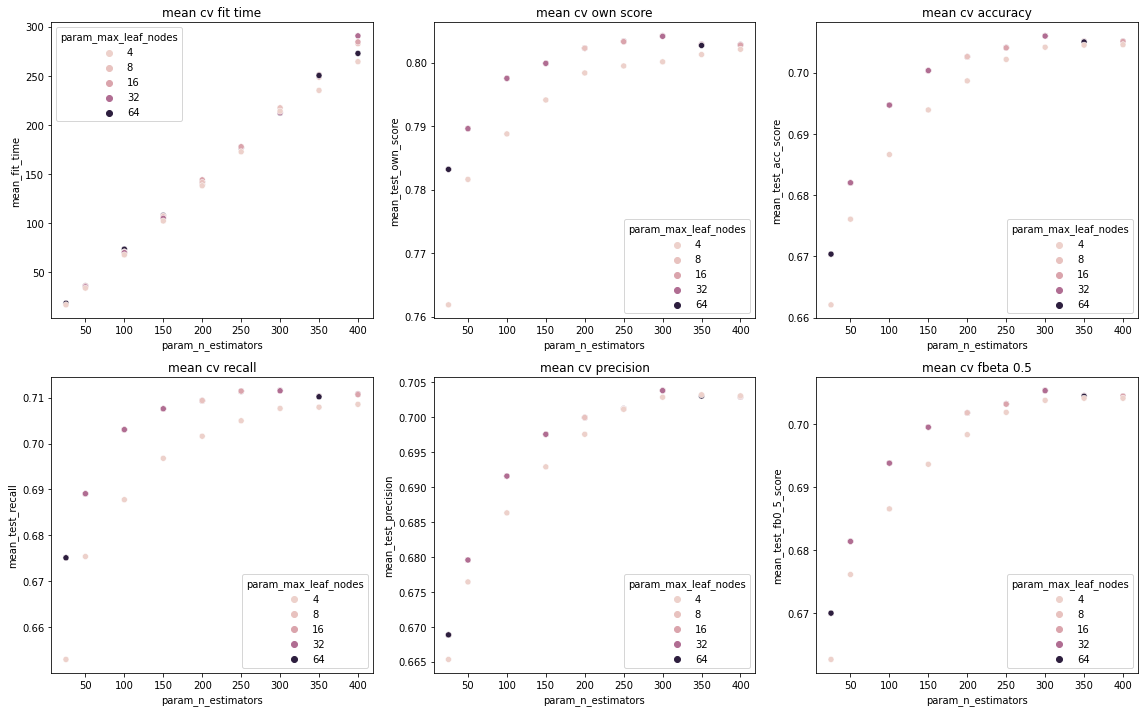

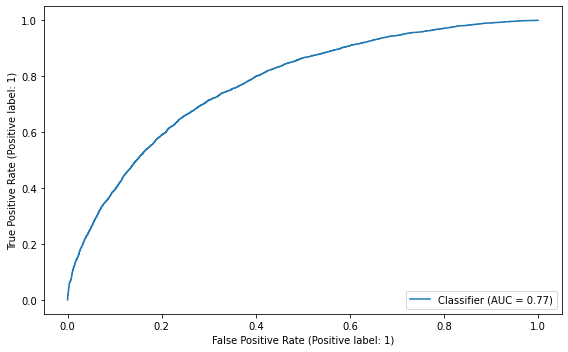

              precision    recall  f1-score   support

           0       0.76      0.58      0.66      7170
           1       0.66      0.82      0.73      7170

    accuracy                           0.70     14340
   macro avg       0.71      0.70      0.69     14340
weighted avg       0.71      0.70      0.69     14340



In [39]:
#resultats du gridsearchCV
clf_GB2.cv_results_.keys()
res_GB2=pd.DataFrame(clf_GB2.cv_results_).sort_values(by='rank_test_own_score')
print('meilleur estimateur',clf_GB2.best_estimator_)
print('best score',"{:.2f}".format(clf_GB2.best_score_))
print('best param',clf_GB2.best_params_)

#import seaborn as sns
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_test_score", hue='param_learning_rate')
#sns.scatterplot(data=res, x="param_n_estimators", y="mean_fit_time", hue='param_learning_rate')

#prediction
y_pred=clf_GB2.predict(X_test2.to_numpy())
y_pred_prob=clf_GB2.predict_proba(X_test2.to_numpy())[:,1]
score_pred=clf_GB2.score(X_test2.to_numpy(),y_test.values.ravel())
print('score prediction',"{:.2f}".format(score_pred))

#les différentes metrics
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test, y_pred))

import numpy as np
from sklearn import metrics

#display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='adaboost: seuil continu')
#display.plot()
#plt.show()

###################################
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["figure.autolayout"] = True

#plt.figure(figsize=(16,15))
plt.figure(figsize=(16,10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)


sns.scatterplot(data=res_GB2, x="param_n_estimators", y="mean_fit_time",hue='param_max_leaf_nodes', ax=ax1)
sns.scatterplot(data=res_GB2, x="param_n_estimators", y="mean_test_own_score",hue='param_max_leaf_nodes',ax=ax2)
sns.scatterplot(data=res_GB2, x="param_n_estimators", y="mean_test_acc_score",hue='param_max_leaf_nodes',ax=ax3)
sns.scatterplot(data=res_GB2, x="param_n_estimators", y="mean_test_recall",hue='param_max_leaf_nodes',ax=ax4)
sns.scatterplot(data=res_GB2, x="param_n_estimators", y="mean_test_precision",hue='param_max_leaf_nodes',ax=ax5)
sns.scatterplot(data=res_GB2, x="param_n_estimators", y="mean_test_fb0_5_score",hue='param_max_leaf_nodes',ax=ax6)


ax1.title.set_text('mean cv fit time')
#ax1.set(xscale="log")
ax2.title.set_text('mean cv own score')
#ax2.set(xscale="log")
ax3.title.set_text('mean cv accuracy')
#ax3.set(xscale="log")
ax4.title.set_text('mean cv recall')
#ax4.set(xscale="log")
ax5.title.set_text('mean cv precision')
#ax5.set(xscale="log")
ax6.title.set_text('mean cv fbeta 0.5')
#ax6.set(xscale="log")

plt.show()

###################################

plt.rcParams["figure.figsize"] = [8, 5]
metrics.RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.show()
print(metrics.classification_report(y_test, y_pred))

#les coefficients"
#import seaborn as sns
#from IPython.display import display
#cm = sns.light_palette('purple', as_cmap=True)
#pd.options.display.float_format = '{:,.2f}'.format
#pd.set_option('max_rows', None)
#display(pd.DataFrame(clf.feature_importances_,index=X_train.columns).style.background_gradient(cm).format('{:,.2f}'))
#pd.set_option('max_rows', 10)

In [365]:
#sauvegarde de modele
#alternative: from sklearn.externals import joblib
import pickle
# Save to file in the current working directory
pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_GB_2.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf_GB2, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
 #   pickle_model = pickle.load(file)

### *Rechargement des modeles si besoin*

In [76]:
import pickle
# Load from file
pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_LR_1.pkl"
with open(pkl_filename, 'rb') as file:
    clf_LR = pickle.load(file)

pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_LSVC_1.pkl"
with open(pkl_filename, 'rb') as file:
    clf_LSVC = pickle.load(file)

pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_KSVC_1.pkl"
with open(pkl_filename, 'rb') as file:
    clf_KSVC = pickle.load(file)

pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_AD_1.pkl"
with open(pkl_filename, 'rb') as file:
    clf_AD = pickle.load(file)

pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_BAG_1.pkl"
with open(pkl_filename, 'rb') as file:
    clf_BAG = pickle.load(file)

pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_RF_1.pkl"
with open(pkl_filename, 'rb') as file:
    clf_RF = pickle.load(file)

pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_GB_1.pkl"
with open(pkl_filename, 'rb') as file:
    clf_GB = pickle.load(file)

pkl_filename = "C:/Users/wesh/OCR/P4/modele/clf_GB_2.pkl"
with open(pkl_filename, 'rb') as file:
    clf_GB2 = pickle.load(file)

## 7) l) Resumé MODELISATION

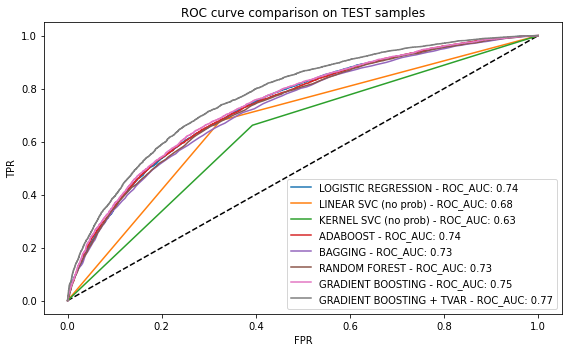

Test ROC_AUC  Test Accuracy  Test recall 0  \
LOGISTIC REGRESSION               0.74           0.68           0.67   
LINEAR SVC (no prob)              0.68           0.68           0.68   
KERNEL SVC (no prob)              0.63           0.63           0.61   
ADABOOST                          0.74           0.68           0.68   
BAGGING                           0.73           0.67           0.67   
RANDOM FOREST                     0.73           0.68           0.67   
GRADIENT BOOSTING                 0.75           0.68           0.68   
GRADIENT BOOSTING + TVAR          0.77           0.70           0.58   

                          Test recall 1  Test precision 0  Test precision 1  \
LOGISTIC REGRESSION                0.68              0.68              0.68   
LINEAR SVC (no prob)               0.68              0.68              0.68   
KERNEL SVC (no prob)               0.66              0.64              0.63   
ADABOOST                           0.68              0.68              0.68   
BAGGING                            0.67              0.67              0.67   
RANDOM FOREST                      0.68              0.68              0.67   
GRADIENT BOOSTING                  0.69              0.68              0.68   
GRADIENT BOOSTING + TVAR           0.82              0.76              0.66   

                          Test fscore 0  Test fscore 1  GSCV fit time MIN  \
LOGISTIC REGRESSION                0.68           0.68               0.15   
LINEAR SVC (no prob)               0.68           0.68               0.08   
KERNEL SVC (no prob)               0.62           0.64              20.79   
ADABOOST                           0.68           0.68               0.52   
BAGGING                            0.67           0.67               0.24   
RANDOM FOREST                      0.67           0.68               0.21   
GRADIENT BOOSTING                  0.68           0.68               2.25   
GRADIENT BOOSTING + TVAR           0.66           0.73              16.66   

                          GSCV fit time MAX GSCV HYPARAM 1  GSCV HYPARAM 2  \
LOGISTIC REGRESSION                    2.29              C        l1_ratio   
LINEAR SVC (no prob)                   5.43              C             NaN   
KERNEL SVC (no prob)                  96.08              C  kernel & gamma   
ADABOOST                              10.55   n_estimators   learning_rate   
BAGGING                               66.94   n_estimators             NaN   
RANDOM FOREST                         68.27   n_estimators    max_features   
GRADIENT BOOSTING                     39.28   n_estimators  max_leaf_nodes   
GRADIENT BOOSTING + TVAR             290.60   n_estimators  max_leaf_nodes   

                          GSCV KFOLD  
LOGISTIC REGRESSION                5  
LINEAR SVC (no prob)               5  
KERNEL SVC (no prob)               3  
ADABOOST                           5  
BAGGING                            5  
RANDOM FOREST                      5  
GRADIENT BOOSTING                  5  
GRADIENT BOOSTING + TVAR           5

In [101]:
plt.rcParams["figure.figsize"] = [8, 5]

#ROC Curve
from sklearn.metrics import roc_curve
fpr1 , tpr1, thresholds1 = roc_curve(y_test, clf_LR.predict_proba(X_test.to_numpy())[:,1])
fpr2 , tpr2, thresholds2 = roc_curve(y_test, clf_LSVC.predict(X_test.to_numpy()))
fpr3 , tpr3, thresholds3 = roc_curve(y_test, clf_KSVC.predict(X_test.to_numpy()))
fpr4 , tpr4, thresholds4 = roc_curve(y_test, clf_AD.predict_proba(X_test.to_numpy())[:,1])
fpr5 , tpr5, thresholds5 = roc_curve(y_test, clf_BAG.predict_proba(X_test.to_numpy())[:,1])
fpr6 , tpr6, thresholds6 = roc_curve(y_test, clf_RF.predict_proba(X_test.to_numpy())[:,1])
fpr7 , tpr7, thresholds7 = roc_curve(y_test, clf_GB.predict_proba(X_test.to_numpy())[:,1])
fpr8 , tpr8, thresholds8 = roc_curve(y_test, clf_GB2.predict_proba(X_test2.to_numpy())[:,1])

auc1 = metrics.roc_auc_score(y_test, clf_LR.predict_proba(X_test.to_numpy())[:,1])
auc2 = metrics.roc_auc_score(y_test, clf_LSVC.predict(X_test.to_numpy()))
auc3 = metrics.roc_auc_score(y_test, clf_KSVC.predict(X_test.to_numpy()))
auc4 = metrics.roc_auc_score(y_test, clf_AD.predict_proba(X_test.to_numpy())[:,1])
auc5 = metrics.roc_auc_score(y_test, clf_BAG.predict_proba(X_test.to_numpy())[:,1])
auc6 = metrics.roc_auc_score(y_test, clf_RF.predict_proba(X_test.to_numpy())[:,1])
auc7 = metrics.roc_auc_score(y_test, clf_GB.predict_proba(X_test.to_numpy())[:,1])
auc8 = metrics.roc_auc_score(y_test, clf_GB2.predict_proba(X_test2.to_numpy())[:,1])


plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label=("LOGISTIC REGRESSION - ROC_AUC: %0.2f" % auc1))
plt.plot(fpr2, tpr2, label=("LINEAR SVC (no prob) - ROC_AUC: %0.2f" % auc2))
plt.plot(fpr3, tpr3, label=("KERNEL SVC (no prob) - ROC_AUC: %0.2f" % auc3))
plt.plot(fpr4, tpr4, label=("ADABOOST - ROC_AUC: %0.2f" % auc4))
plt.plot(fpr5, tpr5, label=("BAGGING - ROC_AUC: %0.2f" % auc5))
plt.plot(fpr6, tpr6, label=("RANDOM FOREST - ROC_AUC: %0.2f" % auc6))
plt.plot(fpr7, tpr7, label=("GRADIENT BOOSTING - ROC_AUC: %0.2f" % auc7))
plt.plot(fpr8, tpr8, label=("GRADIENT BOOSTING + TVAR - ROC_AUC: %0.2f" % auc8))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC curve comparison on TEST samples')
plt.show()

res1=pd.DataFrame(metrics.classification_report(y_test, clf_LR.predict(X_test.to_numpy()),output_dict=True)).transpose().to_numpy()
res2=pd.DataFrame(metrics.classification_report(y_test, clf_LSVC.predict(X_test.to_numpy()),output_dict=True)).transpose().to_numpy()
res3=pd.DataFrame(metrics.classification_report(y_test, clf_KSVC.predict(X_test.to_numpy()),output_dict=True)).transpose().to_numpy()
res4=pd.DataFrame(metrics.classification_report(y_test, clf_AD.predict(X_test.to_numpy()),output_dict=True)).transpose().to_numpy()
res5=pd.DataFrame(metrics.classification_report(y_test, clf_BAG.predict(X_test.to_numpy()),output_dict=True)).transpose().to_numpy()
res6=pd.DataFrame(metrics.classification_report(y_test, clf_RF.predict(X_test.to_numpy()),output_dict=True)).transpose().to_numpy()
res7=pd.DataFrame(metrics.classification_report(y_test, clf_GB.predict(X_test.to_numpy()),output_dict=True)).transpose().to_numpy()
res8=pd.DataFrame(metrics.classification_report(y_test, clf_GB2.predict(X_test2.to_numpy()),output_dict=True)).transpose().to_numpy()

data = [[auc1,res1[2,2],res1[0,1],res1[1,1],res1[0,0],res1[1,0],res1[0,2],res1[1,2],res_LR.mean_fit_time.min(),res_LR.mean_fit_time.max(),'C','l1_ratio',5],\
       [auc2,res2[2,2],res2[0,1],res2[1,1],res2[0,0],res2[1,0],res2[0,2],res2[1,2],res_LSVC.mean_fit_time.min(),res_LSVC.mean_fit_time.max(),'C',np.nan ,5],\
       [auc3,res3[2,2],res3[0,1],res3[1,1],res3[0,0],res3[1,0],res3[0,2],res3[1,2],res_KSVC.mean_fit_time.min(),res_KSVC.mean_fit_time.max(),'C' ,'kernel & gamma',3],\
       [auc4,res4[2,2],res4[0,1],res4[1,1],res4[0,0],res4[1,0],res4[0,2],res4[1,2],res_AD.mean_fit_time.min(),res_AD.mean_fit_time.max(),'n_estimators','learning_rate',5],\
       [auc5,res5[2,2],res5[0,1],res5[1,1],res5[0,0],res5[1,0],res5[0,2],res5[1,2],res_BAG.mean_fit_time.min(),res_BAG.mean_fit_time.max(),'n_estimators',np.nan ,5],\
       [auc6,res6[2,2],res6[0,1],res6[1,1],res6[0,0],res6[1,0],res6[0,2],res6[1,2],res_RF.mean_fit_time.min(),res_RF.mean_fit_time.max(),'n_estimators','max_features',5],\
       [auc7,res7[2,2],res7[0,1],res7[1,1],res7[0,0],res7[1,0],res7[0,2],res7[1,2],res_GB.mean_fit_time.min(),res_GB.mean_fit_time.max(),'n_estimators','max_leaf_nodes',5],\
       [auc8,res8[2,2],res8[0,1],res8[1,1],res8[0,0],res8[1,0],res8[0,2],res8[1,2],res_GB2.mean_fit_time.min(),res_GB2.mean_fit_time.max(),'n_estimators','max_leaf_nodes',5]]
df = pd.DataFrame(data,index = ["LOGISTIC REGRESSION","LINEAR SVC (no prob)",\
                                "KERNEL SVC (no prob)","ADABOOST","BAGGING",\
                                "RANDOM FOREST","GRADIENT BOOSTING","GRADIENT BOOSTING + TVAR"],\
                  columns = ['Test ROC_AUC', 'Test Accuracy', 'Test recall 0','Test recall 1',\
                             'Test precision 0','Test precision 1','Test fscore 0','Test fscore 1','GSCV fit time MIN','GSCV fit time MAX','GSCV HYPARAM 1','GSCV HYPARAM 2', 'GSCV KFOLD'])
#display(df)

def highlight_cells(x):
    df = x.copy()
    
    #set particular cell colors
    df.iloc[6,0] = 'background-color: lightgreen'
    df.iloc[7,0] = 'background-color: green'
    df.iloc[2,0] = 'background-color: red'
    return df 

def bold_single_cells(x):
    df = x.copy()
    #set particular cells bold
    df.iloc[6,0] = 'font-weight: bold'
    df.iloc[7,0] = 'font-weight: bold'
    df.iloc[2,0] = 'font-weight: bold'
    return df

df.style\
    .apply(highlight_cells)\
    .apply(bold_single_cells)\
    .set_precision(3)\

print(df)

# 8) INTERPRETABILITE
* Local Interpretable Model-Agnostic Explanations LIME

## 8) a) Gradient boosting - LOCAL: LIME

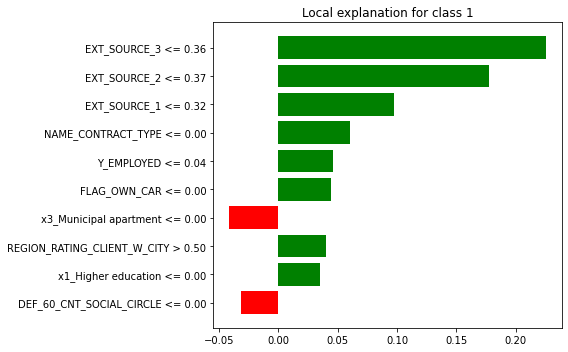

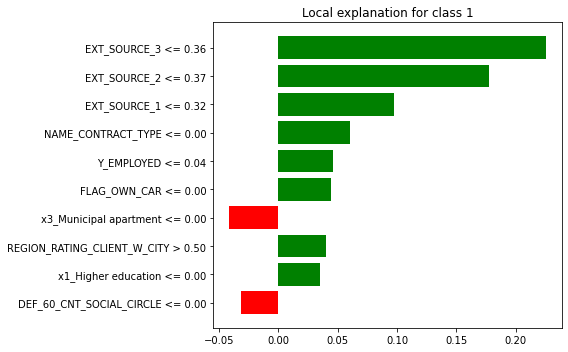

In [145]:
#ne prend pas en compte les SVC qui ne donen pas de proba
#https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions
#https://medium.com/@ulalaparis/repousser-les-limites-dexplicabilit%C3%A9-un-guide-avanc%C3%A9-de-shap-a33813a4bbfc
#https://medium.com/analytics-vidhya/shap-part-3-tree-shap-3af9bcd7cd9b
    
import lime.lime_tabular  

#mode classifier
classifier_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                             mode='classification',#'regression',
                                             training_labels=y_train,
                                             feature_names= X_train.columns)


lime_results = classifier_lime.explain_instance(X_test.values[33], clf_GB.predict_proba)
lime_results.show_in_notebook()

lime_results.as_pyplot_figure()


## 8) b) Gradient boosting - GLOBAL : Features importance vs permutation importance

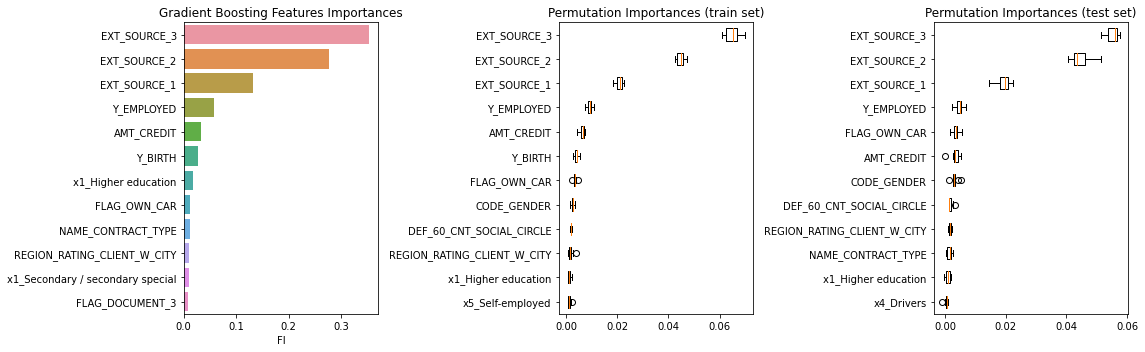

In [138]:
#pour sortir les features_importances du gradient boosting on est oblige de relancer un fit sans gridsearchcv
from sklearn.ensemble import GradientBoostingClassifier
clf_GB_no_GSCV = GradientBoostingClassifier(learning_rate= 0.05, max_leaf_nodes= 16, n_estimators= 300, tol= 0.001)
clf_GB_no_GSCV.fit(X_train, y_train.values.ravel())


########Permutation
#########################################################################

from sklearn.inspection import permutation_importance
result1 = permutation_importance(
    clf_GB_no_GSCV, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
#donne les index triés par importance inverse de la variable
sorted1_idx = result1.importances_mean.argsort()

hh1=pd.DataFrame(result1.importances[sorted1_idx].T)
hh1.columns=X_test.columns[sorted1_idx]
##########################################################################
result2 = permutation_importance(
    clf_GB_no_GSCV, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1
)
#donne les index triés par importance inverse de la variable
sorted2_idx = result2.importances_mean.argsort()

hh2=pd.DataFrame(result2.importances[sorted2_idx].T)
hh2.columns=X_train.columns[sorted2_idx]

plt.rcParams["figure.figsize"] = [16, 5]
plt.rcParams["figure.autolayout"] = True

#plt.figure(figsize=(16,15))
plt.figure(figsize=(16,5))
ax0 = plt.subplot(1,3,1)
ax1 = plt.subplot(1,3,2)
ax2 = plt.subplot(1,3,3)

h=pd.DataFrame(clf_GB_no_GSCV.feature_importances_,index=X_train.columns,columns=['FI'])
h2=h.sort_values('FI',ascending=False).head(12)

sns.barplot(x=h2.FI, y=h2.index, data=h2, ax=ax0)
ax0.set_title('Gradient Boosting Features Importances')

ax1.boxplot(hh2[hh2.columns[-12:]], vert=False,labels=hh2[hh2.columns[-12:]].columns)
ax1.set_title("Permutation Importances (train set)")

ax2.boxplot(hh1[hh1.columns[-12:]], vert=False,labels=hh1[hh1.columns[-12:]].columns)
ax2.set_title("Permutation Importances (test set)")


fig.tight_layout()
plt.show()

## 8) c) GRADIENT BOOSTING + VARIABLES TRANSFORMEES - LOCAL: LIME

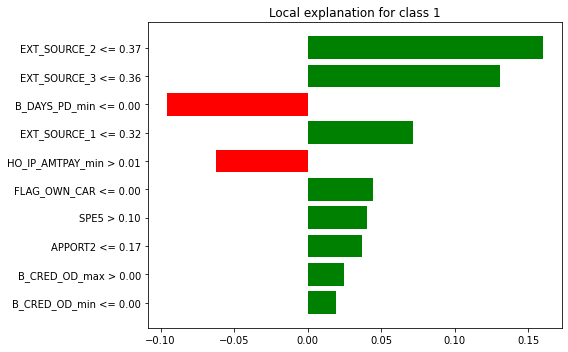

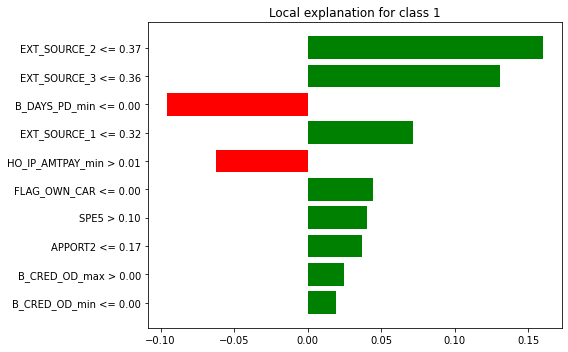

In [146]:
#ne prend pas en compte les SVC qui ne donen pas de proba
#https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions
#https://medium.com/@ulalaparis/repousser-les-limites-dexplicabilit%C3%A9-un-guide-avanc%C3%A9-de-shap-a33813a4bbfc
#https://www.aquiladata.fr/insights/interpretabilite-des-modeles-de-machine-learning/
    
import lime.lime_tabular  

#mode classifier
classifier_lime = lime.lime_tabular.LimeTabularExplainer(X_train2.values,
                                             mode='classification',#'regression',
                                             training_labels=y_train,
                                             feature_names= X_train2.columns)


lime_results = classifier_lime.explain_instance(X_test2.values[33], clf_GB2.predict_proba)
lime_results.show_in_notebook()
lime_results.as_pyplot_figure()

## 8) d) Gradient boosting + VARIABLES TRANSFORMEES - GLOBAL : Features importance vs permutation importance

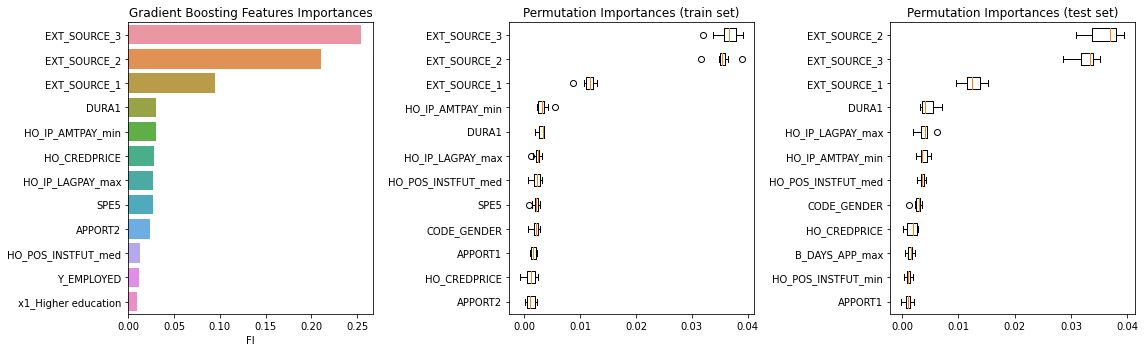

In [142]:
#pour sortir les features_importances du gradient boosting on est oblige de relancer un fit sans gridsearchcv
from sklearn.ensemble import GradientBoostingClassifier
clf_GB2_no_GSCV = GradientBoostingClassifier(learning_rate= 0.05, max_leaf_nodes= 16, n_estimators= 300, tol= 0.001)
clf_GB2_no_GSCV.fit(X_train, y_train.values.ravel())


########Permutation
#########################################################################

from sklearn.inspection import permutation_importance
result1 = permutation_importance(
    clf_GB2_no_GSCV, X_test2, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
#donne les index triés par importance inverse de la variable
sorted1_idx = result1.importances_mean.argsort()

hh1=pd.DataFrame(result1.importances[sorted1_idx].T)
hh1.columns=X_test2.columns[sorted1_idx]
##########################################################################
result2 = permutation_importance(
    clf_GB2_no_GSCV, X_train2, y_train, n_repeats=10, random_state=42, n_jobs=-1
)
#donne les index triés par importance inverse de la variable
sorted2_idx = result2.importances_mean.argsort()

hh2=pd.DataFrame(result2.importances[sorted2_idx].T)
hh2.columns=X_train2.columns[sorted2_idx]

plt.rcParams["figure.figsize"] = [16, 5]
plt.rcParams["figure.autolayout"] = True

#plt.figure(figsize=(16,15))
plt.figure(figsize=(16,5))
ax0 = plt.subplot(1,3,1)
ax1 = plt.subplot(1,3,2)
ax2 = plt.subplot(1,3,3)

h=pd.DataFrame(clf_GB2_no_GSCV.feature_importances_,index=X_train2.columns,columns=['FI'])
h2=h.sort_values('FI',ascending=False).head(12)

sns.barplot(x=h2.FI, y=h2.index, data=h2, ax=ax0)
ax0.set_title('Gradient Boosting Features Importances')

ax1.boxplot(hh2[hh2.columns[-12:]], vert=False,labels=hh2[hh2.columns[-12:]].columns)
ax1.set_title("Permutation Importances (train set)")

ax2.boxplot(hh1[hh1.columns[-12:]], vert=False,labels=hh1[hh1.columns[-12:]].columns)
ax2.set_title("Permutation Importances (test set)")


fig.tight_layout()
plt.show()